In [1]:
from itertools import product
import glob
import pickle

import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature import NaturalEarthFeature
import xarray as xr
from scipy.ndimage import gaussian_filter
import datetime

import xesmf as xe
import metpy.calc as mpcalc
from minisom import MiniSom,asymptotic_decay
from collections import Counter
# import optuna
#import sklearn
#from sklearn.metrics import mean_squared_error

In [2]:
# reading in met table statistics
centers_filtered_new=pd.read_csv('filtered_centers_comet_144.csv')
centers_date_pd=pd.DataFrame(centers_filtered_new['date'])
centers_mask=centers_date_pd['date'].apply(lambda x: pd.to_datetime(str(x[:-7]), format='%Y%m%d'))
centers_filtered_new['fmt_date']=centers_mask

lon=centers_filtered_new['x']
lat=centers_filtered_new['y']

In [3]:
centers_filtered_new[(centers_filtered_new['case'].astype(str).str[0]=='F')&(np.isnan(centers_filtered_new['interest']))]

In [4]:
centers_filtered_new.columns

In [5]:
centers_filtered_new['intersect']=centers_filtered_new['intersect'].replace(-999.0, np.nan)
centers_filtered_new['obs']=centers_filtered_new['obs'].replace(-999.0, np.nan)
centers_filtered_new['forecast']=centers_filtered_new['forecast'].replace(-999.0, np.nan)

In [6]:
centers_filtered_new['moe_x']=centers_filtered_new['intersect'].div((centers_filtered_new['obs'].values))
centers_filtered_new['moe_y']=centers_filtered_new['intersect'].div((centers_filtered_new['forecast'].values))
centers_filtered_new['dist']=np.sqrt(((1-centers_filtered_new['moe_x'])**2) + ((1-centers_filtered_new['moe_y'])**2))

In [7]:
Fa=np.where((centers_filtered_new['case'].astype(str).str[0]=='F')&(np.isnan(centers_filtered_new['interest']))
   | (centers_filtered_new['case'].astype(str).str[0]=='O'))

In [8]:
centers_miss_fa=centers_filtered_new.iloc[Fa]
justfa=np.where((centers_filtered_new['case'].astype(str).str[0]=='F')&(np.isnan(centers_filtered_new['interest'])))
justm=np.where((centers_filtered_new['case'].astype(str).str[0]=='O'))
centers_miss=centers_filtered_new.iloc[justm]
centers_fa=centers_filtered_new.iloc[justfa]

In [9]:
centers_mask=~centers_filtered_new['fmt_date'].isin(centers_miss_fa['fmt_date'])
centers_nonmatch=centers_filtered_new['fmt_date'].isin(centers_miss_fa['fmt_date'])


centers_matched=centers_filtered_new[centers_mask]
centers_unmatch=centers_filtered_new[centers_nonmatch]

In [10]:
lon_match=centers_matched['x']
lat_match=centers_matched['y']

lon_unmatch=centers_unmatch['x']
lat_unmatch=centers_unmatch['y']

In [11]:
diff_forecast=xr.open_dataset('diff_matched.nc')

In [12]:
diff_forecast

In [13]:
diff_stack=diff_forecast['variable'].stack(new=('y','x'))

In [14]:
diff_stack

In [15]:
diff_forecast.to_netcdf('diffstack_144_dec10.nc')

In [16]:
centers_miss['x'][centers_miss['fmt_date']=='1997-12-21']

In [17]:
dist_mask=centers_matched['fmt_date'].isin(pd.to_datetime(diff_forecast['time']))

In [18]:
miss_mask=centers_miss['fmt_date'].isin(pd.to_datetime(diff_forecast['time']))
fa_mask=centers_fa['fmt_date'].isin(pd.to_datetime(diff_forecast['time']))

In [19]:
dist_new=xr.Dataset({'variable': (['time'],centers_matched['dist'][dist_mask])},
             coords={"lon":(["y"],diff_forecast['lon'].data), #should change to lonlist/latlist 
                     "lat":(["x"],diff_forecast['lat'].data),
                    "time":(["time"],diff_forecast['time'].data)})

In [20]:
# dist_new.to_netcdf('144hrdist_56x56.nc')

In [21]:
miss_new=xr.Dataset({'variable': (['time'],centers_miss['fmt_date'][miss_mask])},
             coords={"lon":(["y"],diff_forecast['lon'].data), #should change to lonlist/latlist 
                     "lat":(["x"],diff_forecast['lat'].data),
                    "time":(["time"],centers_miss['fmt_date'][miss_mask])})

In [22]:
fa_new=xr.Dataset({'variable': (['time'],centers_fa['fmt_date'][fa_mask])},
             coords={"lon":(["y"],diff_forecast['lon'].data), #should change to lonlist/latlist 
                     "lat":(["x"],diff_forecast['lat'].data),
                    "time":(["time"],centers_fa['fmt_date'][fa_mask])})

In [23]:
landfall=pd.read_csv('WC-Landfalling-AR-Events-Master-10-19.csv')

In [24]:
landfall

In [25]:
landfmt=landfall['maxScaletime'].apply(lambda x :str(x)[0:4]+'-'+str(x)[4:6]+'-'+str(x)[6:8])

In [26]:
landfmt

In [27]:
# regridwrf_match['variable'][pv_mask].isel(time=0).plot()

In [28]:
# era5['variable'][pv_mask].isel(time=0).plot()

In [29]:
diff_forecast['variable']

In [30]:
def normalize_data(data):
    """
    Function for normalizing data prior to training using z-score
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [31]:
pv=xr.open_dataset('pv_matched_masked.nc')
slp_final=xr.open_dataset('slp_matched_final.nc')

In [32]:
pv

In [33]:
pv_mask=pv['time'].isin(slp_final['time'])

In [34]:
column_names=['year','month','day', 'x_amp','y_amp','phase']

In [35]:
mjo=pd.read_csv('psl.noaa.gov_mjo_mjoindex_rMII_index_latest.txt',header=None)

In [36]:
mjo_2017=mjo.iloc[0:14245]

In [37]:
mjo_2017.to_csv('mjo2017.csv')

In [38]:
mjo_2017_filtered=pd.read_csv('mjo2017.csv')

In [39]:
data_lines=[]
with open('psl.noaa.gov_mjo_mjoindex_rMII_index_latest.txt','r') as data_file:
    for line in data_file:
        data = line.split()
        data_lines.append(data)

In [40]:
mjo_datatable=pd.DataFrame(data_lines,columns=column_names)

In [41]:
mjo_datatable

In [42]:
mjo_datatable['year']+mjo_datatable['month']+mjo_datatable['day']

In [43]:
mjo_datatable['month']=mjo_datatable['month'].apply(lambda x: str(x).zfill(2) if int(x) < 10 else x)

In [44]:
mjo_datatable['day']=mjo_datatable['day'].apply(lambda x: str(x).zfill(2) if int(x) < 10 else x)

In [45]:
mjo_datatable

In [46]:
mjo_datatable['year']+'-'+mjo_datatable['month']+'-'+mjo_datatable['day']

In [47]:
mjo_datatable['fmt_date']=mjo_datatable['year']+'-'+mjo_datatable['month']+'-'+mjo_datatable['day']

In [48]:
mjo_datatable

In [49]:
new_mjo=pd.read_csv('greta_mjo_data.csv')

In [50]:
new_mjo

In [51]:
# new_time=diff_forecast['time'][pv_mask].to_dataframe()

In [52]:
with open('som_matched_144_3.05_final.p', 'rb') as infile:
        som_matched = pickle.load(infile)

In [53]:
#  pv_new=mpcalc.smooth_gaussian(pv_new,0.5)

In [54]:
import matplotlib.colors as mcolors
colors = ['#FFFF00', '#FFEE00','#FFDC00', '#FFB700',
          '#FFA300', '#FF9000', '#FF7D00', '#FF6800',
          '#FF5200', '#C70039','#900C3F', (.88,.24,.69)]

matching=1
som=4
di_dates={}
if som==4 and matching ==1:
    
    era5ss_match=xr.open_dataset('era5ss_matched_0605.nc')
    regridwrf_match=xr.open_dataset('regridwrfss_matched_0605.nc')
    diff_forecast=xr.open_dataset('diff_matched_0605.nc')
    diff_stack=diff_forecast['variable'][pv_mask].stack(new=('y','x'))
    smooth_fcst=xr.open_dataset('fcst_matched.nc')
    smooth_obs=xr.open_dataset('obs_matched.nc')
    
#     new_fcst=old_fcst['__xarray_dataarray_variable__'][pv_mask]
#     new_obs=old_obs['__xarray_dataarray_variable__'][pv_mask]
    ht_final=xr.open_dataset('ht_matched_final.nc')
    slp_final=xr.open_dataset('slp_matched_final.nc')
#     pv=xr.open_dataset('pv_matched_masked.nc')
    pv_new=pv['__xarray_dataarray_variable__'][pv_mask]
    pv_new=mpcalc.smooth_gaussian(pv_new,0.25)
#     west_wrf=xr.open_dataset('wrf_matched_final.nc')
   
    
    
    
#     dist_mask=centers_unmatch['fmt_date'].isin(diff_forecast['time'])
#     dist_new=xr.Dataset({'variable': (['time'],centers_unmatch['dist'])},
#              coords={"lon":(["y","x"],diff_forecast['lon'].data),
#                      "lat":(["y","x"],diff_forecast['lat'].data),
#                     "time":(["time"],diff_forecast['time'])})
    centers_unmatch[(centers_unmatch['fmt_date']).isin(landfmt)]
#     with open('som_matched_144_3.05815.p', 'rb') as infile:
#         som_matched = pickle.load(infile)
    newsom=som_matched

    plt.figure(figsize=(10, 9))
    cs = plt.pcolormesh(newsom.distance_map(), cmap='hot')
    plt.title("distance map of the ivt", fontsize=12)
    plt.colorbar(cs)
    plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
    plt.show()


    # this may take a few minutes if lots of data! currently doing every 20th point so not bad

    # grab the x and y coords across the lattice for the winner node for each data point

    w_x, w_y = zip(*[newsom.winner(w) for w in normalize_data(diff_stack).values])
    print(len(w_x))
    w_x = np.array(w_x)
    w_y = np.array(w_y)
    print(w_x)
    print(w_y)

    # visualize where data falls in lattice (nearest winning neuron/node)

    plt.figure(figsize=(10, 9))
    plt.pcolormesh(newsom.distance_map(), cmap='Blues', alpha=.2)
    plt.colorbar()

    for num, c in enumerate(w_x[::1]):     # every 20th data point

        plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
                    w_x[num] + np.random.rand(1),
                    s=50, c='k', marker='x')

    plt.title("IVT data across SOM lattice", fontsize=12)
    plt.margins(x=0,y=0)
    plt.grid()
    plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
    plt.show()



    plt.figure(figsize=(10, 9))
    frequencies = newsom.activation_response(normalize_data(diff_stack).values)
    plt.pcolormesh(frequencies, cmap='Blues') 
    plt.colorbar()
    plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
    plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
    plt.show()

    # grabbing indices from SOM
    #all the cases for 2016-2017 500 mb heights are fairly similar 
    # create an empty dictionary using the rows and columns of SOM
    keys = [i for i in product(range(4),range(4))]
    winmap = {key: [] for key in keys}

    # grab the indices for the data within the SOM lattice
    for i, x in enumerate(normalize_data(diff_stack).values):
        winmap[newsom.winner(x)].append(i)

    print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")
    som_keys = list(winmap.keys())
    print(som_keys)
    print(f"Number of composite maps: {len(som_keys)}")


    ##plot som##
    fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))
    di_dates={}



    # (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
    for map_num in range(len(som_keys)):

        diff_data = diff_stack[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
        fcst_data=smooth_fcst['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
        obs_data=smooth_obs['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
        pv_data=pv_new[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
    #         #diff_data=diff_fcsts[np.array(winmap[som_keys[map_num]])].unstack().sum(dim="time",skipna=True)
        slp=slp_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        ht500=ht_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        pvplot=np.where(pv_data>.40,pv_data,np.nan)
        dist_data=dist_new['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

        ivt_era=era5ss_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        ivt_wwrf=regridwrf_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

        di_dates[som_keys[map_num][0],som_keys[map_num][1]]=diff_stack['time'][np.array(winmap[som_keys[map_num]])].values


#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(slp,vmin=995, vmax=1020,cmap='rainbow')#cmap="Blues", 
        label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(diff_data,vmin=-500, vmax=500,cmap='bwr')
#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(pvplot,vmin=.45, vmax=.8,cmap='cool')
#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(ivt_era,vmin=200, vmax=800, cmap='viridis')



        n=(frequencies.flatten()[map_num])
    #         htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500,colors="white") 

#             diffctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(diff_data,colors="black")  
        fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(fcst_data,colors="black", levels=[n/8,n/4,n/2])  
        obsctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(obs_data,colors="green",levels=[n/8,n/4,n/2])#cmap="Blues", 
#             htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500, colors='black') #cmap="Blues", 
#             slpctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(slp, colors='black')
        geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f" # of cases: {int(frequencies.flatten()[map_num])}", fontsize=12)

#             plt.clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='black')
#             plt.clabel(slpctr,slpctr.levels[::2],fmt='%1.0f',colors='black')

    #                    
        plt.clabel(fcstctr,fmt='%1.0f',colors='black')
        plt.clabel(obsctr,fmt='%1.0f',colors='green')
    #         # plot the figure containing all plots


    plt.tight_layout()
    fig = plt.gcf()
#         fig.suptitle("144hr 851 PV +SLP {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
#         fig.suptitle("144hr 698 Unmatched SLP+500 mb hts {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
    fig.suptitle(" 144hr 851 Matched ERA5 IVT {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
    #ax1=fig.colorbar(label, ax=fig.get_axes())
    cbar=fig.colorbar(label, ax=fig.get_axes())
#         cbar.ax.set_ylabel('900-700 layer avg PV (PVU)', rotation=270, fontsize=20,labelpad=20)
# #               )
#         cbar.ax.set_ylabel('SLP (mb)', rotation=270, fontsize=20,labelpad=20)
# #               )
    cbar.ax.set_ylabel('IVT (kg/ms))', rotation=270, fontsize=20,labelpad=20
          )

    plt.show()


In [55]:
pv['__xarray_dataarray_variable__'][pv_mask].isel(time=200).plot()

In [56]:
pv['__xarray_dataarray_variable__'][pv_mask].isel(time=0).plot()

In [57]:
pv_unsmoothed=xr.open_dataset('pvmatchedmasked_unsmoothfinal.nc')

In [58]:
pv_unsmoothed['variable'][pv_mask].isel(time=0).plot()

In [59]:
anom=ht_final-ht_final.mean()

In [60]:
ht500['lon']

In [61]:
full_hts=xr.open_dataset('hts1629.nc')

In [62]:
full_hts2=xr.open_dataset('hts144.nc')

In [63]:
full_hts2

In [64]:
mask_hts=full_hts2['time'].isin(diff_stack['time'])

In [65]:
full_hts2['variable'][mask_hts]

In [66]:
full_hts2['variable'][mask_hts].mean()

In [67]:
full_hts2['variable'][mask_hts].mean(dim='time').plot()

In [68]:
anom_full=full_hts2['variable'][mask_hts]-full_hts2['variable'][mask_hts].mean(dim='time')

In [69]:
full_hts2['variable'][mask_hts].mean(dim='time').plot() # make this a full contour plot 

In [70]:
full_hts2=xr.open_dataset('hts144.nc')
# anom_full.to_netcdf('anomfull_wwrf.nc')

In [71]:
full_hts2['variable'][mask_hts].isel(time=50).plot()

In [72]:
full_hts2['variable'][mask_hts].mean(dim='time').plot()

In [73]:
anom_full.isel(time=50).plot()

In [74]:
anom_full[np.array(winmap[som_keys[map_num]])].plot(col='time',col_wrap=4)

In [75]:
anom_full.min(), anom_full.max()

In [76]:
centlat=xr.open_dataset('centlat_final.nc')
centlon=xr.open_dataset('centlon_final.nc')

In [77]:
centlat['variable'][pv_mask]

In [78]:
centlon['variable'][pv_mask]

In [79]:
lons=np.asarray(centers_matched['x'])
lats=np.asarray(centers_matched['y'])

In [80]:
centers_matched['fmt_date']

In [81]:
def indices_coords(ds, lon, lat):
    """
    Extract indices from WRF grid using lat and lon values of AR objects.
    
    Args:
        ds: xarray dataset of WRF d01 grid
        lon (float): longitude value of AR object from csv
        lat (float): latitude value of AR object from csv
        
    """
    #print(ds.lat, lat)
    abslat = np.abs(ds.lat - lat)
    #print(abslat)
    #print(ds.lon, lon)
    abslon = np.abs(ds.lon - lon)
    #print(abslon)
    c = np.maximum(abslon, abslat)
    
    loc_x=np.where(c == np.min(c))[0][0]
    loc_y=np.where(c == np.min(c))[1][0]
    #([loc_x], [loc_y]) = np.where(c == np.min(c))
    #print(loc_x, loc_y)
    return (loc_x, loc_y)

In [82]:
# with open('som_matched_144_3.05_final.p', 'wb') as outfile:
#     pickle.dump(newsom, outfile)

In [83]:
with open('som_matched_144_3.05_final.p', 'rb') as infile:
    newsom = pickle.load(infile)

In [84]:
newsom.get_weights()

In [85]:
with open('som_matched_144_3.05_final.p', 'rb') as infile:
    newsom = pickle.load(infile)
# if som==newsom:
    
        
plt.figure(figsize=(10, 9))
cs = plt.pcolormesh(newsom.distance_map(), cmap='hot')
plt.title("distance map of the ivt", fontsize=12)
plt.colorbar(cs)
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()


# this may take a few minutes if lots of data! currently doing every 20th point so not bad

# grab the x and y coords across the lattice for the winner node for each data point

w_x, w_y = zip(*[newsom.winner(w) for w in normalize_data(diff_stack).values])
print(len(w_x))
w_x = np.array(w_x)
w_y = np.array(w_y)
print(w_x)
print(w_y)

# visualize where data falls in lattice (nearest winning neuron/node)

plt.figure(figsize=(10, 9))
plt.pcolormesh(newsom.distance_map(), cmap='Blues', alpha=.2)
plt.colorbar()

for num, c in enumerate(w_x[::1]):     # every 20th data point

    plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
                w_x[num] + np.random.rand(1),
                s=50, c='k', marker='x')

plt.title("IVT data across SOM lattice", fontsize=12)
plt.margins(x=0,y=0)
plt.grid()
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()



plt.figure(figsize=(10, 9))
frequencies = newsom.activation_response(normalize_data(diff_stack).values)
plt.pcolormesh(frequencies, cmap='Blues') 
plt.colorbar()
plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()

# grabbing indices from SOM
#all the cases for 2016-2017 500 mb heights are fairly similar 
# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(4),range(4))]
winmap = {key: [] for key in keys}

# grab the indices for the data within the SOM lattice
for i, x in enumerate(normalize_data(diff_stack).values):
    winmap[newsom.winner(x)].append(i)

print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")
som_keys = list(winmap.keys())
print(som_keys)
print(f"Number of composite maps: {len(som_keys)}")


##plot som##
fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))




# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
for map_num in range(len(som_keys)):

    diff_data = diff_stack[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
    fcst_data=smooth_fcst['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
    obs_data=smooth_obs['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
#     rmse_data=np.mean(dict_rmse[som_keys[map_num]])
    dist_data=dist_new['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             pv_data=pv[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         #         #diff_data=diff_fcsts[np.array(winmap[som_keys[map_num]])].unstack().sum(dim="time",skipna=True)
#             slp=slp_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             ht500=ht_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             pvplot=np.where(pv_data>.40,pv_data,np.nan)
#         #         pvplot=np.where(pv_data>.40,pv_data,np.nan)

#         ivt_era=era5ss_unmatch['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         ivt_wwrf=regridwrf_unmatch['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

    #di_dates[som_keys[map_num][0],som_keys[map_num][1]]=diff_stack['time'][np.array(winmap[som_keys[map_num]])]

    projection = ccrs.PlateCarree()
    axs_class = (GeoAxes,
    dict(map_projection=projection))

#             g=[]
#             di_misses_v2={}
#             for m in miss_new['variable'].values:
#                 for key in di_dates:
#                                 #print(key)
#                     if m in di_dates[key]:

#                         if key not in di_misses_v2.keys():
#                                     di_misses_v2.update({key:m})
#                         else:
#                                 di_misses_v2[key] = di_misses_v2[key],m

#                         g.append(key)
#             e=[]
#             fa_dict={}
#             for f in fa_new['variable'].values:
#                 for key in di_dates:
#                     if f in di_dates[key]:
#                             if key not in fa_dict.keys():
#                                     fa_dict.update({key:f})
#                             else:
#                                     fa_dict[key] = fa_dict[key],f

#                             e.append(key)


#             new_dict=Counter(g)
#             new_dict_fa=Counter(e)





#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(slp,vmin=995, vmax=1020,cmap='rainbow')#cmap="Blues", 
    label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(diff_data,vmin=-500, vmax=500,cmap='bwr')
#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(pvplot,vmin=.45, vmax=.8,cmap='cool')


    n=(frequencies.flatten()[map_num])
#         htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500,colors="white") 

    #diffctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(diff_data,colors="black")  
    fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(fcst_data,colors="black", levels=[n/8,n/4,n/2])  
    obsctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(obs_data,colors="green",levels=[n/8,n/4,n/2])#cmap="Blues", 
#             htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500, colors='black') #cmap="Blues", 
#             slpctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(slp, colors='black')
#     geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f"Dist from MoE: {dist_data.values:.2f}\n Mean RMSE: {rmse_data:.3g}", fontsize=12)
# #             plt.clabel(slpctr,slpctr.levels[::2],fmt='%1.0f',colors='black')
#             plt.clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='black')

#                    
    plt.clabel(fcstctr,fmt='%1.0f',colors='black')
    plt.clabel(obsctr,fmt='%1.0f',colors='green')

#         # plot the figure containing all plots



    font = {
            'color':  'white',
            'weight': 'normal',
            'size': 11,
            }

    props = dict(boxstyle='round', facecolor='teal', alpha=.9)           
    geo_axs[som_keys[map_num][0],som_keys[map_num][1]].text(46.5,2,f" #{int(frequencies.flatten()[map_num])}",bbox=props,fontdict=font)
    plt.subplots_adjust(left=0.1,
            bottom=.1, 
            right=0.5, 
            top=.9, 
            wspace=0.8, 
            hspace=0.10)


plt.tight_layout()
fig = plt.gcf()
# twin_ax = fig.add_axes([-.05, 0.1, 0.02, 0.8])
# twin_ax.set_ylabel('Gridpoints in the north-south direction (1800 km)', fontsize=20, labelpad=10)
#twin_ax.yaxis.set_label_coords(1.1, 0.5)  # Adjust the position of the label
fig.text(-0.03, 0.5, 'Gridpoints in the south-north direction', fontsize=20, ha='center', va='center', rotation=90)


fig.text(.4,-.05,'Gridpoints in the west-east direction', fontsize=20, ha='center', va='center')

fig.suptitle(" 144hr 849 IVT Difference Matched \n Black West-WRF+Green ERA5 Contours ".format(sigma=newsom._sigma,lr =newsom._learning_rate), fontsize=20,y=1.05, x=0.45, fontweight='bold')

#Sigma:{sigma:.2f},LR:{lr:.4f}
#ax1=fig.colorbar(label, ax=fig.get_axes())
cbar=fig.colorbar(label, ax=fig.get_axes())

cbar.ax.set_ylabel('Difference of IVT btw West-WRF - ERA5 (kg/ms)', rotation=270, fontsize=20,labelpad=20
      )



plt.show()


In [86]:
dict_rmse={}


for sk in som_keys:
    #print(sk)
    rmse_arr=[]

    for i in  range(len(np.array(winmap[sk]))):
        
        
            rmse=(np.sqrt(np.square(diff_forecast['variable'][np.array(winmap[sk])].isel(time=i)-\
                            
            diff_forecast['variable'][np.array(winmap[sk])].mean(dim='time')).values.mean()))
            
            rmse_arr.append(rmse)
            
    dict_rmse[sk]= rmse_arr

In [87]:

# if som==newsom:
    
        
plt.figure(figsize=(10, 9))
cs = plt.pcolormesh(newsom.distance_map(), cmap='hot')
plt.title("distance map of the ivt", fontsize=12)
plt.colorbar(cs)
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()


# this may take a few minutes if lots of data! currently doing every 20th point so not bad

# grab the x and y coords across the lattice for the winner node for each data point

w_x, w_y = zip(*[newsom.winner(w) for w in normalize_data(diff_stack).values])
print(len(w_x))
w_x = np.array(w_x)
w_y = np.array(w_y)
print(w_x)
print(w_y)

# visualize where data falls in lattice (nearest winning neuron/node)

plt.figure(figsize=(10, 9))
plt.pcolormesh(newsom.distance_map(), cmap='Blues', alpha=.2)
plt.colorbar()

for num, c in enumerate(w_x[::1]):     # every 20th data point

    plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
                w_x[num] + np.random.rand(1),
                s=50, c='k', marker='x')

plt.title("IVT data across SOM lattice", fontsize=12)
plt.margins(x=0,y=0)
plt.grid()
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()



plt.figure(figsize=(10, 9))
frequencies = newsom.activation_response(normalize_data(diff_stack).values)
plt.pcolormesh(frequencies, cmap='Blues') 
plt.colorbar()
plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()

# grabbing indices from SOM
#all the cases for 2016-2017 500 mb heights are fairly similar 
# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(4),range(4))]
winmap = {key: [] for key in keys}

# grab the indices for the data within the SOM lattice
for i, x in enumerate(normalize_data(diff_stack).values):
    winmap[newsom.winner(x)].append(i)

print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")
som_keys = list(winmap.keys())
print(som_keys)
print(f"Number of composite maps: {len(som_keys)}")


##plot som##
fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))




# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
for map_num in range(len(som_keys)):

    diff_data = diff_stack[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
    fcst_data=smooth_fcst['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
    obs_data=smooth_obs['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
    rmse_data=np.mean(dict_rmse[som_keys[map_num]])
    dist_data=dist_new['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             pv_data=pv[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         #         #diff_data=diff_fcsts[np.array(winmap[som_keys[map_num]])].unstack().sum(dim="time",skipna=True)
#             slp=slp_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
    ht500=ht_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             pvplot=np.where(pv_data>.40,pv_data,np.nan)
#         #         pvplot=np.where(pv_data>.40,pv_data,np.nan)

#     x_min, x_max = np.min(w_y[winmap[som_keys[map_num]]]), np.max(w_y[winmap[som_keys[map_num]]])
#     y_min, y_max = np.min(w_x[winmap[som_keys[map_num]]]), np.max(w_x[winmap[som_keys[map_num]]])

    ivt_era=era5ss_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
    ivt_wwrf=regridwrf_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

    #di_dates[som_keys[map_num][0],som_keys[map_num][1]]=diff_stack['time'][np.array(winmap[som_keys[map_num]])]

    projection = ccrs.PlateCarree()
    axs_class = (GeoAxes,
    dict(map_projection=projection))

#             g=[]
#             di_misses_v2={}
#             for m in miss_new['variable'].values:
#                 for key in di_dates:
#                                 #print(key)
#                     if m in di_dates[key]:

#                         if key not in di_misses_v2.keys():
#                                     di_misses_v2.update({key:m})
#                         else:
#                                 di_misses_v2[key] = di_misses_v2[key],m

#                         g.append(key)
#             e=[]
#             fa_dict={}
#             for f in fa_new['variable'].values:
#                 for key in di_dates:
#                     if f in di_dates[key]:
#                             if key not in fa_dict.keys():
#                                     fa_dict.update({key:f})
#                             else:
#                                     fa_dict[key] = fa_dict[key],f

#                             e.append(key)


#             new_dict=Counter(g)
#             new_dict_fa=Counter(e)





#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(slp,vmin=995, vmax=1020,cmap='rainbow')#cmap="Blues", 
    label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(ivt_wwrf,vmin=200, vmax=800,cmap='viridis')
#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(pvplot,vmin=.45, vmax=.8,cmap='cool')


    n=(frequencies.flatten()[map_num])
#         htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500,colors="white") 

    #diffctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(diff_data,colors="black")  
#     fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(fcst_data,colors="black", levels=[n/8,n/4,n/2])  
#     obsctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(obs_data,colors="green",levels=[n/8,n/4,n/2])#cmap="Blues", 
    
    htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500, colors='black',levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040]) #cmap="Blues", 
#             slpctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(slp, colors='black')
    geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f"Dist from MoE: {dist_data.values:.2f}\n Mean RMSE: {rmse_data:.3g}", fontsize=12)
#             plt.clabel(slpctr,slpctr.levels[::2],fmt='%1.0f',colors='black')
    plt.clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='black')



#                    
#     plt.clabel(fcstctr,fmt='%1.0f',colors='black')
#     plt.clabel(obsctr,fmt='%1.0f',colors='green')
#         # plot the figure containing all plots



    font = {
            'color':  'white',
            'weight': 'normal',
            'size': 11,
            }

    props = dict(boxstyle='round', facecolor='teal', alpha=.9)           
    geo_axs[som_keys[map_num][0],som_keys[map_num][1]].text(46.5,2,f" #{int(frequencies.flatten()[map_num])}",bbox=props,fontdict=font)
#     plt.subplots_adjust(left=0.1,
#             bottom=.1, 
#             right=1.5, 
#             top=.9, 
#             wspace=0.8, 
#             hspace=0)


plt.tight_layout()
fig = plt.gcf()
fig.suptitle(" 144hr 849 IVT WWRF Matched \n WWRF 500mb ht contours ".format(sigma=newsom._sigma,lr =newsom._learning_rate), fontsize=20,y=1.05, x=0.45, fontweight='bold')
#Sigma:{sigma:.2f},LR:{lr:.4f}
#ax1=fig.colorbar(label, ax=fig.get_axes())
cbar=fig.colorbar(label, ax=fig.get_axes())
cbar.ax.set_ylabel('IVT (kg/ms)', rotation=270, fontsize=20,labelpad=20
      )

plt.show()


In [88]:
import matplotlib.colors as mcolors
colors = ['#FFFF00', '#FFEE00','#FFDC00', '#FFB700',
          '#FFA300', '#FF9000', '#FF7D00', '#FF6800',
          '#FF5200', '#C70039','#900C3F', (.88,.24,.69)]

matching=1
som=4
di_dates={}
di_htanom={}
di_hts={}
# di_lons={}
# di_lats={}
if som==4 and matching ==1:
    
    era5ss_match=xr.open_dataset('era5ss_matched_0605.nc')
    regridwrf_match=xr.open_dataset('regridwrfss_matched_0605.nc')
    diff_forecast=xr.open_dataset('diff_matched_0605.nc')
    diff_stack=diff_forecast['variable'][pv_mask].stack(new=('y','x'))
    smooth_fcst=xr.open_dataset('fcst_matched.nc')
    smooth_obs=xr.open_dataset('obs_matched.nc')
    full_hts2=xr.open_dataset('hts144.nc')
    wwrf_full=xr.open_dataset('anomfull_wwrf.nc')
#     anom_full.to_netcdf('anomfull_wwrf.nc')
    
    
#     new_fcst=old_fcst['__xarray_dataarray_variable__'][pv_mask]
#     new_obs=old_obs['__xarray_dataarray_variable__'][pv_mask]
    ht_final=xr.open_dataset('ht_matched_final.nc')
    slp_final=xr.open_dataset('slp_matched_final.nc')
    htera5=xr.open_dataset('erahts500clean_newestv3.nc')
    era_anom_data=xr.open_dataset('corrected_era5htanom_jan2024.nc')
    full_era5ht=xr.open_dataset('fullera5htv3.nc')
#     pv=xr.open_dataset('pv_matched_masked.nc')
    pv_new=pv['__xarray_dataarray_variable__'][pv_mask]
#     pv_new=mpcalc.smooth_gaussian(pv_new,1)
#     west_wrf=xr.open_dataset('wrf_matched_final.nc')
   
    
    
    
#     dist_mask=centers_unmatch['fmt_date'].isin(diff_forecast['time'])
#     dist_new=xr.Dataset({'variable': (['time'],centers_unmatch['dist'])},
#              coords={"lon":(["y","x"],diff_forecast['lon'].data),
#                      "lat":(["y","x"],diff_forecast['lat'].data),
#                     "time":(["time"],diff_forecast['time'])})
#     centers_unmatch[(centers_unmatch['fmt_date']).isin(landfmt)]
#     with open('som_matched_144_3.05815.p', 'rb') as infile:
#     som_matched = pickle.load(infile)
    newsom=som_matched

    plt.figure(figsize=(10, 9))
    cs = plt.pcolormesh(newsom.distance_map(), cmap='hot')
    plt.title("distance map of the ivt", fontsize=12)
    plt.colorbar(cs)
    plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
    plt.show()


    # this may take a few minutes if lots of data! currently doing every 20th point so not bad

    # grab the x and y coords across the lattice for the winner node for each data point

    w_x, w_y = zip(*[newsom.winner(w) for w in normalize_data(diff_stack).values])
    print(len(w_x))
    w_x = np.array(w_x)
    w_y = np.array(w_y)
    print(w_x)
    print(w_y)

    # visualize where data falls in lattice (nearest winning neuron/node)

    plt.figure(figsize=(10, 9))
    plt.pcolormesh(newsom.distance_map(), cmap='Blues', alpha=.2)
    plt.colorbar()

    for num, c in enumerate(w_x[::1]):     # every 20th data point

        plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
                    w_x[num] + np.random.rand(1),
                    s=50, c='k', marker='x')

    plt.title("IVT data across SOM lattice", fontsize=12)
    plt.margins(x=0,y=0)
    plt.grid()
    plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
    plt.show()



    plt.figure(figsize=(10, 9))
    frequencies = newsom.activation_response(normalize_data(diff_stack).values)
    plt.pcolormesh(frequencies, cmap='Blues') 
    plt.colorbar()
    plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
    plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
    plt.show()

    # grabbing indices from SOM
    #all the cases for 2016-2017 500 mb heights are fairly similar 
    # create an empty dictionary using the rows and columns of SOM
    keys = [i for i in product(range(4),range(4))]
    winmap = {key: [] for key in keys}

    # grab the indices for the data within the SOM lattice
    for i, x in enumerate(normalize_data(diff_stack).values):
        winmap[newsom.winner(x)].append(i)

    print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")
    som_keys = list(winmap.keys())
    print(som_keys)
    print(f"Number of composite maps: {len(som_keys)}")


    ##plot som##
    fig, geo_axs = plt.subplots(4, 4, figsize=(16,12),subplot_kw={'projection':ccrs.PlateCarree()})
#     fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))
    di_dates={}



    # (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
    for map_num in range(len(som_keys)):

#             diff_data = diff_stack[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
#             fcst_data=smooth_fcst['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
#             obs_data=smooth_obs['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
#             pv_data=pv_new[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         #         #diff_data=diff_fcsts[np.array(winmap[som_keys[map_num]])].unstack().sum(dim="time",skipna=True)
#             slp=slp_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        ht500=htera5['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        era5_anom=era_anom_data['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        full_era5ht_data= full_era5ht['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        full_hts_wwrf=full_hts2['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        wwrf_anom_data=wwrf_full['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             pvplot=np.where(pv_data>.40,pv_data,np.nan)
#             dist_data=dist_new['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

#         ivt_era=era5ss_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         ivt_wwrf=regridwrf_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

        di_dates[som_keys[map_num][0],som_keys[map_num][1]]=diff_stack['time'][np.array(winmap[som_keys[map_num]])]
        di_htanom[som_keys[map_num][0],som_keys[map_num][1]]=era_anom_data['variable'][np.array(winmap[som_keys[map_num]])].values
        di_hts[som_keys[map_num][0],som_keys[map_num][1]]=full_hts2['variable'][np.array(winmap[som_keys[map_num]])].values
#         di_lons[som_keys[map_num][0],som_keys[map_num][1]]=full_hts2['lon'][np.array(winmap[som_keys[map_num]])].values
#         di_lats[som_keys[map_num][0],som_keys[map_num][1]]=full_hts2['lat'][np.array(winmap[som_keys[map_num]])].values



        newlons=np.where(wwrf_anom_data['lon'] < 0., wwrf_anom_data['lon'], (wwrf_anom_data['lon']-360.))

        newlats=np.where(wwrf_anom_data['lat'] < 0.,wwrf_anom_data['lat'], (wwrf_anom_data['lat']-90.))
        geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_extent([-170, -110, 15, 60],crs=ccrs.PlateCarree())

        geo_axs[som_keys[map_num][0],som_keys[map_num][1]].coastlines()
        geo_axs[som_keys[map_num][0],som_keys[map_num][1]].gridlines(draw_labels=True)



#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(slp,vmin=995, vmax=1020,cmap='rainbow')#cmap="Blues", 
        label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(newlons,wwrf_anom_data['lat'],wwrf_anom_data, vmin=-50, vmax=50, cmap='bwr')
#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(pvplot,vmin=.45, vmax=.8,cmap='cool')
#         label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(ivt_era,vmin=200, vmax=800, cmap='viridis')



        n=(frequencies.flatten()[map_num])
        #newlons,era5_anom['lat']
        htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(newlons,full_hts_wwrf['lat'],full_hts_wwrf,colors="black") 

#             diffctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(diff_data,colors="black")  
#             fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(fcst_data,colors="black", levels=[n/8,n/4,n/2])  
#             obsctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(obs_data,colors="green",levels=[n/8,n/4,n/2])#cmap="Blues", 
#             htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500, colors='black') #cmap="Blues", 
#             slpctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(slp, colors='black')
        geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f" # of cases: {int(frequencies.flatten()[map_num])}", fontsize=12)

        plt.clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='black')
#             plt.clabel(slpctr,slpctr.levels[::2],fmt='%1.0f',colors='black')

    #                    
#             plt.clabel(fcstctr,fmt='%1.0f',colors='black')
#             plt.clabel(obsctr,fmt='%1.0f',colors='green')
    #         # plot the figure containing all plots


    plt.tight_layout()
    fig = plt.gcf()
#         fig.suptitle("144hr 851 PV +SLP {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
#         fig.suptitle("144hr 698 Unmatched SLP+500 mb hts {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
    fig.suptitle(" 144hr 849 Matched West-WRF 500 mb ht anomalies \n West-WRF 500mb Ht Contours".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
    #ax1=fig.colorbar(label, ax=fig.get_axes())
    cbar=fig.colorbar(label, ax=fig.get_axes())
#         cbar.ax.set_ylabel('900-700 layer avg PV (PVU)', rotation=270, fontsize=20,labelpad=20)
# #               )
#         cbar.ax.set_ylabel('SLP (mb)', rotation=270, fontsize=20,labelpad=20)
# #               )
    cbar.ax.set_ylabel('500 mb ht anomaly (mb))', rotation=270, fontsize=20,labelpad=20
          )

    plt.show()


In [89]:
ht_lines=xr.open_dataset('rewrf_dec2423.nc')

In [90]:
import matplotlib.colors as mcolors
colors = ['#FFFF00', '#FFEE00','#FFDC00', '#FFB700',
          '#FFA300', '#FF9000', '#FF7D00', '#FF6800',
          '#FF5200', '#C70039','#900C3F', (.88,.24,.69)]

matching=1
som=4
di_dates={}
di_htanom={}
di_hts={}
# di_lons={}
# di_lats={}
if som==4 and matching ==1:
    
    era5ss_match=xr.open_dataset('era5ss_matched_0605.nc')
    regridwrf_match=xr.open_dataset('regridwrfss_matched_0605.nc')
    diff_forecast=xr.open_dataset('diff_matched_0605.nc')
    diff_stack=diff_forecast['variable'][pv_mask].stack(new=('y','x'))
    smooth_fcst=xr.open_dataset('fcst_matched.nc')
    smooth_obs=xr.open_dataset('obs_matched.nc')
    full_hts2=xr.open_dataset('hts144.nc')
    wwrf_full=xr.open_dataset('anomfull_wwrf.nc')
#     anom_full.to_netcdf('anomfull_wwrf.nc')
    
    
#     new_fcst=old_fcst['__xarray_dataarray_variable__'][pv_mask]
#     new_obs=old_obs['__xarray_dataarray_variable__'][pv_mask]
    ht_final=xr.open_dataset('ht_matched_final.nc')
    slp_final=xr.open_dataset('slp_matched_final.nc')
    htera5=xr.open_dataset('erahts500clean_newestv3.nc')
    era_anom_data=xr.open_dataset('corrected_era5htanom_jan2024.nc')
    full_era5ht=xr.open_dataset('fullera5htv3.nc')
#     pv=xr.open_dataset('pv_matched_masked.nc')
    pv_new=pv['__xarray_dataarray_variable__'][pv_mask]
#     pv_new=mpcalc.smooth_gaussian(pv_new,1)
#     west_wrf=xr.open_dataset('wrf_matched_final.nc')
   
    
    
    
#     dist_mask=centers_unmatch['fmt_date'].isin(diff_forecast['time'])
#     dist_new=xr.Dataset({'variable': (['time'],centers_unmatch['dist'])},
#              coords={"lon":(["y","x"],diff_forecast['lon'].data),
#                      "lat":(["y","x"],diff_forecast['lat'].data),
#                     "time":(["time"],diff_forecast['time'])})
#     centers_unmatch[(centers_unmatch['fmt_date']).isin(landfmt)]
#     with open('som_matched_144_3.05815.p', 'rb') as infile:
#     som_matched = pickle.load(infile)
    newsom=som_matched

    plt.figure(figsize=(10, 9))
    cs = plt.pcolormesh(newsom.distance_map(), cmap='hot')
    plt.title("distance map of the ivt", fontsize=12)
    plt.colorbar(cs)
    plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
    plt.show()


    # this may take a few minutes if lots of data! currently doing every 20th point so not bad

    # grab the x and y coords across the lattice for the winner node for each data point

    w_x, w_y = zip(*[newsom.winner(w) for w in normalize_data(diff_stack).values])
    print(len(w_x))
    w_x = np.array(w_x)
    w_y = np.array(w_y)
    print(w_x)
    print(w_y)

    # visualize where data falls in lattice (nearest winning neuron/node)

    plt.figure(figsize=(10, 9))
    plt.pcolormesh(newsom.distance_map(), cmap='Blues', alpha=.2)
    plt.colorbar()

    for num, c in enumerate(w_x[::1]):     # every 20th data point

        plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
                    w_x[num] + np.random.rand(1),
                    s=50, c='k', marker='x')

    plt.title("IVT data across SOM lattice", fontsize=12)
    plt.margins(x=0,y=0)
    plt.grid()
    plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
    plt.show()



    plt.figure(figsize=(10, 9))
    frequencies = newsom.activation_response(normalize_data(diff_stack).values)
    plt.pcolormesh(frequencies, cmap='Blues') 
    plt.colorbar()
    plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
    plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
    plt.show()

    # grabbing indices from SOM
    #all the cases for 2016-2017 500 mb heights are fairly similar 
    # create an empty dictionary using the rows and columns of SOM
    keys = [i for i in product(range(4),range(4))]
    winmap = {key: [] for key in keys}

    # grab the indices for the data within the SOM lattice
    for i, x in enumerate(normalize_data(diff_stack).values):
        winmap[newsom.winner(x)].append(i)

    print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")
    som_keys = list(winmap.keys())
    print(som_keys)
    print(f"Number of composite maps: {len(som_keys)}")


    ##plot som##
    fig, geo_axs = plt.subplots(4, 4, figsize=(16,12),subplot_kw={'projection':ccrs.PlateCarree()})
#     fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))
    di_dates={}



    # (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
    for map_num in range(len(som_keys)):

#             diff_data = diff_stack[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
#             fcst_data=smooth_fcst['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
#             obs_data=smooth_obs['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
#             pv_data=pv_new[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         #         #diff_data=diff_fcsts[np.array(winmap[som_keys[map_num]])].unstack().sum(dim="time",skipna=True)
#             slp=slp_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        ht500=htera5['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        era5_anom=era_anom_data['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        full_era5ht_data= full_era5ht['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        full_hts_wwrf=full_hts2['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        wwrf_anom_data=wwrf_full['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        ht_lines_data=ht_lines['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             pvplot=np.where(pv_data>.40,pv_data,np.nan)
#             dist_data=dist_new['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

#         ivt_era=era5ss_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         ivt_wwrf=regridwrf_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

        di_dates[som_keys[map_num][0],som_keys[map_num][1]]=diff_stack['time'][np.array(winmap[som_keys[map_num]])]
        di_htanom[som_keys[map_num][0],som_keys[map_num][1]]=era_anom_data['variable'][np.array(winmap[som_keys[map_num]])].values
        di_hts[som_keys[map_num][0],som_keys[map_num][1]]=full_hts2['variable'][np.array(winmap[som_keys[map_num]])].values
#         di_lons[som_keys[map_num][0],som_keys[map_num][1]]=full_hts2['lon'][np.array(winmap[som_keys[map_num]])].values
#         di_lats[som_keys[map_num][0],som_keys[map_num][1]]=full_hts2['lat'][np.array(winmap[som_keys[map_num]])].values



        newlons=np.where(era5_anom['lon'] < 0., era5_anom['lon'], (era5_anom['lon']-360.))

        newlats=np.where(era5_anom['lat'] < 0.,era5_anom['lat'], (era5_anom['lat']-90.))
        geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_extent([-170, -110, 15, 60],crs=ccrs.PlateCarree())

        geo_axs[som_keys[map_num][0],som_keys[map_num][1]].coastlines()
        geo_axs[som_keys[map_num][0],som_keys[map_num][1]].gridlines(draw_labels=True)



#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(slp,vmin=995, vmax=1020,cmap='rainbow')#cmap="Blues", 
        label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(newlons,era5_anom['lat'],era5_anom, vmin=-100, vmax=100, cmap='bwr')
#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(pvplot,vmin=.45, vmax=.8,cmap='cool')
#         label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(ivt_era,vmin=200, vmax=800, cmap='viridis')



        n=(frequencies.flatten()[map_num])
        #newlons,era5_anom['lat']
        htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(newlons,ht_lines['lat'],ht_lines_data,colors="black") 

#             diffctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(diff_data,colors="black")  
#             fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(fcst_data,colors="black", levels=[n/8,n/4,n/2])  
#             obsctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(obs_data,colors="green",levels=[n/8,n/4,n/2])#cmap="Blues", 
#             htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500, colors='black') #cmap="Blues", 
#             slpctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(slp, colors='black')
        geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f" # of cases: {int(frequencies.flatten()[map_num])}", fontsize=12)

        plt.clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='black')
#             plt.clabel(slpctr,slpctr.levels[::2],fmt='%1.0f',colors='black')

    #                    
#             plt.clabel(fcstctr,fmt='%1.0f',colors='black')
#             plt.clabel(obsctr,fmt='%1.0f',colors='green')
    #         # plot the figure containing all plots


    plt.tight_layout()
    fig = plt.gcf()
#         fig.suptitle("144hr 851 PV +SLP {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
#         fig.suptitle("144hr 698 Unmatched SLP+500 mb hts {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
    fig.suptitle(" 144hr 849 Matched ERA5 500 mb ht anomalies \n West-WRF 500mb Ht Contours".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
    #ax1=fig.colorbar(label, ax=fig.get_axes())
    cbar=fig.colorbar(label, ax=fig.get_axes())
#         cbar.ax.set_ylabel('900-700 layer avg PV (PVU)', rotation=270, fontsize=20,labelpad=20)
# #               )
#         cbar.ax.set_ylabel('SLP (mb)', rotation=270, fontsize=20,labelpad=20)
# #               )
    cbar.ax.set_ylabel('500 mb ht anomaly (mb))', rotation=270, fontsize=20,labelpad=20
          )

    plt.show()


In [91]:
di_four_htanom = {(0,0): {'(0, 0)': [], '(0, 1)': [], '(1, 0)': [], '(1, 1)': []},\
           (0,1):{'(0,2)': [], '(1,2)': [], '(0,3)': [], '(1,3)': []}\
           , (1,0):{'(2,0)': [], '(2,1)': [], '(3,0)': [], '(3,1)': []},\
           (1,1):{'(2,2)': [], '(2,3)': [], '(3,2)': [], '(3,3)': []}}
for map_num in range(len(som_keys)):
    print(map_num)
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 0):
        di_four_htanom[0,0]['(0, 0)'].extend(di_htanom[0, 0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 1):
        di_four_htanom[0,0]['(0, 1)'].extend(di_htanom[0, 1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 0):
        di_four_htanom[0,0]['(1, 0)'].extend(di_htanom[1,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 1):
        di_four_htanom[0,0]['(1, 1)'].extend(di_htanom[1,1])
        
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 2):
        di_four_htanom[0,1]['(0,2)'].extend(di_htanom[0,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 2):
        di_four_htanom[0,1]['(1,2)'].extend(di_htanom[1,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 3):
        di_four_htanom[0,1]['(0,3)'].extend(di_htanom[0,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 3):
        di_four_htanom[0,1]['(1,3)'].extend(di_htanom[1,3])
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 0):
        di_four_htanom[1,0]['(2,0)'].extend(di_htanom[2,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 1):
        di_four_htanom[1,0]['(2,1)'].extend(di_htanom[2,1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 0):
        di_four_htanom[1,0]['(3,0)'].extend(di_htanom[3,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 1):
        di_four_htanom[1,0]['(3,1)'].extend(di_htanom[3,1])
        
    if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 2):
        di_four_htanom[1,1]['(2,2)'].extend(di_htanom[2,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 3):
        di_four_htanom[1,1]['(2,3)'].extend(di_htanom[2,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 2):
        di_four_htanom[1,1]['(3,2)'].extend(di_htanom[3,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 3):
        di_four_htanom[1,1]['(3,3)'].extend(di_htanom[3,3])
        
        


In [92]:
di_four_hts = {(0,0): {'(0, 0)': [], '(0, 1)': [], '(1, 0)': [], '(1, 1)': []},\
           (0,1):{'(0,2)': [], '(1,2)': [], '(0,3)': [], '(1,3)': []}\
           , (1,0):{'(2,0)': [], '(2,1)': [], '(3,0)': [], '(3,1)': []},\
           (1,1):{'(2,2)': [], '(2,3)': [], '(3,2)': [], '(3,3)': []}}
for map_num in range(len(som_keys)):
    print(map_num)
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 0):
        di_four_hts[0,0]['(0, 0)'].extend(di_hts[0, 0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 1):
        di_four_hts[0,0]['(0, 1)'].extend(di_hts[0, 1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 0):
        di_four_hts[0,0]['(1, 0)'].extend(di_hts[1,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 1):
        di_four_hts[0,0]['(1, 1)'].extend(di_hts[1,1])
        
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 2):
        di_four_hts[0,1]['(0,2)'].extend(di_hts[0,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 2):
        di_four_hts[0,1]['(1,2)'].extend(di_hts[1,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 3):
        di_four_hts[0,1]['(0,3)'].extend(di_hts[0,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 3):
        di_four_hts[0,1]['(1,3)'].extend(di_hts[1,3])
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 0):
        di_four_hts[1,0]['(2,0)'].extend(di_hts[2,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 1):
        di_four_hts[1,0]['(2,1)'].extend(di_hts[2,1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 0):
        di_four_hts[1,0]['(3,0)'].extend(di_hts[3,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 1):
        di_four_hts[1,0]['(3,1)'].extend(di_hts[3,1])
        
    if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 2):
        di_four_hts[1,1]['(2,2)'].extend(di_hts[2,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 3):
        di_four_hts[1,1]['(2,3)'].extend(di_hts[2,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 2):
        di_four_hts[1,1]['(3,2)'].extend(di_hts[3,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 3):
        di_four_hts[1,1]['(3,3)'].extend(di_hts[3,3])
        
        


In [93]:
full_hts2['variable'].isel(time=0).plot()

# Do a four grouping plot of ht anomalies

In [94]:
wwrf_full=xr.open_dataset('corrected_era5htanom_jan2024.nc')

In [1]:
wwrf_full

NameError: name 'wwrf_full' is not defined

In [96]:
height1=np.concatenate([wwrf_full['variable'][np.array(winmap[som_keys[0]])],wwrf_full['variable'][np.array(winmap[som_keys[1]])],
wwrf_full['variable'][np.array(winmap[som_keys[4]])],wwrf_full['variable'][np.array(winmap[som_keys[5]])]])

height2=np.concatenate([wwrf_full['variable'][np.array(winmap[som_keys[2]])],wwrf_full['variable'][np.array(winmap[som_keys[3]])],
wwrf_full['variable'][np.array(winmap[som_keys[6]])],wwrf_full['variable'][np.array(winmap[som_keys[7]])]])

height3=np.concatenate([wwrf_full['variable'][np.array(winmap[som_keys[8]])],wwrf_full['variable'][np.array(winmap[som_keys[9]])],
wwrf_full['variable'][np.array(winmap[som_keys[12]])],wwrf_full['variable'][np.array(winmap[som_keys[13]])]])

height4=np.concatenate([wwrf_full['variable'][np.array(winmap[som_keys[10]])],wwrf_full['variable'][np.array(winmap[som_keys[11]])],
wwrf_full['variable'][np.array(winmap[som_keys[14]])],wwrf_full['variable'][np.array(winmap[som_keys[15]])]])

In [97]:
heightfull1=np.concatenate([full_hts2['variable'][np.array(winmap[som_keys[0]])],full_hts2['variable'][np.array(winmap[som_keys[1]])],
full_hts2['variable'][np.array(winmap[som_keys[4]])],full_hts2['variable'][np.array(winmap[som_keys[5]])]])

heightfull2=np.concatenate([full_hts2['variable'][np.array(winmap[som_keys[2]])],full_hts2['variable'][np.array(winmap[som_keys[3]])],
full_hts2['variable'][np.array(winmap[som_keys[6]])],full_hts2['variable'][np.array(winmap[som_keys[7]])]])

heightfull3=np.concatenate([full_hts2['variable'][np.array(winmap[som_keys[8]])],full_hts2['variable'][np.array(winmap[som_keys[9]])],
full_hts2['variable'][np.array(winmap[som_keys[12]])],full_hts2['variable'][np.array(winmap[som_keys[13]])]])

heightfull4=np.concatenate([full_hts2['variable'][np.array(winmap[som_keys[10]])],full_hts2['variable'][np.array(winmap[som_keys[11]])],
full_hts2['variable'][np.array(winmap[som_keys[14]])],full_hts2['variable'][np.array(winmap[som_keys[15]])]])

In [98]:
height1_mean=np.mean(height1,axis=0)
height2_mean=np.mean(height2,axis=0)
height3_mean=np.mean(height3,axis=0)
height4_mean=np.mean(height4,axis=0)

height1full_mean=np.mean(heightfull1,axis=0)
height2full_mean=np.mean(heightfull2,axis=0)
height3full_mean=np.mean(heightfull3,axis=0)
height4full_mean=np.mean(heightfull4,axis=0)

In [99]:
newlons.shape,wwrf_full['lat'].shape

In [100]:
wwrf_full['variable'][np.array(winmap[som_keys[0]])].plot()

In [101]:
height1.shape

In [102]:
wwrf_full['lon']

In [103]:
wwrf_full['lat']

In [104]:
if np.any((height1 != 0) & (~np.isnan(height1))):
    print("There are nonzero and non-NaN values.")
else:
    print("All values are either zero or NaN.")

In [105]:
height1.shape

In [106]:
len(height1),len(height2),len(height3),len(height4)

In [107]:
height1[211, :, :]

In [108]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
label_list = ['Too Fast', 'Too Weak', 'Too Intense', 'Too Slow']
props2 = dict(boxstyle='round', facecolor='gray', alpha=.9)
label=geo_axs[0, 0].pcolormesh(wwrf_full['lon'],wwrf_full['lat'],height1_mean, cmap='bwr',vmin=-100,vmax=100)
geo_axs[0, 0].gridlines(draw_labels=True)
geo_axs[0, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 0].coastlines()
geo_axs[0, 0].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

geo_axs[0, 0].text(0.85, 0.1, f" #{len(height1)}", transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))

label=geo_axs[0, 1].pcolormesh(wwrf_full['lon'],wwrf_full['lat'],height2_mean, cmap='bwr',vmin=-100,vmax=100)
geo_axs[0, 1].gridlines(draw_labels=True)
geo_axs[0, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 1].coastlines()
geo_axs[0, 1].text(0.05, 0.9, label_list[1], transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[0, 1].text(0.85, 0.1, f" #{len(height2)}", transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))

label=geo_axs[1, 0].pcolormesh(wwrf_full['lon'],wwrf_full['lat'],height3_mean, cmap='bwr',vmin=-100,vmax=100)
geo_axs[1, 0].gridlines(draw_labels=True)
geo_axs[1, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 0].coastlines()
geo_axs[1, 0].text(0.05, 0.9, label_list[2], transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 0].text(0.85, 0.1, f" #{len(height3)}", transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray',alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))


label=geo_axs[1, 1].pcolormesh(wwrf_full['lon'],wwrf_full['lat'],height4_mean, cmap='bwr',vmin=-100,vmax=100)

geo_axs[1, 1].gridlines(draw_labels=True)
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
geo_axs[1, 1].text(0.05, 0.9, label_list[3], transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 1].text(0.85, 0.1, f" #{len(height4)}", transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))

fig.suptitle(
    "144hr 849 Normalized Ht Anomaly Histogram Phases",
    fontsize=20, y=.90, x=0.45, fontweight='bold'
)


cbar = fig.colorbar(label, ax=fig.get_axes())
cbar.ax.set_ylabel('500 mb ht anomaly (m)', rotation=270, fontsize=20,labelpad=20
          )
plt.savefig('144htanom_4corner_jan2024.png')
plt.show()

In [109]:
full_hts2

In [110]:

centroid_total_grid=xr.Dataset({'centroid_x': (['x_center'],centers_matched['x']),
                                'centroid_y': (['y_center'],centers_matched['y'])}
                               ,coords={"lon":(["y",],era_anom_data['lon'].data),
                     "lat":(["x"],(era_anom_data['lat']).data),
                 #.to_netcdf("m_formaria_objectnew_wwrf_data_v4.nc"),
                    "time":(["time"],np.unique(centers_matched['fmt_date'].values))})

In [111]:
height1_3=np.concatenate([era_anom_data['variable'][np.array(winmap[som_keys[0]])],era_anom_data['variable'][np.array(winmap[som_keys[1]])],
era_anom_data['variable'][np.array(winmap[som_keys[4]])]])

height2_3=np.concatenate([era_anom_data['variable'][np.array(winmap[som_keys[2]])],era_anom_data['variable'][np.array(winmap[som_keys[3]])],
era_anom_data['variable'][np.array(winmap[som_keys[7]])]])

height3_3=np.concatenate([era_anom_data['variable'][np.array(winmap[som_keys[8]])],
era_anom_data['variable'][np.array(winmap[som_keys[12]])],era_anom_data['variable'][np.array(winmap[som_keys[13]])]])

height4_3=np.concatenate([era_anom_data['variable'][np.array(winmap[som_keys[11]])],
era_anom_data['variable'][np.array(winmap[som_keys[14]])],era_anom_data['variable'][np.array(winmap[som_keys[15]])]])

In [112]:
heightfull1_3=np.concatenate([ht_lines['variable'][np.array(winmap[som_keys[0]])],ht_lines['variable'][np.array(winmap[som_keys[1]])],
ht_lines['variable'][np.array(winmap[som_keys[4]])]])

heightfull2_3=np.concatenate([ht_lines['variable'][np.array(winmap[som_keys[2]])],ht_lines['variable'][np.array(winmap[som_keys[3]])],
ht_lines['variable'][np.array(winmap[som_keys[7]])]])

heightfull3_3=np.concatenate([ht_lines['variable'][np.array(winmap[som_keys[8]])],
ht_lines['variable'][np.array(winmap[som_keys[12]])],ht_lines['variable'][np.array(winmap[som_keys[13]])]])

heightfull4_3=np.concatenate([ht_lines['variable'][np.array(winmap[som_keys[11]])],
ht_lines['variable'][np.array(winmap[som_keys[14]])],ht_lines['variable'][np.array(winmap[som_keys[15]])]])

In [113]:
height1_mean_3=np.mean(height1_3,axis=0)
height2_mean_3=np.mean(height2_3,axis=0)
height3_mean_3=np.mean(height3_3,axis=0)
height4_mean_3=np.mean(height4_3,axis=0)

height1full_mean_3=np.mean(heightfull1_3,axis=0)
height2full_mean_3=np.mean(heightfull2_3,axis=0)
height3full_mean_3=np.mean(heightfull3_3,axis=0)
height4full_mean_3=np.mean(heightfull4_3,axis=0)

In [114]:
ht_lines['variable'].isel(time=0).plot()

In [115]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
label_list = ['Too Fast', 'Too Weak', 'Too Intense', 'Too Slow']
props2 = dict(boxstyle='round', facecolor='gray', alpha=.9)
label=geo_axs[0, 0].pcolormesh(era_anom_data['lon'],era_anom_data['lat'],height1_mean_3, cmap='bwr',vmin=-100,vmax=100)
geo_axs[0, 0].gridlines(draw_labels=True)
geo_axs[0, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 0].coastlines()
htctr=geo_axs[0, 0].contour(ht_lines['lon'],ht_lines['lat'],height1full_mean_3, colors='black')
plt.clabel(htctr,fmt='%1.0f',colors='black')

geo_axs[0, 0].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

geo_axs[0, 0].text(0.85, 0.1, f" #{len(height1_3)}", transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[0,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[0]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[0]])],color='mediumaquamarine')
geo_axs[0,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[1]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[1]])],color='mediumaquamarine')
geo_axs[0,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[5]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[5]])],color='mediumaquamarine')


label=geo_axs[0, 1].pcolormesh(era_anom_data['lon'],era_anom_data['lat'],height2_mean_3, cmap='bwr',vmin=-100,vmax=100)
geo_axs[0, 1].gridlines(draw_labels=True)
geo_axs[0, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 1].coastlines()
geo_axs[0, 1].text(0.05, 0.9, label_list[1], transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[0, 1].text(0.85, 0.1, f" #{len(height2_3)}", transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr2=geo_axs[0, 1].contour(ht_lines['lon'],ht_lines['lat'],height2full_mean_3, colors='black')
plt.clabel(htctr2,fmt='%1.0f',colors='black')
geo_axs[0,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[2]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[2]])],color='mediumaquamarine')
geo_axs[0,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[3]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[3]])],color='mediumaquamarine')
geo_axs[0,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[7]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[7]])],color='mediumaquamarine')



label=geo_axs[1, 0].pcolormesh(era_anom_data['lon'],era_anom_data['lat'],height3_mean_3, cmap='bwr',vmin=-100,vmax=100)
geo_axs[1, 0].gridlines(draw_labels=True)
geo_axs[1, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 0].coastlines()
geo_axs[1, 0].text(0.05, 0.9, label_list[2], transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 0].text(0.85, 0.1, f" #{len(height3_3)}", transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray',alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr3=geo_axs[1, 0].contour(ht_lines['lon'],ht_lines['lat'],height3full_mean_3, colors='black')
plt.clabel(htctr3,fmt='%1.0f',colors='black')
geo_axs[1,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[8]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[8]])],color='mediumaquamarine')
geo_axs[1,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[12]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[12]])],color='mediumaquamarine')
geo_axs[1,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[13]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[13]])],color='mediumaquamarine')


label=geo_axs[1, 1].pcolormesh(era_anom_data['lon'],era_anom_data['lat'],height4_mean_3, cmap='bwr',vmin=-100,vmax=100)

geo_axs[1, 1].gridlines(draw_labels=True)
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
geo_axs[1, 1].text(0.05, 0.9, label_list[3], transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 1].text(0.85, 0.1, f" #{len(height4_3)}", transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr4=geo_axs[1, 1].contour(ht_lines['lon'],ht_lines['lat'],height3full_mean_3, colors='black')
geo_axs[1,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[11]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[11]])],color='mediumaquamarine')
geo_axs[1,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[14]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[14]])],color='mediumaquamarine')
geo_axs[1,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[15]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[15]])],color='mediumaquamarine')

plt.clabel(htctr4,fmt='%1.0f',colors='black')

fig.suptitle(
    "144hr 3 Corner 849 Normalized Ht Anomaly Histogram Phases",
    fontsize=20, y=.90, x=0.45, fontweight='bold'
)


cbar = fig.colorbar(label, ax=fig.get_axes())
cbar.ax.set_ylabel('500 mb ht anomaly (m)', rotation=270, fontsize=20,labelpad=20
          )
plt.savefig('144htanom_jan2024_3corner.png')
plt.show()

In [116]:
plt.scatter(centroid_total_grid['centroid_y'][np.array(winmap[som_keys[0]])],centroid_total_grid['centroid_x'][np.array(winmap[som_keys[0]])])
plt.show()

In [117]:
centroid_mask=centroid_total_grid['time'].isin(era_anom_data['time'])

In [118]:
int(frequencies.flatten()[0])+int(frequencies.flatten()[3])+int(frequencies.flatten()[12])+int(frequencies.flatten()[15])

In [119]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
label_list = ['Too Fast', 'Too Weak', 'Too Intense', 'Too Slow']
props2 = dict(boxstyle='round', facecolor='gray', alpha=.9)
label=geo_axs[0, 0].pcolormesh(era_anom_data['lon'],era_anom_data['lat'],era_anom_data['variable'][np.array(winmap[som_keys[0]])].mean(dim="time",skipna=True), cmap='bwr',vmin=-100,vmax=100)
geo_axs[0, 0].gridlines(draw_labels=True)
geo_axs[0, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 0].coastlines()
geo_axs[0, 0].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
htctr=geo_axs[0, 0].contour(ht_lines['lon'],ht_lines['lat'],ht_lines['variable'][np.array(winmap[som_keys[0]])].mean(dim='time'), colors='black',levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040])
plt.clabel(htctr,fmt='%1.0f',colors='black')
geo_axs[0,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[0]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[0]])],color='mediumaquamarine')



geo_axs[0, 0].text(0.85, 0.1, f" #{int(frequencies.flatten()[0])}", transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))

label=geo_axs[0, 1].pcolormesh(era_anom_data['lon'],era_anom_data['lat'],era_anom_data['variable'][np.array(winmap[som_keys[3]])].mean(dim="time",skipna=True), cmap='bwr',vmin=-100,vmax=100)
geo_axs[0, 1].gridlines(draw_labels=True)
geo_axs[0, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 1].coastlines()
geo_axs[0, 1].text(0.05, 0.9, label_list[1], transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[0, 1].text(0.85, 0.1, f" #{int(frequencies.flatten()[3])}", transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr1=geo_axs[0, 1].contour(ht_lines['lon'],ht_lines['lat'],ht_lines['variable'][np.array(winmap[som_keys[3]])].mean(dim='time'), colors='black',levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040])
plt.clabel(htctr1,fmt='%1.0f',colors='black')
geo_axs[0,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[3]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[3]])],color='mediumaquamarine')

label=geo_axs[1, 0].pcolormesh(era_anom_data['lon'],era_anom_data['lat'],era_anom_data['variable'][np.array(winmap[som_keys[12]])].mean(dim="time",skipna=True), cmap='bwr',vmin=-100,vmax=100)
geo_axs[1, 0].gridlines(draw_labels=True)
geo_axs[1, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 0].coastlines()
geo_axs[1, 0].text(0.05, 0.9, label_list[2], transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 0].text(0.85, 0.1, f" #{int(frequencies.flatten()[12])}", transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray',alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr2=geo_axs[1, 0].contour(ht_lines['lon'],ht_lines['lat'],ht_lines['variable'][np.array(winmap[som_keys[12]])].mean(dim='time'), colors='black',levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040])
plt.clabel(htctr2,fmt='%1.0f',colors='black')
geo_axs[1,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[12]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[12]])],color='mediumaquamarine')

label=geo_axs[1, 1].pcolormesh(era_anom_data['lon'],era_anom_data['lat'],era_anom_data['variable'][np.array(winmap[som_keys[15]])].mean(dim="time",skipna=True), cmap='bwr',vmin=-100,vmax=100)

geo_axs[1, 1].gridlines(draw_labels=True)
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
geo_axs[1, 1].text(0.05, 0.9, label_list[3], transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 1].text(0.85, 0.1, f" #{int(frequencies.flatten()[15])}", transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr3=geo_axs[1, 1].contour(ht_lines['lon'],ht_lines['lat'],ht_lines['variable'][np.array(winmap[som_keys[15]])].mean(dim='time'), colors='black',levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040])
plt.clabel(htctr3,fmt='%1.0f',colors='black')
geo_axs[1,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[15]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[15]])],color='mediumaquamarine')
fig.suptitle(
    "144hr Corner 258 (out of 849) Normalized Ht Anomaly Histogram Phases",
    fontsize=18, y=.90, x=0.45, fontweight='bold'
)


cbar = fig.colorbar(label, ax=fig.get_axes())
cbar.ax.set_ylabel('500 mb ht anomaly (m)', rotation=270, fontsize=20,labelpad=20
          )
plt.savefig('144htanom_jan2024_corner.png')
plt.show()

In [120]:
wwrf_full['variable'][np.array(winmap[som_keys[0]])].plot(col='time',col_wrap=5)

In [121]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
label_list = ['Too Fast', 'Too Weak', 'Too Intense', 'Too Slow']
Ht_levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040]
newlons=np.where(wwrf_full['lon'] < 0., wwrf_full['lon'], (wwrf_full['lon']-360.))

# Assuming you want to add text to the top-left subplot [0, 0]
label=geo_axs[0, 0].pcolormesh(height1_mean, vmin=-10, vmax=10, cmap='bwr')
# htctr=geo_axs[0, 0].contour(newlons,wwrf_full['lat'],height1full_mean, vmin=-25, vmax=25, colors='black',levels=Ht_levels)
geo_axs[0, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 0].coastlines()
geo_axs[0, 0].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[0, 0].gridlines(draw_labels=True)
# geo_axs[0,0].clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='black')

geo_axs[0, 1].pcolormesh(height2_mean, vmin=-10, vmax=10, cmap='bwr')
geo_axs[0, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 1].coastlines()
geo_axs[0, 1].text(0.05, 0.9, label_list[1], transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[0, 1].gridlines(draw_labels=True)
# htctr2=geo_axs[0, 1].contour(newlons,wwrf_full['lat'],height2full_mean, vmin=-25, vmax=25, colors='black',levels=Ht_levels)
# geo_axs[0,1].clabel(htctr2,htctr2.levels[::2],fmt='%1.0f',colors='black')


geo_axs[1, 0].pcolormesh(height3_mean, vmin=-10, vmax=10, cmap='bwr')
geo_axs[1, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 0].coastlines()
geo_axs[1, 0].text(0.05, 0.9, label_list[2], transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 0].gridlines(draw_labels=True)
# htctr3=geo_axs[1, 0].contour(newlons,wwrf_full['lat'],height3full_mean, vmin=-25, vmax=25, colors='black',levels=Ht_levels)
# geo_axs[1,0].clabel(htctr3,htctr3.levels[::2],fmt='%1.0f',colors='black')


geo_axs[1, 1].pcolormesh(height4_mean, vmin=-10, vmax=10, cmap='bwr')
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
# htctr4=geo_axs[1, 1].contour(newlons,wwrf_full['lat'],height4full_mean, vmin=-10, vmax=10, colors='black',levels=Ht_levels)
geo_axs[1, 1].text(0.05, 0.9, label_list[3], transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
geo_axs[1, 1].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# geo_axs[1,1].clabel(htctr4,htctr4.levels[::2],fmt='%1.0f',colors='black')

geo_axs[1, 1].gridlines(draw_labels=True)


cbar = fig.colorbar(label, ax=fig.get_axes())

cbar.ax.set_ylabel('500 mb ht anomaly (m)', rotation=270, fontsize=20, labelpad=20)

#plt.tight_layout()
fig.suptitle(
    "144hr 849 Normalized Ht Anomaly Histogram Phases",
    fontsize=20, y=.90, x=0.45, fontweight='bold'
)

plt.show()


In [122]:
wwrf_full['variable'][np.array(winmap[som_keys[0]])].mean(dim="time",skipna=True)


In [123]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
label_list = ['Too Fast', 'Too Weak', 'Too Intense', 'Too Slow']
Ht_levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040]
newlons=np.where(wwrf_full['lon'] < 0., wwrf_full['lon'], (wwrf_full['lon']-360.))

# Assuming you want to add text to the top-left subplot [0, 0]
label=geo_axs[0, 0].pcolormesh(wwrf_full['variable'][np.array(winmap[som_keys[0]])].mean(dim="time",skipna=True), vmin=-10, vmax=10, cmap='bwr')
#htctr=geo_axs[0, 0].contour(newlons,wwrf_full['lat'],full_hts2['variable'][np.array(winmap[som_keys[0]])].mean(dim="time",skipna=True), vmin=-10, vmax=10, colors='black',levels=Ht_levels)
geo_axs[0, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 0].coastlines()
geo_axs[0, 0].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[0, 0].gridlines(draw_labels=True)
geo_axs[0,0].clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='black')



geo_axs[0, 1].pcolormesh(wwrf_full['variable'][np.array(winmap[som_keys[3]])].mean(dim="time",skipna=True), vmin=-10, vmax=10, cmap='bwr')
geo_axs[0, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())

geo_axs[0, 1].coastlines()
geo_axs[0, 1].text(0.05, 0.9, label_list[1], transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[0, 1].gridlines(draw_labels=True)
#htctr2=geo_axs[0, 1].contour(newlons,wwrf_full['lat'],full_hts2['variable'][np.array(winmap[som_keys[3]])].mean(dim="time",skipna=True), vmin=-10, vmax=10, colors='black',levels=Ht_levels)
geo_axs[0,1].clabel(htctr2,htctr2.levels[::2],fmt='%1.0f',colors='black')


geo_axs[1, 0].pcolormesh(wwrf_full['variable'][np.array(winmap[som_keys[12]])].mean(dim="time",skipna=True), vmin=-10, vmax=10, cmap='bwr')
geo_axs[1, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 0].coastlines()
geo_axs[1, 0].text(0.05, 0.9, label_list[2], transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 0].gridlines(draw_labels=True)
#htctr3=geo_axs[1, 0].contour(newlons,wwrf_full['lat'],full_hts2['variable'][np.array(winmap[som_keys[12]])].mean(dim="time",skipna=True), vmin=-10, vmax=10, colors='black',levels=Ht_levels)
geo_axs[1,0].clabel(htctr3,htctr3.levels[::2],fmt='%1.0f',colors='black')



geo_axs[1, 1].pcolormesh(wwrf_full['variable'][np.array(winmap[som_keys[15]])].mean(dim="time",skipna=True), vmin=-10, vmax=10, cmap='bwr')
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
#htctr4=geo_axs[1, 1].contour(newlons,wwrf_full['lat'],full_hts2['variable'][np.array(winmap[som_keys[15]])].mean(dim="time",skipna=True), vmin=-10, vmax=10, colors='black',levels=Ht_levels)
geo_axs[1, 1].text(0.05, 0.9, label_list[3], transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
geo_axs[1, 1].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1,1].clabel(htctr4,htctr4.levels[::2],fmt='%1.0f',colors='black')
geo_axs[1, 1].gridlines(draw_labels=True)



cbar = fig.colorbar(label, ax=fig.get_axes())

cbar.ax.set_ylabel('500 mb ht anomaly (m)', rotation=270, fontsize=20, labelpad=20)

#plt.tight_layout()
fig.suptitle(
    "144hr 849 Four Corner Normalized Ht Anomalies",
    fontsize=20, y=.9, x=0.45, fontweight='bold'
)

plt.show()


In [124]:
all_values_for_i.shape

In [ ]:
di_four_htanom

In [ ]:
all_values_for_i

In [ ]:


fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
label_list = ['Too Fast', 'Too Weak', 'Too Intense', 'Too Slow']

for map_num, (i, ax) in enumerate(zip(di_four_htanom.keys(), geo_axs.flatten())):
    key_i_values = di_four_htanom[i]
    all_values_for_i = np.concatenate(list(key_i_values))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    key_hts = di_four_hts[i].items()

#     anom_four = np.mean(key_i_values, axis=0)

    ax.set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())

    ax.coastlines()
    ax.text(0.05, 0.9, label_list[map_num], transform=ax.transAxes, fontsize=14, fontweight='bold', color='black',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    ax.gridlines(draw_labels=True)

    label = ax.pcolormesh(all_values_for_i, vmin=-25, vmax=25, cmap='bwr')
#     ax.contour(newlons,full_hts2['lat'],all_hts_for_i)

#     ax.legend()

plt.tight_layout()
cbar = fig.colorbar(label, ax=fig.get_axes())

cbar.ax.set_ylabel('500 mb ht anomaly (mb)', rotation=270, fontsize=20,labelpad=20
          )

fig.suptitle(
    "144hr 849 Normalized Ht Anomaly Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=20, y=1.05, x=0.45, fontweight='bold'
)

plt.show()


In [ ]:
# import matplotlib.colors as mcolors
# colors = ['#FFFF00', '#FFEE00','#FFDC00', '#FFB700',
#           '#FFA300', '#FF9000', '#FF7D00', '#FF6800',
#           '#FF5200', '#C70039','#900C3F', (.88,.24,.69)]

# matching=1
# som=4
# di_dates={}
# if som==4 and matching ==1:
    
#     era5ss_match=xr.open_dataset('era5ss_matched_0605.nc')
#     regridwrf_match=xr.open_dataset('regridwrfss_matched_0605.nc')
#     diff_forecast=xr.open_dataset('diff_matched_0605.nc')
#     diff_stack=diff_forecast['variable'][pv_mask].stack(new=('y','x'))
#     smooth_fcst=xr.open_dataset('fcst_matched.nc')
#     smooth_obs=xr.open_dataset('obs_matched.nc')
#     full_era5ht=xr.open_dataset('hts144.nc')
#     anom_full_wwrf=xr.open_dataset('anomfull_wwrf.nc')
    
    
# #     new_fcst=old_fcst['__xarray_dataarray_variable__'][pv_mask]
# #     new_obs=old_obs['__xarray_dataarray_variable__'][pv_mask]
#     ht_final=xr.open_dataset('ht_matched_final.nc')
#     slp_final=xr.open_dataset('slp_matched_final.nc')
#     htera5=xr.open_dataset('erahts500clean_newestv3.nc')
#     era_anom_data=xr.open_dataset('era_anomv3.nc')
#     full_era5ht=xr.open_dataset('fullera5htv3.nc')
# #     pv=xr.open_dataset('pv_matched_masked.nc')
#     pv_new=pv['__xarray_dataarray_variable__'][pv_mask]
# #     pv_new=mpcalc.smooth_gaussian(pv_new,1)
# #     west_wrf=xr.open_dataset('wrf_matched_final.nc')
   
    
    
    
# #     dist_mask=centers_unmatch['fmt_date'].isin(diff_forecast['time'])
# #     dist_new=xr.Dataset({'variable': (['time'],centers_unmatch['dist'])},
# #              coords={"lon":(["y","x"],diff_forecast['lon'].data),
# #                      "lat":(["y","x"],diff_forecast['lat'].data),
# #                     "time":(["time"],diff_forecast['time'])})
# #     centers_unmatch[(centers_unmatch['fmt_date']).isin(landfmt)]
# #     with open('som_matched_144_3.05815.p', 'rb') as infile:
# #     som_matched = pickle.load(infile)
#     newsom=som_matched

#     plt.figure(figsize=(10, 9))
#     cs = plt.pcolormesh(newsom.distance_map(), cmap='hot')
#     plt.title("distance map of the ivt", fontsize=12)
#     plt.colorbar(cs)
#     plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
#     plt.show()


#     # this may take a few minutes if lots of data! currently doing every 20th point so not bad

#     # grab the x and y coords across the lattice for the winner node for each data point

#     w_x, w_y = zip(*[newsom.winner(w) for w in normalize_data(diff_stack).values])
#     print(len(w_x))
#     w_x = np.array(w_x)
#     w_y = np.array(w_y)
#     print(w_x)
#     print(w_y)

#     # visualize where data falls in lattice (nearest winning neuron/node)

#     plt.figure(figsize=(10, 9))
#     plt.pcolormesh(newsom.distance_map(), cmap='Blues', alpha=.2)
#     plt.colorbar()

#     for num, c in enumerate(w_x[::1]):     # every 20th data point

#         plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
#                     w_x[num] + np.random.rand(1),
#                     s=50, c='k', marker='x')

#     plt.title("IVT data across SOM lattice", fontsize=12)
#     plt.margins(x=0,y=0)
#     plt.grid()
#     plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
#     plt.show()



#     plt.figure(figsize=(10, 9))
#     frequencies = newsom.activation_response(normalize_data(diff_stack).values)
#     plt.pcolormesh(frequencies, cmap='Blues') 
#     plt.colorbar()
#     plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
#     plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
#     plt.show()

#     # grabbing indices from SOM
#     #all the cases for 2016-2017 500 mb heights are fairly similar 
#     # create an empty dictionary using the rows and columns of SOM
#     keys = [i for i in product(range(4),range(4))]
#     winmap = {key: [] for key in keys}

#     # grab the indices for the data within the SOM lattice
#     for i, x in enumerate(normalize_data(diff_stack).values):
#         winmap[newsom.winner(x)].append(i)

#     print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")
#     som_keys = list(winmap.keys())
#     print(som_keys)
#     print(f"Number of composite maps: {len(som_keys)}")


#     ##plot som##
#     fig, geo_axs = plt.subplots(4, 4, figsize=(16,12),subplot_kw={'projection':ccrs.PlateCarree()})
# #     fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))
#     di_dates={}



#     # (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
#     for map_num in range(len(som_keys)):

# #             diff_data = diff_stack[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
# #             fcst_data=smooth_fcst['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
# #             obs_data=smooth_obs['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
# #             pv_data=pv_new[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
# #         #         #diff_data=diff_fcsts[np.array(winmap[som_keys[map_num]])].unstack().sum(dim="time",skipna=True)
# #             slp=slp_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         anom_wwrf=anom_full_wwrf['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         ht500=htera5['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         era5_anom=era_anom_data['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         full_era5ht_data= full_era5ht['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
# #             pvplot=np.where(pv_data>.40,pv_data,np.nan)
# #             dist_data=dist_new['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

# #         ivt_era=era5ss_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
# #         ivt_wwrf=regridwrf_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

#         di_dates[som_keys[map_num][0],som_keys[map_num][1]]=diff_stack['time'][np.array(winmap[som_keys[map_num]])]

#         newlons=np.where(anom_wwrf['lon'] < 0., anom_wwrf['lon'], (anom_wwrf['lon']-360.))

#         newlats=np.where(anom_wwrf['lat'] < 0.,anom_wwrf['lat'], (anom_wwrf['lat']-90.))
#         geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_extent([-170, -110, 15, 60],crs=ccrs.PlateCarree())

#         geo_axs[som_keys[map_num][0],som_keys[map_num][1]].coastlines()
#         geo_axs[som_keys[map_num][0],som_keys[map_num][1]].gridlines(draw_labels=True)



# #             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(slp,vmin=995, vmax=1020,cmap='rainbow')#cmap="Blues", 
#         label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(newlons,anom_wwrf['lat'],anom_wwrf, vmin=-100, vmax=100, cmap='bwr')
# #             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(pvplot,vmin=.45, vmax=.8,cmap='cool')
# #         label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(ivt_era,vmin=200, vmax=800, cmap='viridis')



#         n=(frequencies.flatten()[map_num])
#         #newlons,era5_anom['lat']
#         htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(newlons,anom_wwrf['lat'],full_era5ht_data,colors="black") 

# #             diffctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(diff_data,colors="black")  
# #             fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(fcst_data,colors="black", levels=[n/8,n/4,n/2])  
# #             obsctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(obs_data,colors="green",levels=[n/8,n/4,n/2])#cmap="Blues", 
# #             htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500, colors='black') #cmap="Blues", 
# #             slpctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(slp, colors='black')
#         geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f" # of cases: {int(frequencies.flatten()[map_num])}", fontsize=12)

#         plt.clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='black')
# #             plt.clabel(slpctr,slpctr.levels[::2],fmt='%1.0f',colors='black')

#     #                    
# #             plt.clabel(fcstctr,fmt='%1.0f',colors='black')
# #             plt.clabel(obsctr,fmt='%1.0f',colors='green')
#     #         # plot the figure containing all plots


#     plt.tight_layout()
#     fig = plt.gcf()
# #         fig.suptitle("144hr 851 PV +SLP {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
# #         fig.suptitle("144hr 698 Unmatched SLP+500 mb hts {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
#     fig.suptitle(" 144hr 849 Matched ERA5 500 mb ht anomalies \n ERA5 500mb Ht Contours".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
#     #ax1=fig.colorbar(label, ax=fig.get_axes())
#     cbar=fig.colorbar(label, ax=fig.get_axes())
# #         cbar.ax.set_ylabel('900-700 layer avg PV (PVU)', rotation=270, fontsize=20,labelpad=20)
# # #               )
# #         cbar.ax.set_ylabel('SLP (mb)', rotation=270, fontsize=20,labelpad=20)
# # #               )
#     cbar.ax.set_ylabel('IVT (kg/ms))', rotation=270, fontsize=20,labelpad=20
#           )

#     plt.show()


In [ ]:
import matplotlib.colors as mcolors
colors = ['#FFFF00', '#FFEE00','#FFDC00', '#FFB700',
          '#FFA300', '#FF9000', '#FF7D00', '#FF6800',
          '#FF5200', '#C70039','#900C3F', (.88,.24,.69)]

matching=1
som=4
di_dates={}
if som==4 and matching ==1:
    
    era5ss_match=xr.open_dataset('era5ss_matched_0605.nc')
    regridwrf_match=xr.open_dataset('regridwrfss_matched_0605.nc')
    diff_forecast=xr.open_dataset('diff_matched_0605.nc')
    diff_stack=diff_forecast['variable'][pv_mask].stack(new=('y','x'))
    smooth_fcst=xr.open_dataset('fcst_matched.nc')
    smooth_obs=xr.open_dataset('obs_matched.nc')
    
    
#     new_fcst=old_fcst['__xarray_dataarray_variable__'][pv_mask]
#     new_obs=old_obs['__xarray_dataarray_variable__'][pv_mask]
    ht_final=xr.open_dataset('ht_matched_final.nc')
    slp_final=xr.open_dataset('slp_matched_final.nc')
    htera5=xr.open_dataset('erahts500clean_newestv3.nc')
    era_anom_data=xr.open_dataset('era_anomv3.nc')
    full_era5ht=xr.open_dataset('fullera5htv3.nc')
#     pv=xr.open_dataset('pv_matched_masked.nc')
    pv_new=pv['__xarray_dataarray_variable__'][pv_mask]
#     pv_new=mpcalc.smooth_gaussian(pv_new,1)
#     west_wrf=xr.open_dataset('wrf_matched_final.nc')
   
    
    
    
#     dist_mask=centers_unmatch['fmt_date'].isin(diff_forecast['time'])
#     dist_new=xr.Dataset({'variable': (['time'],centers_unmatch['dist'])},
#              coords={"lon":(["y","x"],diff_forecast['lon'].data),
#                      "lat":(["y","x"],diff_forecast['lat'].data),
#                     "time":(["time"],diff_forecast['time'])})
#     centers_unmatch[(centers_unmatch['fmt_date']).isin(landfmt)]
#     with open('som_matched_144_3.05815.p', 'rb') as infile:
#     som_matched = pickle.load(infile)
    newsom=som_matched

    plt.figure(figsize=(10, 9))
    cs = plt.pcolormesh(newsom.distance_map(), cmap='hot')
    plt.title("distance map of the ivt", fontsize=12)
    plt.colorbar(cs)
    plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
    plt.show()


    # this may take a few minutes if lots of data! currently doing every 20th point so not bad

    # grab the x and y coords across the lattice for the winner node for each data point

    w_x, w_y = zip(*[newsom.winner(w) for w in normalize_data(diff_stack).values])
    print(len(w_x))
    w_x = np.array(w_x)
    w_y = np.array(w_y)
    print(w_x)
    print(w_y)

    # visualize where data falls in lattice (nearest winning neuron/node)

    plt.figure(figsize=(10, 9))
    plt.pcolormesh(newsom.distance_map(), cmap='Blues', alpha=.2)
    plt.colorbar()

    for num, c in enumerate(w_x[::1]):     # every 20th data point

        plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
                    w_x[num] + np.random.rand(1),
                    s=50, c='k', marker='x')

    plt.title("IVT data across SOM lattice", fontsize=12)
    plt.margins(x=0,y=0)
    plt.grid()
    plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
    plt.show()



    plt.figure(figsize=(10, 9))
    frequencies = newsom.activation_response(normalize_data(diff_stack).values)
    plt.pcolormesh(frequencies, cmap='Blues') 
    plt.colorbar()
    plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
    plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
    plt.show()

    # grabbing indices from SOM
    #all the cases for 2016-2017 500 mb heights are fairly similar 
    # create an empty dictionary using the rows and columns of SOM
    keys = [i for i in product(range(4),range(4))]
    winmap = {key: [] for key in keys}

    # grab the indices for the data within the SOM lattice
    for i, x in enumerate(normalize_data(diff_stack).values):
        winmap[newsom.winner(x)].append(i)

    print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")
    som_keys = list(winmap.keys())
    print(som_keys)
    print(f"Number of composite maps: {len(som_keys)}")


    ##plot som##
    fig, geo_axs = plt.subplots(4, 4, figsize=(16,12),subplot_kw={'projection':ccrs.PlateCarree()})
#     fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))
    di_dates={}



    # (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
    for map_num in range(len(som_keys)):

#             diff_data = diff_stack[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
#             fcst_data=smooth_fcst['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
#             obs_data=smooth_obs['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
#             pv_data=pv_new[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         #         #diff_data=diff_fcsts[np.array(winmap[som_keys[map_num]])].unstack().sum(dim="time",skipna=True)
#             slp=slp_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        ht500=htera5['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        era5_anom=era_anom_data['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        full_era5ht_data= full_era5ht['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             pvplot=np.where(pv_data>.40,pv_data,np.nan)
#             dist_data=dist_new['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

#         ivt_era=era5ss_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         ivt_wwrf=regridwrf_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

        di_dates[som_keys[map_num][0],som_keys[map_num][1]]=diff_stack['time'][np.array(winmap[som_keys[map_num]])]

        newlons=np.where(era5_anom['lon'] < 0., era5_anom['lon'], (era5_anom['lon']-360.))

        newlats=np.where(era5_anom['lat'] < 0.,era5_anom['lat'], (era5_anom['lat']-90.))
        geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_extent([-170, -110, 15, 60],crs=ccrs.PlateCarree())

        geo_axs[som_keys[map_num][0],som_keys[map_num][1]].coastlines()
        geo_axs[som_keys[map_num][0],som_keys[map_num][1]].gridlines(draw_labels=True)



#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(slp,vmin=995, vmax=1020,cmap='rainbow')#cmap="Blues", 
        label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(newlons,era5_anom['lat'],era5_anom, vmin=-100, vmax=100, cmap='bwr')
#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(pvplot,vmin=.45, vmax=.8,cmap='cool')
#         label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(ivt_era,vmin=200, vmax=800, cmap='viridis')



        n=(frequencies.flatten()[map_num])
        #newlons,era5_anom['lat']
        htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(newlons,era5_anom['lat'],full_era5ht_data,colors="black") 

#             diffctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(diff_data,colors="black")  
#             fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(fcst_data,colors="black", levels=[n/8,n/4,n/2])  
#             obsctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(obs_data,colors="green",levels=[n/8,n/4,n/2])#cmap="Blues", 
#             htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500, colors='black') #cmap="Blues", 
#             slpctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(slp, colors='black')
        geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f" # of cases: {int(frequencies.flatten()[map_num])}", fontsize=12)

        plt.clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='black')
#             plt.clabel(slpctr,slpctr.levels[::2],fmt='%1.0f',colors='black')

    #                    
#             plt.clabel(fcstctr,fmt='%1.0f',colors='black')
#             plt.clabel(obsctr,fmt='%1.0f',colors='green')
    #         # plot the figure containing all plots


    plt.tight_layout()
    fig = plt.gcf()
#         fig.suptitle("144hr 851 PV +SLP {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
#         fig.suptitle("144hr 698 Unmatched SLP+500 mb hts {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
    fig.suptitle(" 144hr 849 Matched ERA5 500 mb ht anomalies \n ERA5 500mb Ht Contours".format(sigma=newsom._sigma,lr =.1), fontsize=20,y=1.05, x=0.45, fontweight='bold')
    #ax1=fig.colorbar(label, ax=fig.get_axes())
    cbar=fig.colorbar(label, ax=fig.get_axes())
#         cbar.ax.set_ylabel('900-700 layer avg PV (PVU)', rotation=270, fontsize=20,labelpad=20)
# #               )
#         cbar.ax.set_ylabel('SLP (mb)', rotation=270, fontsize=20,labelpad=20)
# #               )
    cbar.ax.set_ylabel('IVT (kg/ms))', rotation=270, fontsize=20,labelpad=20
          )

    plt.show()


In [ ]:
era5_stack=era5ss_match['variable'][pv_mask].stack(new=('y','x'))

In [ ]:
era5_stack

In [ ]:

# if som==newsom:
    
        
plt.figure(figsize=(10, 9))
cs = plt.pcolormesh(newsom.distance_map(), cmap='hot')
plt.title("distance map of the ivt", fontsize=12)
plt.colorbar(cs)
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()


# this may take a few minutes if lots of data! currently doing every 20th point so not bad

# grab the x and y coords across the lattice for the winner node for each data point

w_x, w_y = zip(*[newsom.winner(w) for w in normalize_data(diff_stack).values])
print(len(w_x))
w_x = np.array(w_x)
w_y = np.array(w_y)
print(w_x)
print(w_y)

# visualize where data falls in lattice (nearest winning neuron/node)

plt.figure(figsize=(10, 9))
plt.pcolormesh(newsom.distance_map(), cmap='Blues', alpha=.2)
plt.colorbar()

for num, c in enumerate(w_x[::1]):     # every 20th data point

    plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
                w_x[num] + np.random.rand(1),
                s=50, c='k', marker='x')

plt.title("IVT data across SOM lattice", fontsize=12)
plt.margins(x=0,y=0)
plt.grid()
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()



plt.figure(figsize=(10, 9))
frequencies = newsom.activation_response(normalize_data(diff_stack).values)
plt.pcolormesh(frequencies, cmap='Blues') 
plt.colorbar()
plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()

# grabbing indices from SOM
#all the cases for 2016-2017 500 mb heights are fairly similar 
# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(4),range(4))]
winmap = {key: [] for key in keys}

# grab the indices for the data within the SOM lattice
for i, x in enumerate(normalize_data(diff_stack).values):
    winmap[newsom.winner(x)].append(i)

print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")
som_keys = list(winmap.keys())
print(som_keys)
print(f"Number of composite maps: {len(som_keys)}")


##plot som##
fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))




# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
for map_num in range(len(som_keys)):

    diff_data = diff_stack[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
    fcst_data=smooth_fcst['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
    obs_data=smooth_obs['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
    rmse_data=np.mean(dict_rmse[som_keys[map_num]])
    dist_data=dist_new['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
    pv_data=pv_new[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#     pv_data=pv_newer['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        #         #diff_data=diff_fcsts[np.array(winmap[som_keys[map_num]])].unstack().sum(dim="time",skipna=True)
    slp=slp_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
    ht500=ht_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
    pvplot=np.where(pv_data>.40,pv_data,np.nan)
#         #         pvplot=np.where(pv_data>.40,pv_data,np.nan)

#     x_min, x_max = np.min(w_y[winmap[som_keys[map_num]]]), np.max(w_y[winmap[som_keys[map_num]]])
#     y_min, y_max = np.min(w_x[winmap[som_keys[map_num]]]), np.max(w_x[winmap[som_keys[map_num]]])

    ivt_era=era5ss_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
    ivt_wwrf=regridwrf_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

    #di_dates[som_keys[map_num][0],som_keys[map_num][1]]=diff_stack['time'][np.array(winmap[som_keys[map_num]])]

    projection = ccrs.PlateCarree()
    axs_class = (GeoAxes,
    dict(map_projection=projection))

#             g=[]
#             di_misses_v2={}
#             for m in miss_new['variable'].values:
#                 for key in di_dates:
#                                 #print(key)
#                     if m in di_dates[key]:

#                         if key not in di_misses_v2.keys():
#                                     di_misses_v2.update({key:m})
#                         else:
#                                 di_misses_v2[key] = di_misses_v2[key],m

#                         g.append(key)
#             e=[]
#             fa_dict={}
#             for f in fa_new['variable'].values:
#                 for key in di_dates:
#                     if f in di_dates[key]:
#                             if key not in fa_dict.keys():
#                                     fa_dict.update({key:f})
#                             else:
#                                     fa_dict[key] = fa_dict[key],f

#                             e.append(key)


#             new_dict=Counter(g)
#             new_dict_fa=Counter(e)





#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(slp,vmin=995, vmax=1020,cmap='rainbow')#cmap="Blues", 
#     label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(ivt_wwrf,vmin=200, vmax=800,cmap='viridis')
    label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(pvplot,vmin=.45, vmax=.8,cmap='cool')


    n=(frequencies.flatten()[map_num])
#         htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500,colors="white") 

    #diffctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(diff_data,colors="black")  
#     fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(fcst_data,colors="black", levels=[n/8,n/4,n/2])  
#     obsctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(obs_data,colors="green",levels=[n/8,n/4,n/2])#cmap="Blues", 
    
#     htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500, colors='black',levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040]) #cmap="Blues", 
    slpctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(slp,levels=[980,984,988,992,996,1000,1004,1008,1012,1016,1020], colors='black')
    geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f"Dist from MoE: {dist_data.values:.2f}\n Mean RMSE: {rmse_data:.3g}", fontsize=12)
    plt.clabel(slpctr,slpctr.levels[::2],fmt='%1.0f',colors='black')
#     plt.clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='black')



#                    
#     plt.clabel(fcstctr,fmt='%1.0f',colors='black')
#     plt.clabel(obsctr,fmt='%1.0f',colors='green')
#         # plot the figure containing all plots



    font = {
            'color':  'white',
            'weight': 'normal',
            'size': 11,
            }

    props = dict(boxstyle='round', facecolor='teal', alpha=.9)           
    geo_axs[som_keys[map_num][0],som_keys[map_num][1]].text(46.5,2,f" #{int(frequencies.flatten()[map_num])}",bbox=props,fontdict=font)
#     plt.subplots_adjust(left=0.1,
#             bottom=.1, 
#             right=1.5, 
#             top=.9, 
#             wspace=0.8, 
#             hspace=0)


plt.tight_layout()
fig = plt.gcf()
fig.suptitle(" 144hr 849 Matched West-WRF PV \n West-WRF SLP contours ".format(sigma=newsom._sigma,lr =newsom._learning_rate), fontsize=20,y=1.05, x=0.45, fontweight='bold')
#Sigma:{sigma:.2f},LR:{lr:.4f}
#ax1=fig.colorbar(label, ax=fig.get_axes())
cbar=fig.colorbar(label, ax=fig.get_axes())
cbar.ax.set_ylabel('900-700 mb layer averaged PV (PVU)', rotation=270, fontsize=20,labelpad=20
      )

plt.show()


In [ ]:

# if som==newsom:
    
        
plt.figure(figsize=(10, 9))
cs = plt.pcolormesh(newsom.distance_map(), cmap='hot')
plt.title("distance map of the ivt", fontsize=12)
plt.colorbar(cs)
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()


# this may take a few minutes if lots of data! currently doing every 20th point so not bad

# grab the x and y coords across the lattice for the winner node for each data point

w_x, w_y = zip(*[newsom.winner(w) for w in normalize_data(diff_stack).values])
print(len(w_x))
w_x = np.array(w_x)
w_y = np.array(w_y)
print(w_x)
print(w_y)

# visualize where data falls in lattice (nearest winning neuron/node)

plt.figure(figsize=(10, 9))
plt.pcolormesh(newsom.distance_map(), cmap='Blues', alpha=.2)
plt.colorbar()

for num, c in enumerate(w_x[::1]):     # every 20th data point

    plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
                w_x[num] + np.random.rand(1),
                s=50, c='k', marker='x')

plt.title("IVT data across SOM lattice", fontsize=12)
plt.margins(x=0,y=0)
plt.grid()
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()



plt.figure(figsize=(10, 9))
frequencies = newsom.activation_response(normalize_data(diff_stack).values)
plt.pcolormesh(frequencies, cmap='Blues') 
plt.colorbar()
plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()

# grabbing indices from SOM
#all the cases for 2016-2017 500 mb heights are fairly similar 
# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(4),range(4))]
winmap = {key: [] for key in keys}

# grab the indices for the data within the SOM lattice
for i, x in enumerate(normalize_data(diff_stack).values):
    winmap[newsom.winner(x)].append(i)

print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")
som_keys = list(winmap.keys())
print(som_keys)
print(f"Number of composite maps: {len(som_keys)}")


##plot som##
fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))




# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
for map_num in range(len(som_keys)):

    diff_data = diff_stack[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
    fcst_data=smooth_fcst['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
    obs_data=smooth_obs['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
    rmse_data=np.mean(dict_rmse[som_keys[map_num]])
    dist_data=dist_new['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
    pv_data=pv_new[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#     pv_data=pv_newer['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
        #         #diff_data=diff_fcsts[np.array(winmap[som_keys[map_num]])].unstack().sum(dim="time",skipna=True)
    slp=slp_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
    ht500=ht_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
    pvplot=np.where(pv_data>.40,pv_data,np.nan)
#         #         pvplot=np.where(pv_data>.40,pv_data,np.nan)

#     x_min, x_max = np.min(w_y[winmap[som_keys[map_num]]]), np.max(w_y[winmap[som_keys[map_num]]])
#     y_min, y_max = np.min(w_x[winmap[som_keys[map_num]]]), np.max(w_x[winmap[som_keys[map_num]]])

    ivt_era=era5ss_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
    ivt_wwrf=regridwrf_match['variable'][pv_mask][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

    di_dates[som_keys[map_num][0],som_keys[map_num][1]]=diff_stack['time'][np.array(winmap[som_keys[map_num]])]

    projection = ccrs.PlateCarree()
    axs_class = (GeoAxes,
    dict(map_projection=projection))

#             g=[]
#             di_misses_v2={}
#             for m in miss_new['variable'].values:
#                 for key in di_dates:
#                                 #print(key)
#                     if m in di_dates[key]:

#                         if key not in di_misses_v2.keys():
#                                     di_misses_v2.update({key:m})
#                         else:
#                                 di_misses_v2[key] = di_misses_v2[key],m

#                         g.append(key)
#             e=[]
#             fa_dict={}
#             for f in fa_new['variable'].values:
#                 for key in di_dates:
#                     if f in di_dates[key]:
#                             if key not in fa_dict.keys():
#                                     fa_dict.update({key:f})
#                             else:
#                                     fa_dict[key] = fa_dict[key],f

#                             e.append(key)


#             new_dict=Counter(g)
#             new_dict_fa=Counter(e)





    label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(slp,vmin=995, vmax=1020,cmap='rainbow')#cmap="Blues", 
#     label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(ivt_wwrf,vmin=200, vmax=800,cmap='viridis')
#     label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(pvplot,vmin=.45, vmax=.8,cmap='cool')


    n=(frequencies.flatten()[map_num])
#         htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500,colors="white") 

    #diffctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(diff_data,colors="black")  
#     fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(fcst_data,colors="black", levels=[n/8,n/4,n/2])  
#     obsctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(obs_data,colors="green",levels=[n/8,n/4,n/2])#cmap="Blues", 
    
    htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500, colors='black',levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040]) #cmap="Blues", 
#     slpctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(slp,levels=[980,984,988,992,996,1000,1004,1008,1012,1016,1020], colors='black')
    geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f"Dist from MoE: {dist_data.values:.2f}\n Mean RMSE: {rmse_data:.3g}", fontsize=12)
#     plt.clabel(slpctr,slpctr.levels[::2],fmt='%1.0f',colors='black')
    plt.clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='black')



#                    
#     plt.clabel(fcstctr,fmt='%1.0f',colors='black')
#     plt.clabel(obsctr,fmt='%1.0f',colors='green')
#         # plot the figure containing all plots



    font = {
            'color':  'white',
            'weight': 'normal',
            'size': 11,
            }

    props = dict(boxstyle='round', facecolor='teal', alpha=.9)           
    geo_axs[som_keys[map_num][0],som_keys[map_num][1]].text(46.5,2,f" #{int(frequencies.flatten()[map_num])}",bbox=props,fontdict=font)
#     plt.subplots_adjust(left=0.1,
#             bottom=.1, 
#             right=1.5, 
#             top=.9, 
#             wspace=0.8, 
#             hspace=0)


plt.tight_layout()
fig = plt.gcf()
fig.suptitle(" 144hr 849 West-WRF SLP Matched \n West-WRF 500 mb ht contours ".format(sigma=newsom._sigma,lr =newsom._learning_rate), fontsize=20,y=1.05, x=0.45, fontweight='bold')
#Sigma:{sigma:.2f},LR:{lr:.4f}
#ax1=fig.colorbar(label, ax=fig.get_axes())
cbar=fig.colorbar(label, ax=fig.get_axes())
cbar.ax.set_ylabel('SLP (mb)', rotation=270, fontsize=20,labelpad=20)
      

plt.show()


In [ ]:
di_dates

In [ ]:
# ar_df = pd.read_csv('dates_ar.csv')
# #using all unmatched and matched
# # ar_df=pd.read_csv('144alldates.csv')

# ar_df=ar_df.drop(columns=['time.1'])
# ar_df.columns = ['date']
# ar_df['date']=pd.to_datetime(ar_df['date'])

# df = pd.read_csv("./greta_mjo_data.csv",header=None)
# df.columns =['Year', 'Month', 'Day', 'phase','amplitude']
# df['dates'] = df['Year'][1:].astype(str) + df['Month'][1:].astype(str) + df['Day'][1:].astype(str)
# df['date'] = df.loc[1:, 'dates'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d')) 

#columns did not have names, so assigning them now

 

In [ ]:
ar_df = pd.read_csv('dates_ar.csv')
#using all unmatched and matched
# ar_df=pd.read_csv('144alldates.csv')

ar_df=ar_df.drop(columns=['time.1'])
ar_df.columns = ['date']
ar_df['date']=pd.to_datetime(ar_df['date'])

# Read the CSV file, skipping the header row
df = pd.read_csv("./greta_mjo_data.csv", header=None, skiprows=1)
df.columns = ['Year', 'Month', 'Day', 'phase', 'amplitude']

# Combine 'Year', 'Month', and 'Day' columns with leading zeros
df['Year'] = df['Year'].astype(str)
df['Month'] = df['Month'].apply(lambda x: str(x).zfill(2))
df['Day'] = df['Day'].apply(lambda x: str(x).zfill(2))

# Create the 'date' column by combining 'Year', 'Month', and 'Day'
df['date'] = df['Year'] + df['Month'] + df['Day']

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Drop the temporary 'Year', 'Month', and 'Day' columns if no longer needed
# df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the resulting DataFrame
print(df)


In [ ]:
df

In [ ]:
ar_df['date'][np.array(winmap[som_keys[map_num]])]

In [ ]:
for map_num in range(len(som_keys)):

            database = pd.merge(df, ar_df['date'][np.array(winmap[som_keys[map_num]])], on='date', how="inner")
            print(len(database))
            print(database)
            #count = #database['phase'].value_counts()
            count=Counter(database['phase'])
            #print(count)
            phases = ['1','2','3','4','5','6','7','8']
            counts = [count['1'],count['2'],count['3'],count['4'],count['5'],count['6'],count['7'],count['8']]

#             percentages = []
#             for i in range(len(counts)):
#                 percentages.append(counts[i]/sum(counts) * 100)
#                 print('%.2f' % percentages[i])
                
#             fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].bar()  

            plt.bar(phases,counts)
            plt.xlabel('MJO Phase')
            plt.ylabel('Number of Missed AR Events')
            plt.title('All Nodes')
            plt.show()

In [ ]:
df_new=df[:-900]

In [ ]:
mjo_data

In [ ]:
df_new

In [ ]:
import matplotlib.pyplot as plt

database = pd.merge(df_new, ar_df['date'], on='date', how="inner")
mjo_data = pd.to_numeric(database['phase'])

# Adjust the number of bins to match the desired x-axis labels
bins = np.arange(0.5, 9.5)  # Adjusted to center the bins on x-tick marks

mjo_counts, _, _ = plt.hist(mjo_data, bins=bins, density=True,
                            edgecolor='black', rwidth=0.5)

print("Histogram Counts:")
print(mjo_counts)

#plt.hist(mjo_data, bins=bins, density=True, edgecolor='black', rwidth=0.8)  # Adjusted rwidth for better visualization

x_ticks = range(0, 9)  # Adjusted to match the desired x-axis labels
plt.xticks(x_ticks)  # Updated to use plt.xticks instead of plt.set_xticks
  # Updated to use plt.xlabel

# plt.ylim([0, 0.3])
plt.xlim([0, 9])
plt.grid(zorder=0)

plt.tight_layout()
plt.xlabel('MJO phase', ha='center')
plt.ylabel('Number of ARs', va='center', rotation='vertical')
plt.title(
    "144hr 849 Normalized MJO ALL NODES \n Histogram Phases {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma, lr=0.1),
    fontweight='bold'
)

plt.show()


In [ ]:
df_new

In [ ]:
df_new[(df_new['Year']=='2017') & (df_new['Month']=='01')]

In [ ]:
di_mjo

In [ ]:
di_dates[0,0]

In [ ]:
fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))
di_mjo={}
# di_mjo[key] = []
for map_num in range(len(som_keys)):
    database = pd.merge(df_new, ar_df['date'][np.array(winmap[som_keys[map_num]])], on='date', how="inner")
    mjo_data = pd.to_numeric(database['phase'])
    
    # Adjust the number of bins to match the desired x-axis labels
    bins = np.arange(1, 10)
#     font = {
#                     'color':  'white',
#                     'weight': 'normal',
#                     'size': 11,
#                     }
    
    mjo_hist = geo_axs[som_keys[map_num][0], som_keys[map_num][1]].hist(mjo_data, bins=bins, density=True, color='red', edgecolor='black',rwidth=0.5)
    di_mjo[som_keys[map_num][0], som_keys[map_num][1]]=mjo_data
    
#     for i in range(len(mjo_hist[0])):
#         height = mjo_hist[0][i]
#         x = mjo_hist[1][i] + (mjo_hist[1][i + 1] - mjo_hist[1][i]) / 2
#         y = height + 0.5  # Adjust the y-offset for label placement
#         geo_axs[som_keys[map_num][0], som_keys[map_num][1]].text(x, y, f'{height}', ha='center', va='bottom')
       
    # Use the bin centers as x-ticks
    x_ticks = bins
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_xticks(x_ticks+0.5)
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_xticklabels(range(1, 10)) 

#     geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_ylabel('Number of ARs w/ MJO phase')
#     geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_xlabel('MJO Phase')
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_ylim([0, 0.4])
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_xlim([1,9])
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].grid(zorder=0)
#     props = dict(boxstyle='round', facecolor='teal', alpha=.9) 
    geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f" # of cases: {int(frequencies.flatten()[map_num])}", fontsize=12)

    
#     geo_axs[som_keys[map_num][0],som_keys[map_num][1]].text(46.5,2,f" #{int(frequencies.flatten()[map_num])}",bbox=props,fontdict=font)
# #             plt.subplots_adjust(left=0.1,
# #                     bottom=.1, 
# #                     right=0.5, 
# #                     top=.9, 
# #                     wspace=0, 
# #                     hspace=0)

#     plt.subplots_adjust(left=0.1,
#             bottom=0.1, 
#             right=0.8, 
#             top=0.5, 
#             wspace=0, 
#             hspace=0)
            
plt.tight_layout()
fig.text(0.5, -.01, 'MJO phase', ha='center',fontsize=20)
fig.text(-.05, 0.5, 'Number of ARs Normalized', va='center', rotation='vertical',fontsize=20)
fig.suptitle("144hr 721 (out of 849) Normalized MJO Histogram Phases {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma, lr=.1),
             fontsize=20, y=1.05, x=0.45, fontweight='bold')





plt.show()

In [ ]:
mjo_hist_dict = []
fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))

for map_num in range(len(som_keys)):
    database = pd.merge(df_new, ar_df['date'][np.array(winmap[som_keys[map_num]])], on='date', how="inner")
    mjo_data = pd.to_numeric(database['phase'])
    
    # Adjust the number of bins to match the desired x-axis labels
    bins = np.arange(0.5, 9.5)  # Adjusted to center the bins on x-tick marks
    
    mjo_hist, bin_edges, _ = geo_axs[som_keys[map_num][0], som_keys[map_num][1]].hist(mjo_data, bins=bins, density=True, color='red', edgecolor='black', label='MJO Hist',rwidth=0.5)

    # Calculate the histogram differences
    differences = mjo_hist - counts
    
    # Plot the histogram differences
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].bar(bin_edges[:-1], differences, width=0.8, align='edge', edgecolor='black',label='Difference btw total AR MJO signal')
    
    # Use the bin centers as x-ticks
    x_ticks = bins[:-1] + 0.5
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_xticks(x_ticks)
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_xticklabels(range(1, 9))
    
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_ylim([-.15, 0.40])
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_xlim([1, 9])
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].grid(zorder=0)
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].legend()
    geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f" # of cases: {int(frequencies.flatten()[map_num])}", fontsize=12)

    
    
    #mjo_hist_dict[som_keys[map_num][0],som_keys[map_num][1]] = mjo_hist

plt.tight_layout()
fig.text(0.5, -0.01, 'MJO phase', ha='center', fontsize=20)
fig.text(-0.01, 0.5, 'Number of ARs', va='center', rotation='vertical', fontsize=20)
fig.suptitle("144hr 721 (out of 849) Normalized MJO Anomaly Histogram Phases {sigma:.2f}, LR:{lr:.4f}".format(sigma=newsom._sigma, lr=0.1),
             fontsize=20, y=1.05, x=0.45, fontweight='bold')

plt.show()


In [ ]:
di_dates[0,0]

In [ ]:
df_new[(df_new['Year']=='2017') & (df_new['Month']=='02')]

In [ ]:
mjo_hist_dict=[]
fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))
for map_num in range(len(som_keys)):
    database = pd.merge(df_new, ar_df['date'][np.array(winmap[som_keys[map_num]])], on='date', how="inner")
    mjo_data = pd.to_numeric(database['phase'])
    
    # Adjust the number of bins to match the desired x-axis labels
    bins = np.arange(1, 10)
#     font = {
#                     'color':  'white',
#                     'weight': 'normal',
#                     'size': 11,
#                     }
    
    mjo_hist,_,_ = geo_axs[som_keys[map_num][0], som_keys[map_num][1]].hist(mjo_data, bins=bins, density=True, edgecolor='black',rwidth=0.5)
    
#     for i in range(len(mjo_hist[0])):
#         height = mjo_hist[0][i]
#         x = mjo_hist[1][i] + (mjo_hist[1][i + 1] - mjo_hist[1][i]) / 2
#         y = height + 0.5  # Adjust the y-offset for label placement
#         geo_axs[som_keys[map_num][0], som_keys[map_num][1]].text(x, y, f'{height}', ha='center', va='bottom')
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].hist(mjo_hist-counts,bins=bins,density=True, edgecolor='black',rwidth=0.5,color='red')
    # Use the bin centers as x-ticks
    x_ticks = bins
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_xticks(x_ticks+0.5)
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_xticklabels(range(1, 10)) 

#     geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_ylabel('Number of ARs w/ MJO phase')
#     geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_xlabel('MJO Phase')
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_ylim([0, 0.4])
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_xlim([1,9])
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].grid(zorder=0)
    #mjo_hist_dict[som_keys[map_num][0],som_keys[map_num][1]]=mjo_hist
#     props = dict(boxstyle='round', facecolor='teal', alpha=.9) 
    
#     geo_axs[som_keys[map_num][0],som_keys[map_num][1]].text(46.5,2,f" #{int(frequencies.flatten()[map_num])}",bbox=props,fontdict=font)
# #             plt.subplots_adjust(left=0.1,
# #                     bottom=.1, 
# #                     right=0.5, 
# #                     top=.9, 
# #                     wspace=0, 
# #                     hspace=0)

#     plt.subplots_adjust(left=0.1,
#             bottom=0.1, 
#             right=0.8, 
#             top=0.5, 
#             wspace=0, 
#             hspace=0)
            
plt.tight_layout()
fig.text(0.5, -.01, 'MJO phase', ha='center',fontsize=20)
fig.text(-.01, 0.5, 'Number of ARs', va='center', rotation='vertical',fontsize=20)
fig.suptitle("144hr 721 (out of 849) Normalized MJO Anomaly Histogram Phases {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma, lr=.1),
             fontsize=20, y=1.05, x=0.45, fontweight='bold')





plt.show()

In [ ]:
di_mjo_quart = {(0,0): {'(0, 0)': [], '(0, 1)': [], '(1, 0)': [], '(1, 1)': []},\
           (0,1):{'(0,2)': [], '(1,2)': [], '(0,3)': [], '(1,3)': []}\
           , (1,0):{'(2,0)': [], '(2,1)': [], '(3,0)': [], '(3,1)': []},\
           (1,1):{'(2,2)': [], '(2,3)': [], '(3,2)': [], '(3,3)': []}}
for map_num in range(len(som_keys)):
    print(som_keys[map_num][0], som_keys[map_num][1])
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 0):
        di_mjo_quart[0,0]['(0, 0)'].extend(di_mjo[0, 0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 1):
        di_mjo_quart[0,0]['(0, 1)'].extend(di_mjo[0, 1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 0):
        di_mjo_quart[0,0]['(1, 0)'].extend(di_mjo[1,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 1):
        di_mjo_quart[0,0]['(1, 1)'].extend(di_mjo[1,1])
        
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 2):
        di_mjo_quart[0,1]['(0,2)'].extend(di_mjo[0,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 2):
        di_mjo_quart[0,1]['(1,2)'].extend(di_mjo[1,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 3):
        di_mjo_quart[0,1]['(0,3)'].extend(di_mjo[0,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 3):
        di_mjo_quart[0,1]['(1,3)'].extend(di_mjo[1,3])
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 0):
        di_mjo_quart[1,0]['(2,0)'].extend(di_mjo[2,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 1):
        di_mjo_quart[1,0]['(2,1)'].extend(di_mjo[2,1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 0):
        di_mjo_quart[1,0]['(3,0)'].extend(di_mjo[3,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 1):
        di_mjo_quart[1,0]['(3,1)'].extend(di_mjo[3,1])
        
    if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 2):
        di_mjo_quart[1,1]['(2,2)'].extend(di_mjo[2,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 3):
        di_mjo_quart[1,1]['(2,3)'].extend(di_mjo[2,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 2):
        di_mjo_quart[1,1]['(3,2)'].extend(di_mjo[3,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 3):
        di_mjo_quart[1,1]['(3,3)'].extend(di_mjo[3,3])
        
        


In [ ]:
di_mjo_quart

In [ ]:
# di_mjo_quart = {
#     '(0, 0)': {},
#     '(0, 1)': {},
#     '(1, 0)': {},
#     '(1, 1)': {}
# }

# for map_num in range(len(som_keys)):
#     print(map_num)
    
#     quadrant_key = (som_keys[map_num][0] % 2, som_keys[map_num][1] % 2)  # Identify the quadrant
#     coordinate_key = '({}, {})'.format(som_keys[map_num][0], som_keys[map_num][1])
    
#     try:
#         di_mjo_quart['{}'.format(quadrant_key)][coordinate_key] = di_mjo[som_keys[map_num]]
#     except KeyError:
#         print(f"KeyError: {quadrant_key}")

# # Check the updated di_mjo_quart dictionary
# print(di_mjo_quart)




In [ ]:
di_mjo_quart.keys()

In [ ]:
di_mjo_quart.keys()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have created di_mjo_quart as specified in the previous messages

fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))

for map_num, (quadrant_key, values) in enumerate(di_mjo_quart.items()):
    i, j = map_num // 2, map_num % 2  # Calculate subplot indices

    all_values_for_i = np.concatenate(list(values.values()))

    bins = np.arange(1, 10)
    x_ticks = bins
    geo_axs[i, j].set_xticks(x_ticks + 0.5)
    geo_axs[i, j].set_xticklabels(range(1, 10))

    geo_axs[i, j].set_xlim([1, 9])
    geo_axs[i, j].grid(zorder=0)

    mjo_hist, bin_edges, _ = geo_axs[i, j].hist(
        all_values_for_i,
        bins=bins,
        density=True,
        edgecolor='black',
        rwidth=0.8,
        color='red',
    )

    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    geo_axs[i, j].set_xticks(bin_centers)

    geo_axs[i, j].set_ylim([0, 0.25])
    geo_axs[i, j].grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'MJO phase', ha='center', fontsize=20)
fig.text(-0.01, 0.5, 'Number of ARs', va='center', rotation='vertical', fontsize=20)
fig.suptitle("144hr 849 Normalized MJO Histogram Phases", fontsize=20, y=1.05, x=0.45, fontweight='bold')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
mjo_counts_dict={}
mjo_hist_dict={}

label_list=['Too Fast', 'Too Intense', 'Too Weak', 'Too Slow']
for map_num, (i, ax) in enumerate(zip(di_mjo_quart.keys(), geo_axs.flatten())):
    key_i_values = di_mjo_quart_3[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))

    bins = np.arange(1, 10)
    bin_centers = bins[:-1] #+ 0.5
    
    mjo_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    mjo_counts_dict[i] = mjo_counts_total
    
    mjo_hist = mjo_counts_total / len(all_values_for_i)
    mjo_hist_dict[i]=mjo_hist

    ax.bar(bin_centers, mjo_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} MJO Mode'.format(label_list[map_num]))
    
#     mjo_hist, bin_edges, _ = ax.hist(
#         all_values_for_i,
#         bins=bins,
#         density=True,
#         edgecolor='black',
#         rwidth=0.8,
#         color='red',
#         label='{} MJO Mode'.format(label_list[map_num]),
#     )
    
    mjo_differences = mjo_hist - mjo_counts
    
    # Plot the bar graph for histogram differences
    twin_ax = ax.twinx()
#     twin_ax.set_ylim([-0.045, 0.10])
    twin_ax.set_ylim([-0.06, 0.12])
    ax.set_ylim([0, 0.25])
    twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
    twin_ax.tick_params(axis='y', labelcolor='blue')
    twin_ax.bar(bin_centers, mjo_differences, width=0.8, edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')
    
    for x, y in zip(bin_centers, mjo_counts_dict[i]):
        ax.annotate(f"{y}", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
    
    ax.set_xticks(bin_centers)
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend()
    ax.set_ylim([0, 0.25])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'MJO phase', ha='center', fontsize=20)

fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical',color='red', fontsize=20)
fig.text(1,.38,' Anomalous Frequency', color='blue',rotation=90, fontsize=20)
fig.suptitle(
    "144hr 713 (out of 849) Normalized MJO Histogram Phases",
    fontsize=20, y=1.05, x=0.50, fontweight='bold'
)

plt.show()


In [ ]:
di_mjo_quart.keys()

In [ ]:
mjo_hist_dict

In [ ]:
mjo_hist_dict.keys()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))

keys_to_plot = [(0, 0), (1, 1)]
label_list = ['Too Fast', 'Too Slow']

for map_num, (i, ax) in enumerate(zip(keys_to_plot, geo_axs.flatten())):
    key_i_values = di_mjo_quart[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))

    bins = np.arange(1, 10)
    bin_centers = bins[:-1]

    mjo_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    mjo_counts_dict[i] = mjo_counts_total

    mjo_hist = mjo_counts_total / len(all_values_for_i)

    ax.bar(bin_centers, mjo_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7,
           label='{} MJO Mode'.format(label_list[map_num]))

    geo_axs[1, 0].bar(bin_centers, mjo_hist_dict[(0, 0)] - mjo_counts, width=0.8, align='center', edgecolor='blue',
                      alpha=0.5, color='lightblue')
    geo_axs[1, 1].bar(bin_centers, mjo_hist_dict[(1, 1)] - mjo_counts, width=0.8, align='center', edgecolor='blue',
                      alpha=0.5, color='lightblue')
    geo_axs[1, 0].grid(zorder=0)
    geo_axs[1, 1].grid(zorder=0)

    geo_axs[1, 0].set_ylim([-0.06, 0.10])
    geo_axs[1, 1].set_ylim([-0.06, 0.10])
    geo_axs[1, 0].tick_params(axis='y', labelcolor='blue')
    geo_axs[1, 1].tick_params(axis='y', labelcolor='blue')
    geo_axs[1, 0].grid(zorder=0)
    geo_axs[1, 1].grid(zorder=0)

    geo_axs[1, 0].set_ylim([-0.06, 0.10])
    geo_axs[1, 1].set_ylim([-0.06, 0.10])
    geo_axs[1, 0].tick_params(axis='y', labelcolor='blue')
    geo_axs[1, 1].tick_params(axis='y', labelcolor='blue')

    mjo_differences = mjo_hist - mjo_counts

    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

    for x, y in zip(bin_centers, mjo_counts_dict[i]):
        ax.annotate(f"{y}", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 20),
                    ha='center', fontsize=15, fontweight='bold', color='black')

    for x, y in zip(bin_centers, np.round((mjo_hist_dict[(0, 0)] - mjo_counts) / (mjo_counts) * 100, 1)):
        geo_axs[1, 0].annotate(f"{y}%", (x, 0), textcoords="offset points", xytext=(0, 20), ha='center', fontsize=15,
                               fontweight='bold', color='black')

    for x, y in zip(bin_centers, np.round((mjo_hist_dict[(1, 1)] - mjo_counts) / (mjo_counts) * 100, 1)):
        geo_axs[1, 1].annotate(f"{y}%", (x, 0), textcoords="offset points", xytext=(0, 20), ha='center', fontsize=15,
                               fontweight='bold', color='black')

    ax.set_xticks(bin_centers)
    ax.set_xticklabels(ax.get_xticks(), fontsize=15)
    geo_axs[1, 0].set_xticklabels([])
    geo_axs[1, 1].set_xticklabels([])
    ax.set_ylim([0, 0.25])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'MJO phase', ha='center', fontsize=20)
fig.text(-0.01, 0.7, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(-0.01, .15, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Normalized MJO Valid Histogram Phases",
    fontsize=20, y=1.05, x=0.50, fontweight='bold'
)

plt.show()


In [ ]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))

keys_to_plot = [(0, 1), (1, 0)]

label_list = ['Too Weak', 'Too Intense']

for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    print(i,ax)

    
    key_i_values = di_mjo_quart[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))

    bins = np.arange(1, 10)
    bin_centers = bins[:-1] #+ 0.5
    
    mjo_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    mjo_counts_dict[i] = mjo_counts_total
    
    
    
    mjo_hist = mjo_counts_total / len(all_values_for_i)

    ax.bar(bin_centers, mjo_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} MJO Mode'.format(label_list[map_num]))
    
#     mjo_hist, bin_edges, _ = ax.hist(
#         all_values_for_i,
#         bins=bins,
#         density=True,
#         edgecolor='black',
#         rwidth=0.8,
#         color='red',
#         label='{} MJO Mode'.format(label_list[map_num]),
#     )


    geo_axs[1,0].bar(bin_centers, mjo_hist_dict[(0, 1)]-mjo_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5,color='lightblue')
    geo_axs[1,1].bar(bin_centers, mjo_hist_dict[(1, 0)]-mjo_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, color='lightblue')
    geo_axs[1,0].grid(zorder=0)
    geo_axs[1,1].grid(zorder=0)
    
    geo_axs[1,0].set_ylim([-0.06,0.08])
    geo_axs[1,1].set_ylim([-0.06,0.08])
    geo_axs[1,0].tick_params(axis='y', labelcolor='blue')
    geo_axs[1,1].tick_params(axis='y', labelcolor='blue')
    
    mjo_differences = mjo_hist - mjo_counts
    
    # Plot the bar graph for histogram differences
#     twin_ax = ax.twinx()
#     twin_ax.set_ylim([-0.045, 0.10])
#     twin_ax.set_ylim([-0.04, 0.18])


    
#     twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
#     twin_ax.tick_params(axis='y', labelcolor='blue')
#     twin_ax.bar(bin_centers, mjo_differences, width=0.8, edgecolor='blue', alpha=0.5)
    
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))
    
    for x, y in zip(bin_centers, mjo_counts_dict[i]):
        ax.annotate(f"{y}", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
        
    for x, y in zip(bin_centers, np.round((mjo_hist_dict[(0, 1)]-mjo_counts)/(mjo_counts)*100,1)):
        geo_axs[1,0].annotate(f"{y}%", (x, 0), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
    
    for x, y in zip(bin_centers, np.round((mjo_hist_dict[(1, 0)]-mjo_counts)/(mjo_counts)*100,1)):
        geo_axs[1,1].annotate(f"{y}%", (x, 0), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
        
        
        
#     for x, y in zip(bin_centers, np.round(mjo_differences,3)):
#         ax.annotate(f"{y} %", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(1,3), ha='center', fontsize=15, fontweight='bold', color='black')
    
    
    ax.set_xticks(bin_centers,fonttsize=20)
    #ax.tick_params(axis='x', labelsize=20)
    #ax.tick_params(axis='y', labelcolor='red')
    ax.set_xticklabels(ax.get_xticks(), fontsize=15) 
    geo_axs[1, 0].set_xticklabels([])
    geo_axs[1, 1].set_xticklabels([])# Adjust the labelsize to your desired font size
  # Adjust the labelsize to your desired font size
#     ax.legend()
    ax.set_ylim([0, 0.25])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'MJO phase', ha='center', fontsize=20)

fig.text(-0.01, 0.7, 'Normalized Frequency', va='center', rotation='vertical',color='red', fontsize=20)
fig.text(-0.01,.15,' Anomalous Frequency', color='blue',rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Normalized MJO Valid Histogram Phases",
    fontsize=20, y=1.05, x=0.50, fontweight='bold'
)

plt.show()


In [ ]:
# Extract the values for the specified key
values_for_key = di_mjo.get((2, 1), [])

# Calculate the mean using numpy's mean function
mean_value_2 = np.mean(values_for_key)

In [ ]:
mean_value_2

In [ ]:
mean_values = {key: np.mean(values) if values else np.nan for key, values in di_mjo_quart[1,0].items()}

print("Mean values for each key:")
for key, mean_value in mean_values.items():
    print(f"{key}: {mean_value}")

In [ ]:
# Extract the values for the specified key
values_for_key = di_mjo.get((1, 2), [])

# Calculate the mean using numpy's mean function
mean_value_2 = np.mean(values_for_key)

In [ ]:
mean_values = {key: np.mean(values) if values else np.nan for key, values in di_mjo_quart[0,1].items()}

print("Mean values for each key:")
for key, mean_value in mean_values.items():
    print(f"{key}: {mean_value}")

In [ ]:
optuna.create_study()

In [ ]:
!which env

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
import optuna.visualization as vis

# Assuming 'study' is your Optuna study object
ax = vis.plot_optimization_history(study)
ax.set_title('Optimization History')
ax.set_xlabel('Trial')
ax.set_ylabel('Objective Value')

# PNA

In [ ]:
pna=pd.read_csv('norm.daily.nao.cdas.z500.19500101_current.csv')

In [ ]:
pna

In [ ]:
pna['day']

In [ ]:
pna['day']=pna['day'].apply(lambda x: '0' + str(x) if x < 10 else str(x))

In [ ]:
pna['month']=pna['month'].apply(lambda x: '0' + str(x) if x < 10 else str(x))

In [ ]:
pna

In [ ]:
pna.loc[12]

In [ ]:
pna['date'] = pna['year'][1:].astype(str) + pna['month'][1:].astype(str) + pna['day'][1:].astype(str)
#pna['date'] = df.loc[1:, 'dates'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d')) 
#pna['date'][0:4]+'-'+pna['date'][4:6]+'-'+pna['date'][6:8]

In [ ]:
pna['date']=pna['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [ ]:
pna

In [ ]:
pna[(pna['year']==1986) & (pna['month']=='02')]

In [ ]:
# database[database['date']=='1986-02-16']

In [ ]:
 pd.merge(pna['date'], ar_df['date'][np.array(winmap[som_keys[map_num]])])

In [ ]:


database = pd.merge(pna, ar_df['date'],on='date',how='inner')
pna_data = pd.to_numeric(database['nao_index_cdas'])

# Adjust the number of bins to match the desired x-axis labels
bins = np.arange(-1, 2)  # Adjusted to center the bins on x-tick marks

pna_counts, _, _ = plt.hist(pna_data, bins=bins, density=True,
                            edgecolor='black', rwidth=0.5)

print("Histogram Counts:")
print(counts)


#plt.hist(mjo_data, bins=bins, density=True, edgecolor='black', rwidth=0.8)  # Adjusted rwidth for better visualization

x_ticks = range(-2, 2)  # Adjusted to match the desired x-axis labels
plt.xticks(x_ticks)  # Updated to use plt.xticks instead of plt.set_xticks
  # Updated to use plt.xlabel

# plt.ylim([0, 0.3])
plt.xlim([-2, 2])
plt.grid(zorder=0)

plt.tight_layout()
plt.xlabel('PNA phase (+ or -)', ha='center')
plt.ylabel('Number of ARs', va='center', rotation='vertical')
plt.title(
    "144hr 849 Normalized PNA ALL NODES Histogram Phases".format(sigma=newsom._sigma, lr=0.1),
    fontweight='bold'
)

plt.show()


In [ ]:
pna_data

In [ ]:


# Adjust the number of bins to match the desired x-axis labels
bins = np.arange(-1.5, 1.6)  # Adjusted to center the bins on x-tick marks

# Create a histogram
pna_counts, _, _ = plt.hist(pna_data, bins=bins, density=True,
                            edgecolor='black', rwidth=0.5)

# Set x-axis ticks and labels
x_ticks = range(-1, 2)
plt.xticks(x_ticks)

# Set axis labels and title
plt.xlabel('PNA Phase (+ or -)')
plt.ylabel('Density')
plt.title('PNA Phase Histogram')

# Add gridlines
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:

fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))
di_pna={}
# di_pna[key] = []
for map_num in range(len(som_keys)):
    database = pd.merge(pna, ar_df['date'][np.array(winmap[som_keys[map_num]])], on='date', how="inner")
    pna_data = pd.to_numeric(database['nao_index_cdas'])
# Adjust the number of bins to match the desired x-axis labels
    bins = np.arange(-1.5, 1.6)  # Adjusted to center the bins on x-tick marks

    # Create a histogram
#     pna_counts, _, _ = plt.hist(pna_data, bins=bins, density=True,
#                                 edgecolor='black', rwidth=0.5)
    
    pna_hist = geo_axs[som_keys[map_num][0], som_keys[map_num][1]].hist(pna_data, bins=bins, density=True, color='red', edgecolor='black',rwidth=0.5)
    di_pna[som_keys[map_num][0], som_keys[map_num][1]]=pna_data

    # Set x-axis ticks and labels
    x_ticks = [-1, 0, 1]  # Set the desired x-axis ticks
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_xticks(x_ticks)
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_ylim([0, 0.7])
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_xlim([-2,2])
    geo_axs[som_keys[map_num][0], som_keys[map_num][1]].grid(zorder=0)
#     props = dict(boxstyle='round', facecolor='teal', alpha=.9) 
    geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f" # of cases: {int(frequencies.flatten()[map_num])}", fontsize=12)


    # Set axis labels and title
plt.tight_layout()
fig.text(0.5, -.01, 'PNA phase', ha='center',fontsize=20)
fig.text(-.05, 0.5, 'Frequency of ARs Normalized', va='center', rotation='vertical',fontsize=20)
fig.suptitle(" 144hr 849 Normalized PNA Histogram Phases".format(sigma=newsom._sigma, lr=.1),
             fontsize=20, y=1.05, x=0.45, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
di_pna

In [ ]:
di_four_pna = {(0,0): {'(0, 0)': [], '(0, 1)': [], '(1, 0)': [], '(1, 1)': []},\
           (0,1):{'(0,2)': [], '(1,2)': [], '(0,3)': [], '(1,3)': []}\
           , (1,0):{'(2,0)': [], '(2,1)': [], '(3,0)': [], '(3,1)': []},\
           (1,1):{'(2,2)': [], '(2,3)': [], '(3,2)': [], '(3,3)': []}}
for map_num in range(len(som_keys)):
    print(map_num)
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 0):
        di_four_pna[0,0]['(0, 0)'].extend(di_pna[0, 0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 1):
        di_four_pna[0,0]['(0, 1)'].extend(di_pna[0, 1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 0):
        di_four_pna[0,0]['(1, 0)'].extend(di_pna[1,0])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 1):
#         di_four_pna[0,0]['(1, 1)'].extend(di_pna[1,1])
        
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 2):
        di_four_pna[0,1]['(0,2)'].extend(di_pna[0,2])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 2):
#         di_four_pna[0,1]['(1,2)'].extend(di_pna[1,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 3):
        di_four_pna[0,1]['(0,3)'].extend(di_pna[0,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 3):
        di_four_pna[0,1]['(1,3)'].extend(di_pna[1,3])
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 0):
        di_four_pna[1,0]['(2,0)'].extend(di_pna[2,0])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 1):
#         di_four_pna[1,0]['(2,1)'].extend(di_pna[2,1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 0):
        di_four_pna[1,0]['(3,0)'].extend(di_pna[3,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 1):
        di_four_pna[1,0]['(3,1)'].extend(di_pna[3,1])
        
#     if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 2):
#         di_four_pna[1,1]['(2,2)'].extend(di_pna[2,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 3):
        di_four_pna[1,1]['(2,3)'].extend(di_pna[2,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 2):
        di_four_pna[1,1]['(3,2)'].extend(di_pna[3,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 3):
        di_four_pna[1,1]['(3,3)'].extend(di_pna[3,3])
        
        


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
pna_counts_dict = {}
pna_hist_dict = {}  # Add this dictionary to store histogram data

label_list = ['Too Fast', 'Too Weak', 'Too Strong', 'Too Slow']
for map_num, (i, ax) in enumerate(zip(di_four_pna.keys(), geo_axs.flatten())):
    key_i_values = di_four_pna[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = np.arange(-1.5, 1.6) 
    labels = ['Negative', 'Neutral', 'Positive']
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
#     bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    pna_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    pna_counts_dict[i] = pna_counts_total

    pna_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = pna_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    pna_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
    twin_ax = ax.twinx()
    twin_ax.bar(bin_centers, normalized_hist-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

  
    twin_ax.tick_params(axis='y', labelcolor='blue')

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} Error Pattern'.format(label_list[map_num]))
    twin_ax.set_ylim([-0.06, 0.12])
    ax.set_ylim([0, 0.45])
    twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))

    # Add annotations for raw counts
    for x, y in zip(bin_centers, pna_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 20), ha='center', fontsize=15, fontweight='bold', color='black')

    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='y', labelcolor='red')

    ax.legend()
    
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'PNA phase', ha='center', fontsize=20)
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(1, .38, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Forecast Valid Normalized PNA Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=20, y=1.05, x=0.55, fontweight='bold'
)

plt.show()


In [ ]:
fig, geo_axs = plt.subplots(1, 2, figsize=(24, 11))
keys_to_plot = [(0, 0), (1, 1)] 

label_list = ['Too Fast', 'Too Slow']
for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    
    key_i_values = di_four_pna[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = np.arange(-1.5, 1.6) 
    labels = ['Negative', 'Neutral', 'Positive']

#     bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    pna_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    pna_counts_dict[i] = pna_counts_total

    pna_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = pna_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    pna_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
    twin_ax = ax.twinx()
    twin_ax.bar(bin_centers, normalized_hist-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

  
    twin_ax.tick_params(axis='y', labelcolor='blue')

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} Error Pattern'.format(label_list[map_num]))
    twin_ax.set_ylim([-0.06, 0.12])
    ax.set_ylim([0, 0.45])
    twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))

    # Add annotations for raw counts
    for x, y in zip(bin_centers, pna_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 20), ha='center', fontsize=25, fontweight='bold', color='black')
        
    for x, y in zip(bin_centers,  np.round(normalized_hist-pna_counts,2)*100):
        ax.annotate(f"{y}%", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 0), ha='center', fontsize=20, fontweight='bold', color='black')


   
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels, fontsize=25)
    ax.tick_params(axis='y', labelcolor='red')

#     ax.legend()
    
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'PNA phase', ha='center', fontsize=30)
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(1, .38, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Forecast Valid Normalized PNA Matched Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=25, y=1.05, x=0.55, fontweight='bold'
)

plt.show()


In [ ]:
for map_num, (i, ax) in enumerate(zip(keys_to_plot, geo_axs.flatten())):
    print(map_num,i,ax)

In [ ]:
fig, geo_axs = plt.subplots(1, 2, figsize=(24, 11))
keys_to_plot = [(0, 1), (1, 0)] 

label_list = ['Too Weak', 'Too Intense']
for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    
    key_i_values = di_four_pna[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = np.arange(-1.5, 1.6) 
    labels = ['Negative', 'Neutral', 'Positive']

#     bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    pna_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    pna_counts_dict[i] = pna_counts_total

    pna_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = pna_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    pna_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
    twin_ax = ax.twinx()
    twin_ax.bar(bin_centers, normalized_hist-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

  
    twin_ax.tick_params(axis='y', labelcolor='blue')

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} Error Pattern'.format(label_list[map_num]))
    twin_ax.set_ylim([-0.06, 0.12])
    ax.set_ylim([0, 0.45])
    twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))

    # Add annotations for raw counts
    for x, y in zip(bin_centers, pna_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 20), ha='center', fontsize=25, fontweight='bold', color='black')
        
    for x, y in zip(bin_centers,  np.round(normalized_hist-pna_counts,4)*100):
        ax.annotate(f"{y}%", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 0), ha='center', fontsize=20, fontweight='bold', color='black')


   
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels,fontsize=25)
    ax.tick_params(axis='y', labelcolor='red')

#     ax.legend()
    
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'PNA phase', ha='center', fontsize=30)
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(1, .38, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Forecast Valid Normalized PNA Matched Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=25, y=1.05, x=0.55, fontweight='bold'
)

plt.show()


In [ ]:
sum(pna_counts_dict.values())

In [ ]:
107+277+264

In [ ]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
keys_to_plot = [(0, 0), (1, 1)] 

label_list = ['Too Fast', 'Too Slow']
for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    
    key_i_values = di_four_pna[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = np.arange(-1.5, 1.6) 
    labels = ['Negative', 'Neutral', 'Positive']

#     bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    pna_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    pna_counts_dict[i] = pna_counts_total

    pna_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = pna_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    pna_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
#     twin_ax = ax.twinx()
#     twin_ax.bar(bin_centers, normalized_hist-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

  
#     twin_ax.tick_params(axis='y', labelcolor='blue')

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} Error Pattern'.format(label_list[map_num]))

    ax.set_ylim([0, 0.45])
#     twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))

    # Add annotations for raw counts
    for x, y in zip(bin_centers, pna_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 20), ha='center', fontsize=25, fontweight='bold', color='black')
        
    
    for x, y in zip(bin_centers, np.round((pna_hist_dict[0,0]-pna_counts)/(pna_counts)*100,1)):
        geo_axs[1,0].annotate(f"{y}%", (x, 0), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
    
    for x, y in zip(bin_centers, np.round((pna_hist_dict[1,1]-pna_counts)/(pna_counts)*100,1)):
        geo_axs[1,1].annotate(f"{y}%", (x, 0), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
        
    geo_axs[1,0].bar(bin_centers, pna_hist_dict[0,0]-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5,color='lightblue')
    geo_axs[1,1].bar(bin_centers, pna_hist_dict[1,1]-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, color='lightblue')
    geo_axs[1,0].grid(zorder=0)
    geo_axs[1,1].grid(zorder=0)
    
    geo_axs[1,0].set_ylim([-0.06,0.06])
    geo_axs[1,1].set_ylim([-0.06,0.06])
    geo_axs[1,0].tick_params(axis='y', labelcolor='blue')
    geo_axs[1,1].tick_params(axis='y', labelcolor='blue')
    
    fig.text(-0.01, 0.7, 'Normalized Frequency', va='center', rotation='vertical',color='red', fontsize=20)
    fig.text(-0.01,.15,' Anomalous Frequency', color='blue',rotation=90, fontsize=20)
    
   
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels, fontsize=25)
    ax.tick_params(axis='y', labelcolor='red')

#     ax.legend()
    
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'PNA phase', ha='center', fontsize=30)

fig.suptitle(
    "144hr 3 Corner 648 (out of 849) Forecast Valid Normalized PNA Matched Histogram".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=25, y=1.05, x=0.50, fontweight='bold'
)

plt.show()


In [ ]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
keys_to_plot = [(0, 1), (1, 0)] 

label_list = ['Too Weak', 'Too Intense']
for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    
    key_i_values = di_four_pna[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = np.arange(-1.5, 1.6) 
    labels = ['Negative', 'Neutral', 'Positive']

#     bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    pna_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    pna_counts_dict[i] = pna_counts_total

    pna_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = pna_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    pna_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
#     twin_ax = ax.twinx()
#     twin_ax.bar(bin_centers, normalized_hist-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

  
#     twin_ax.tick_params(axis='y', labelcolor='blue')

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} Error Pattern'.format(label_list[map_num]))

    ax.set_ylim([0, 0.45])
#     twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))

    # Add annotations for raw counts
    for x, y in zip(bin_centers, pna_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 20), ha='center', fontsize=25, fontweight='bold', color='black')
        
    
    for x, y in zip(bin_centers, np.round((pna_hist_dict[0,1]-pna_counts)/(pna_counts)*100,1)):
        geo_axs[1,0].annotate(f"{y}%", (x, 0), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
    
    for x, y in zip(bin_centers, np.round((pna_hist_dict[1,0]-pna_counts)/(pna_counts)*100,1)):
        geo_axs[1,1].annotate(f"{y}%", (x, 0), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
        
    geo_axs[1,0].bar(bin_centers, pna_hist_dict[0,1]-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5,color='lightblue')
    geo_axs[1,1].bar(bin_centers, pna_hist_dict[1,0]-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, color='lightblue')
    geo_axs[1,0].grid(zorder=0)
    geo_axs[1,1].grid(zorder=0)
    
    geo_axs[1,0].set_ylim([-0.08,0.06])
    geo_axs[1,1].set_ylim([-0.08,0.06])
    geo_axs[1,0].tick_params(axis='y', labelcolor='blue')
    geo_axs[1,1].tick_params(axis='y', labelcolor='blue')
    
    fig.text(-0.01, 0.7, 'Normalized Frequency', va='center', rotation='vertical',color='red', fontsize=20)
    fig.text(-0.01,.15,' Anomalous Frequency', color='blue',rotation=90, fontsize=20)
    
   
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels, fontsize=25)
    ax.tick_params(axis='y', labelcolor='red')

#     ax.legend()
    
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'PNA phase', ha='center', fontsize=30)

fig.suptitle(
    "144hr 3 Corner 648 (out of 849) Forecast Valid Normalized PNA Matched Histogram".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=25, y=1.05, x=0.50, fontweight='bold'
)

plt.show()


In [ ]:
def filter_numeric(values):
    return [float(value) for value in values if isinstance(value, (int, float))]

# Calculate the mean for each key, ignoring non-numeric values
for key in di_four_pna.keys():
    mean_values = {key: np.nanmean(filter_numeric(values)) for key, values in di_four_pna[key].items()}
    print(mean_values)

# # Print or use the result
# for key, mean_value in mean_values.items():
#     print(f"Mean value for {key}: {mean_value}")

In [ ]:
geo_axs

In [ ]:
pna_hist_dict

In [ ]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
keys_to_plot = [(0, 1), (1, 0)] 

label_list = ['Too Weak', 'Too Intense']
for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    
    key_i_values = di_four_pna[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = np.arange(-1.5, 1.6) 
    labels = ['Negative', 'Neutral', 'Positive']

#     bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    pna_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    pna_counts_dict[i] = pna_counts_total

    pna_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = pna_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    pna_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
#     twin_ax = ax.twinx()
    geo_axs[1,1].bar(bin_centers, pna_hist_dict[1,1]-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5,color='lightblue')
    geo_axs[1,0].bar(bin_centers, pna_hist_dict[1,0]-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, color='lightblue')
    geo_axs[1,1].grid(zorder=0)
    geo_axs[1,0].grid(zorder=0)
    
    geo_axs[1,1].set_ylim([-0.06,0.04])
    geo_axs[1,0].set_ylim([-0.06,0.04])
    geo_axs[1,1].tick_params(axis='y', labelcolor='blue')
    geo_axs[1,0].tick_params(axis='y', labelcolor='blue')
    
#     geo_axs[1,0].set_xticklabels(labels,fontsize=25)
#     geo_axs[1,1].set_xticklabels(labels,fontsize=25)


  
    twin_ax.tick_params(axis='y', labelcolor='blue')

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} Error Pattern'.format(label_list[map_num]))
#     twin_ax.set_ylim([-0.06, 0.12])
    ax.set_ylim([0, 0.45])
#     twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
    # Calculate the percentage difference based on the differences between histograms
#     percentage_difference = ((pna_hist_dict[1, 0] - pna_counts) / pna_counts) * 100


    # Add annotations for raw counts
    for x, y in zip(bin_centers, pna_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 16), ha='center', fontsize=20, fontweight='bold', color='black')
        
    for x, y in zip(bin_centers, (pna_hist_dict[1, 0] - pna_counts)):
        
        geo_axs[1, 0].text(x-.2, 0, f"{y:.2f}%", fontsize=20, fontweight='bold', color='black')
        
    for x, y in zip(bin_centers, (pna_hist_dict[1, 1] - pna_counts)):
        
        geo_axs[1, 1].text(x-.2, 0, f"{y:.2f}%", fontsize=20, fontweight='bold', color='black')
        
#     for x, y in zip(bin_centers, percentage_difference):
#         geo_axs[1, 0].text(x, pna_hist_dict[1, 0][np.where(bin_centers == x)[1][0]], f"{y:.2f}%", fontsize=20, fontweight='bold', color='black')
# #     for x, y in zip(bin_centers, percentage_difference):
#         ax.annotate(f"{y:.2f}%", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, -550), ha='center', fontsize=20, fontweight='bold', color='black')




   
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels,fontsize=25)
    ax.tick_params(axis='y', labelcolor='red')

#     ax.legend()
    
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'PNA phase', ha='center', fontsize=30)
fig.text(-0.01, 0.7, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(-0.01, .15, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Forecast Valid Normalized PNA Matched Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=25, y=1.05, x=0.55, fontweight='bold'
)

plt.show()


In [ ]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
keys_to_plot = [(0, 0), (1, 1)] 

label_list = ['Too Fast', 'Too Slow']
for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    
    key_i_values = di_four_pna[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = np.arange(-1.5, 1.6) 
    labels = ['Negative', 'Neutral', 'Positive']

#     bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    pna_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    pna_counts_dict[i] = pna_counts_total

    pna_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = pna_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    pna_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
#     twin_ax = ax.twinx()
    geo_axs[1,1].bar(bin_centers, pna_hist_dict[1,1]-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5,color='lightblue')
    geo_axs[1,0].bar(bin_centers, pna_hist_dict[1,0]-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, color='lightblue')
    geo_axs[1,1].grid(zorder=0)
    geo_axs[1,0].grid(zorder=0)
    
    geo_axs[1,1].set_ylim([-0.06,0.04])
    geo_axs[1,0].set_ylim([-0.06,0.04])
    geo_axs[1,1].tick_params(axis='y', labelcolor='blue')
    geo_axs[1,0].tick_params(axis='y', labelcolor='blue')
    
#     geo_axs[1,0].set_xticklabels(labels,fontsize=25)
#     geo_axs[1,1].set_xticklabels(labels,fontsize=25)


  
    twin_ax.tick_params(axis='y', labelcolor='blue')

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} Error Pattern'.format(label_list[map_num]))
#     twin_ax.set_ylim([-0.06, 0.12])
    ax.set_ylim([0, 0.45])
#     twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
    # Calculate the percentage difference based on the differences between histograms
#     percentage_difference = ((pna_hist_dict[1, 0] - pna_counts) / pna_counts) * 100


    # Add annotations for raw counts
    for x, y in zip(bin_centers, pna_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 16), ha='center', fontsize=20, fontweight='bold', color='black')
        
    for x, y in zip(bin_centers, (pna_hist_dict[1, 0] - pna_counts)):
        
        geo_axs[1, 0].text(x-.2, 0, f"{y:.2f}%", fontsize=20, fontweight='bold', color='black')
        
    for x, y in zip(bin_centers, (pna_hist_dict[1, 1] - pna_counts)):
        
        geo_axs[1, 1].text(x-.2, 0, f"{y:.2f}%", fontsize=20, fontweight='bold', color='black')
        
#     for x, y in zip(bin_centers, percentage_difference):
#         geo_axs[1, 0].text(x, pna_hist_dict[1, 0][np.where(bin_centers == x)[1][0]], f"{y:.2f}%", fontsize=20, fontweight='bold', color='black')
# #     for x, y in zip(bin_centers, percentage_difference):
#         ax.annotate(f"{y:.2f}%", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, -550), ha='center', fontsize=20, fontweight='bold', color='black')




   
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels,fontsize=25)
    ax.tick_params(axis='y', labelcolor='red')

#     ax.legend()
    
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'PNA phase', ha='center', fontsize=30)
fig.text(-0.01, 0.7, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(-0.01, .15, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Forecast Valid Normalized PNA Matched Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=25, y=1.05, x=0.55, fontweight='bold'
)

plt.show()


In [ ]:
mean_list=[]
values = di_four_pna[0,0].values()

# Calculate the mean of the values for each key
means = {key: sum(values_list) / len(values_list) for key, values_list in di_four_pna[0,0].items()}

# Print the means
for key, mean in means.items():
    print(f'Mean of {key}: {mean}')
    mean_list.append(mean)
mean_list=np.asarray(mean_list)
print(np.nanmean(mean_list))

In [ ]:
mean_list=[]
for key, values_list in di_four_pna[0,0].items():
    # Remove NaN values and calculate the mean for each key
    valid_values = [value for value in values_list if not np.isnan(value)]
    if valid_values:
        mean = np.mean(valid_values)
        mean_list.append(mean)
        print(f'Mean of {key}: {mean}')
    else:
        print(f'No valid values for {key}')

mean_list = np.asarray(mean_list)
overall_mean = np.nanmean(mean_list)

In [ ]:
overall_mean

In [ ]:
mean_list=[]
values = di_four_pna[0,1].values()

# Calculate the mean of the values for each key
means = {key: sum(values_list) / len(values_list) for key, values_list in di_four_pna[0,1].items()}

# Print the means
for key, mean in means.items():
    print(f'Mean of {key}: {mean}')
    mean_list.append(mean)
mean_list=np.asarray(mean_list)
print(np.mean(mean_list))

In [ ]:
mean_list=[]
values = di_four_pna[1,0].values()

# Calculate the mean of the values for each key
means = {key: sum(values_list) / len(values_list) for key, values_list in di_four_pna[1,0].items()}

# Print the means
for key, mean in means.items():
    print(f'Mean of {key}: {mean}')
    mean_list.append(mean)
mean_list=np.asarray(mean_list)
print(np.mean(mean_list))

In [ ]:
mean_list=[]
values = di_four_pna[1,1].values()

# Calculate the mean of the values for each key
means = {key: sum(values_list) / len(values_list) for key, values_list in di_four_pna[1,1].items()}

# Print the means
for key, mean in means.items():
    print(f'Mean of {key}: {mean}')
    mean_list.append(mean)
mean_list=np.asarray(mean_list)
print(np.nanmean(mean_list))

# All dates PNA


In [ ]:
# database = pd.merge(pna, newest_df,on='date',how='inner')
# pna_data = pd.to_numeric(database['nao_index_cdas'])

# # Adjust the number of bins to match the desired x-axis labels
# bins = np.arange(-1, 2)  # Adjusted to center the bins on x-tick marks

# pna_counts, _, _ = plt.hist(pna_data, bins=bins, density=True,
#                             edgecolor='black', rwidth=0.5)

# print("Histogram Counts:")
# print(counts)


# #plt.hist(mjo_data, bins=bins, density=True, edgecolor='black', rwidth=0.8)  # Adjusted rwidth for better visualization

# x_ticks = range(-2, 2)  # Adjusted to match the desired x-axis labels
# plt.xticks(x_ticks)  # Updated to use plt.xticks instead of plt.set_xticks
#   # Updated to use plt.xlabel

# # plt.ylim([0, 0.3])
# plt.xlim([-2, 2])
# plt.grid(zorder=0)

# plt.tight_layout()
# plt.xlabel('PNA phase (+ or -)', ha='center')
# plt.ylabel('Number of ARs', va='center', rotation='vertical')
# plt.title(
#     "144hr 849 Normalized PNA ALL NODES Histogram Phases".format(sigma=newsom._sigma, lr=0.1),
#     fontweight='bold'
# )

# plt.show()


In [ ]:

# Adjust the number of bins to match the desired x-axis labels
bins = np.arange(-1.5, 1.6)  # Adjusted to center the bins on x-tick marks

# Create a histogram
pna_counts_umm, _, _ = plt.hist(pna_data, bins=bins, density=True,
                            edgecolor='black', rwidth=0.5)

# Set x-axis ticks and labels
x_ticks = range(-1, 2)
plt.xticks(x_ticks)

# Set axis labels and title
plt.xlabel('PNA Phase (+ or -)')
plt.ylabel('Density')
plt.title('PNA Phase Histogram')

# Add gridlines
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
di_four_pna = {(0,0): {'(0, 0)': [], '(0, 1)': [], '(1, 0)': [], '(1, 1)': []},\
           (0,1):{'(0,2)': [], '(1,2)': [], '(0,3)': [], '(1,3)': []}\
           , (1,0):{'(2,0)': [], '(2,1)': [], '(3,0)': [], '(3,1)': []},\
           (1,1):{'(2,2)': [], '(2,3)': [], '(3,2)': [], '(3,3)': []}}
for map_num in range(len(som_keys)):
    print(map_num)
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 0):
        di_four_pna[0,0]['(0, 0)'].extend(di_pna[0, 0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 1):
        di_four_pna[0,0]['(0, 1)'].extend(di_pna[0, 1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 0):
        di_four_pna[0,0]['(1, 0)'].extend(di_pna[1,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 1):
        di_four_pna[0,0]['(1, 1)'].extend(di_pna[1,1])
        
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 2):
        di_four_pna[0,1]['(0,2)'].extend(di_pna[0,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 2):
        di_four_pna[0,1]['(1,2)'].extend(di_pna[1,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 3):
        di_four_pna[0,1]['(0,3)'].extend(di_pna[0,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 3):
        di_four_pna[0,1]['(1,3)'].extend(di_pna[1,3])
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 0):
        di_four_pna[1,0]['(2,0)'].extend(di_pna[2,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 1):
        di_four_pna[1,0]['(2,1)'].extend(di_pna[2,1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 0):
        di_four_pna[1,0]['(3,0)'].extend(di_pna[3,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 1):
        di_four_pna[1,0]['(3,1)'].extend(di_pna[3,1])
        
    if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 2):
        di_four_pna[1,1]['(2,2)'].extend(di_pna[2,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 3):
        di_four_pna[1,1]['(2,3)'].extend(di_pna[2,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 2):
        di_four_pna[1,1]['(3,2)'].extend(di_pna[3,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 3):
        di_four_pna[1,1]['(3,3)'].extend(di_pna[3,3])
        
        


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
pna_counts_dict = {}
pna_hist_dict = {}  # Add this dictionary to store histogram data

label_list = ['Too Fast', 'Too Weak', 'Too Strong', 'Too Slow']
for map_num, (i, ax) in enumerate(zip(di_four_pna.keys(), geo_axs.flatten())):
    key_i_values = di_four_pna[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = np.arange(-1.5, 1.6) 
    labels = ['Negative', 'Neutral', 'Positive']
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
#     bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    pna_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    pna_counts_dict[i] = pna_counts_total

    pna_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = pna_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    pna_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
    twin_ax = ax.twinx()
    twin_ax.bar(bin_centers, normalized_hist-pna_counts_umm, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

  
    twin_ax.tick_params(axis='y', labelcolor='blue')

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} Error Pattern'.format(label_list[map_num]))
    twin_ax.set_ylim([-0.06, 0.12])
    ax.set_ylim([0, 0.45])
    twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))

    # Add annotations for raw counts
    for x, y in zip(bin_centers, pna_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 20), ha='center', fontsize=15, fontweight='bold', color='black')

    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='y', labelcolor='red')

    ax.legend()
    
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'PNA phase', ha='center', fontsize=20)
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(1, .38, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Forecast Valid Normalized PNA Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=20, y=1.05, x=0.55, fontweight='bold'
)

plt.show()


In [ ]:
fig, geo_axs = plt.subplots(1, 2, figsize=(24, 11))
keys_to_plot = [(0, 1), (1, 0)] 

label_list = ['Too Weak', 'Too Intense']
for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    
    key_i_values = di_four_pna[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = np.arange(-1.5, 1.6) 
    labels = ['Negative', 'Neutral', 'Positive']

#     bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    pna_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    pna_counts_dict[i] = pna_counts_total

    pna_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = pna_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    pna_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
    twin_ax = ax.twinx()
    twin_ax.bar(bin_centers, normalized_hist-pna_counts_umm, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

  
    twin_ax.tick_params(axis='y', labelcolor='blue')

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} Error Pattern'.format(label_list[map_num]))
    twin_ax.set_ylim([-0.06, 0.12])
    ax.set_ylim([0, 0.45])
    twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))

    # Add annotations for raw counts
    for x, y in zip(bin_centers, pna_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 20), ha='center', fontsize=20, fontweight='bold', color='black')
        
    # Add annotations for raw counts
    for x, y in zip(bin_centers,  np.round(normalized_hist-pna_counts_umm,2)*100):
        ax.annotate(f"{y}%", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 0), ha='center', fontsize=20, fontweight='bold', color='black')


   
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels,fontsize=25)
    ax.tick_params(axis='y', labelcolor='red')

#     ax.legend()
    
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'PNA phase', ha='center', fontsize=30)
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(1, .38, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Forecast Valid Normalized PNA Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=25, y=1.05, x=0.55, fontweight='bold'
)

plt.show()


In [ ]:
fig, geo_axs = plt.subplots(1, 2, figsize=(24, 11))
keys_to_plot = [(0, 0), (1, 1)] 

label_list = ['Too Fast', 'Too Slow']
for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    
    key_i_values = di_four_pna[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = np.arange(-1.5, 1.6) 
    labels = ['Negative', 'Neutral', 'Positive']

#     bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    pna_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    pna_counts_dict[i] = pna_counts_total

    pna_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = pna_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    pna_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
    twin_ax = ax.twinx()
    twin_ax.bar(bin_centers, normalized_hist-pna_counts_umm, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

  
    twin_ax.tick_params(axis='y', labelcolor='blue')

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} Error Pattern'.format(label_list[map_num]))
    twin_ax.set_ylim([-0.06, 0.12])
    ax.set_ylim([0, 0.45])
    twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))

    # Add annotations for raw counts
    for x, y in zip(bin_centers, pna_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 20), ha='center', fontsize=25, fontweight='bold', color='black')

    for x, y in zip(bin_centers,  np.round(normalized_hist-pna_counts_umm,2)*100):
        ax.annotate(f"{y}%", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 0), ha='center', fontsize=20, fontweight='bold', color='black')

   
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels,fontsize=25)
    ax.tick_params(axis='y', labelcolor='red')

#     ax.legend()
    
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'PNA phase', ha='center', fontsize=30)
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(1, .38, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Forecast Valid Normalized PNA Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=25, y=1.05, x=0.55, fontweight='bold'
)

plt.show()


# ENSO matched

In [136]:
oni=pd.read_csv('oni_data.txt')
oni=oni.rename(columns={"DJF": "12-01-02", "JFM": "01-02-03", "FMA": "02-03-04","MAM": "03-04-05","AMJ": "04-05-06",
                   "MJJ": "05-06-07","JJA": "06-07-08","JAS": "07-08-09","ASO": "08-09-10","SON":"09-10-11",
                    "OND":"10-11-12","NDJ": "11-12-01"})
oni_new=oni.rename(columns={"12-01-02":'12',"01-02-03": "01", "02-03-04": "02", "03-04-05" : "03", "04-05-06":"04",
                  "05-06-07": "05","06-07-08":"06", "07-08-09": "07","08-09-10":"08","09-10-11":"09",
                  "10-11-12":"10","11-12-01":"11"})

In [137]:
import datetime
import numpy as np

oni_newest = {}
di_oni = {}
occurrences_counter={}

# Helper function to convert date object to string
def convert_to_string(date_obj):
    if isinstance(date_obj, str):
        return date_obj
    elif isinstance(date_obj, np.datetime64):
        return np.datetime_as_string(date_obj, unit='D')
    elif isinstance(date_obj, datetime.datetime):
        return date_obj.strftime('%Y-%m-%d')
    else:
        return None

# Iterate through the keys in di_dates
for key in di_dates:
    di_oni[key] = []  # Initialize an empty list for each key in di_oni

    occurrences_counter[key] = 0
    # Iterate through the date objects in di_dates[0,0]
    for date_obj in di_dates[key].values:
        # Convert the date object to a formatted string
        date_str = convert_to_string(date_obj)

        # If date_str is None, append None to di_oni
        if date_str is None:
            di_oni[key].append(None)
            continue

        # Convert date_str to a datetime object for comparison
        date_obj = datetime.datetime.strptime(date_str, '%Y-%m-%d')

        # Find the closest year in oni_new 'Year' column
        closest_year = min(oni_new['Year'], key=lambda x: abs(x - date_obj.year))
        #print(closest_year)
        
        if closest_year == 1997 or closest_year == 1998 or closest_year == 2015 or closest_year == 2016 :
            print([key])
            occurrences_counter[key] += 1

        # Check if the closest year is within a certain threshold (e.g., 1 year)
        if abs(closest_year - date_obj.year) <= 1:
            # Get the corresponding row in oni_new for the closest year
            corresponding_row = oni_new[oni_new['Year'] == closest_year]

            # Find the closest month column in oni_new
            closest_month = min(corresponding_row.columns[1:], key=lambda x: abs(int(x) - date_obj.month))

            # Get the value from oni_new based on the closest year and month
            value = corresponding_row[closest_month].values[0]

            di_oni[key].append(value)
        else:
            di_oni[key].append(None)

    oni_newest[key] = di_oni[key]

# Print the updated oni_newest dictionary
print("Updated oni_newest Dictionary:")
print(oni_newest)


[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 2)]
[(0, 2)]
[(0, 2)]
[(0, 2)]
[(0, 2)]
[(0, 2)]
[(0, 2)]
[(0, 3)]
[(0, 3)]
[(0, 3)]
[(0, 3)]
[(0, 3)]
[(0, 3)]
[(0, 3)]
[(0, 3)]
[(0, 3)]
[(1, 0)]
[(1, 0)]
[(1, 0)]
[(1, 0)]
[(1, 0)]
[(1, 0)]
[(1, 1)]
[(1, 1)]
[(1, 1)]
[(1, 2)]
[(1, 2)]
[(1, 2)]
[(1, 2)]
[(1, 2)]
[(1, 2)]
[(1, 2)]
[(1, 2)]
[(1, 3)]
[(1, 3)]
[(1, 3)]
[(1, 3)]
[(1, 3)]
[(1, 3)]
[(1, 3)]
[(1, 3)]
[(1, 3)]
[(1, 3)]
[(1, 3)]
[(1, 3)]
[(2, 0)]
[(2, 0)]
[(2, 0)]
[(2, 0)]
[(2, 0)]
[(2, 1)]
[(2, 1)]
[(2, 1)]
[(2, 1)]
[(2, 1)]
[(2, 1)]
[(2, 2)]
[(2, 2)]
[(2, 2)]
[(2, 2)]
[(2, 2)]
[(2, 3)]
[(2, 3)]
[(2, 3)]
[(2, 3)]
[(2, 3)]
[(2, 3)]
[(2, 3)]
[(2, 3)]
[(2, 3)]
[(2, 3)]
[(2, 3)]
[(2, 3)]
[(2, 3)]
[(3, 0)]
[(3, 0)]
[(3, 0)]
[(3, 0)]
[(3, 0)]
[(3, 0)]
[(3, 1)]
[(3, 1)]
[(3, 1)]
[(3, 1)]
[(3, 1)]
[(3, 1)]
[(3, 1)]
[(3, 1)]
[(3, 1)]
[(3, 1)]
[(3, 2)]
[(3, 2)]
[(3, 2)]
[(3, 2)]
[

In [138]:
di_oni

{(0, 0): [0.5,
  0.8,
  -1.4,
  -1.6,
  -1.6,
  0.2,
  0.2,
  0.2,
  0.1,
  0.4,
  0.4,
  1.5,
  1.5,
  1.6,
  0.3,
  0.3,
  0.5,
  0.1,
  0.7,
  0.5,
  0.5,
  0.9,
  -0.6,
  -0.6,
  -0.6,
  -0.2,
  0.1,
  1.4,
  -1.0,
  -0.9,
  -0.5,
  -0.7,
  0.0,
  0.1,
  0.2,
  -0.2,
  0.7,
  0.7,
  0.7,
  0.7,
  0.0,
  0.3,
  0.2,
  0.5,
  0.7,
  -0.6,
  -0.6,
  -0.4,
  -0.7,
  0.4,
  0.4,
  0.1,
  -0.1,
  -1.3,
  -1.1,
  -0.9,
  -0.9,
  -1.4,
  -0.6,
  -0.7,
  0.9,
  0.5,
  1.3,
  1.3,
  -1.3,
  -0.4,
  -0.5,
  0.5,
  0.7,
  0.6,
  0.6,
  2.0,
  2.0,
  2.0,
  -0.1,
  -0.1,
  0.2],
 (0, 1): [-0.9,
  1.2,
  1.2,
  0.5,
  0.5,
  0.8,
  -1.4,
  -1.4,
  0.2,
  0.2,
  0.3,
  0.2,
  1.4,
  1.2,
  0.5,
  0.2,
  0.1,
  0.3,
  0.1,
  0.7,
  0.5,
  0.9,
  0.9,
  -1.0,
  -1.1,
  -1.1,
  -0.4,
  0.0,
  0.1,
  0.2,
  0.2,
  0.9,
  0.2,
  0.2,
  -0.6,
  -0.6,
  -0.4,
  -0.2,
  0.4,
  0.7,
  -0.7,
  1.2,
  1.3,
  -1.3,
  -0.7,
  -0.3,
  -0.4,
  -0.4,
  0.5,
  0.6,
  0.7,
  0.6,
  2.0,
  1.6,
  2.2,
  -0.1,
  0.2

In [139]:
occurrences_counter

{(0, 0): 10,
 (0, 1): 7,
 (0, 2): 7,
 (0, 3): 9,
 (1, 0): 6,
 (1, 1): 3,
 (1, 2): 8,
 (1, 3): 12,
 (2, 0): 5,
 (2, 1): 6,
 (2, 2): 5,
 (2, 3): 13,
 (3, 0): 6,
 (3, 1): 10,
 (3, 2): 9,
 (3, 3): 16}

In [140]:
too_slow=occurrences_counter[2,2]+occurrences_counter[2,3]+occurrences_counter[3,2]+occurrences_counter[3,3]
too_int=occurrences_counter[2,0]+occurrences_counter[2,1]+occurrences_counter[3,0]+occurrences_counter[3,1]
too_weak=occurrences_counter[0,2]+occurrences_counter[1,2]+occurrences_counter[0,3]+occurrences_counter[1,3]
too_fast=occurrences_counter[0,0]+occurrences_counter[0,1]+occurrences_counter[1,0]+occurrences_counter[1,1]

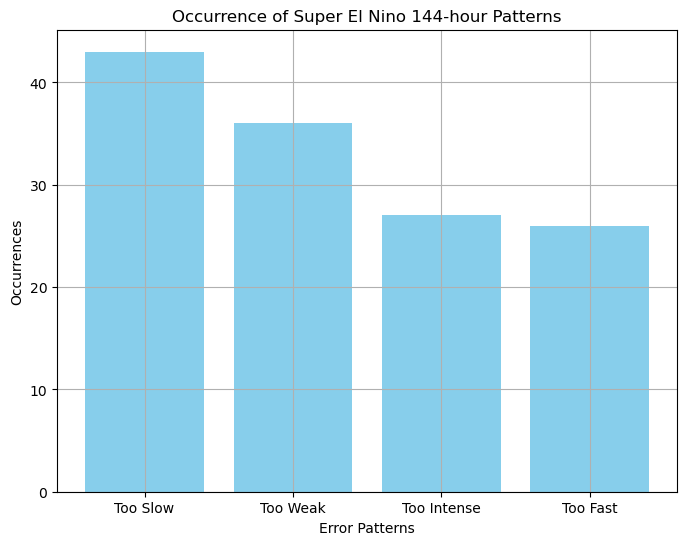

In [141]:
# Define the variables
too_slow = occurrences_counter[2, 2] + occurrences_counter[2, 3] + occurrences_counter[3, 2] + occurrences_counter[3, 3]
too_weak = occurrences_counter[0, 2] + occurrences_counter[1, 2] + occurrences_counter[0, 3] + occurrences_counter[1, 3]
too_int = occurrences_counter[2, 0] + occurrences_counter[2, 1] + occurrences_counter[3, 0] + occurrences_counter[3, 1]

too_fast = occurrences_counter[0, 0] + occurrences_counter[0, 1] + occurrences_counter[1, 0] + occurrences_counter[1, 1]

# Create a bar plot
categories = ['Too Slow', 'Too Weak', 'Too Intense', 'Too Fast']
values = [too_slow, too_weak, too_int, too_fast]

plt.figure(figsize=(8, 6))
plt.grid()
plt.bar(categories, values, color='skyblue')
plt.xlabel('Error Patterns')
plt.ylabel('Occurrences')
plt.title('Occurrence of Super El Nino 144-hour Patterns')
plt.show()

In [142]:
oni_new.loc[38]

Year    1988.0
12         0.8
01         0.5
02         0.1
03        -0.3
04        -0.8
05        -1.2
06        -1.2
07        -1.1
08        -1.2
09        -1.4
10        -1.7
11        -1.8
Name: 38, dtype: float64

In [143]:
di_dates

{(0,
  0): <xarray.DataArray 'time' (time: 77)>
 array(['1988-01-21T00:00:00.000000000', '1988-12-07T00:00:00.000000000',
        '1989-01-24T00:00:00.000000000', '1989-12-25T00:00:00.000000000',
        '1989-12-29T00:00:00.000000000', '1990-01-31T00:00:00.000000000',
        '1990-02-04T00:00:00.000000000', '1990-03-21T00:00:00.000000000',
        '1990-12-07T00:00:00.000000000', '1991-12-08T00:00:00.000000000',
        '1991-12-21T00:00:00.000000000', '1992-01-24T00:00:00.000000000',
        '1992-01-29T00:00:00.000000000', '1992-12-13T00:00:00.000000000',
        '1993-01-29T00:00:00.000000000', '1993-01-31T00:00:00.000000000',
        '1993-02-04T00:00:00.000000000', '1994-12-20T00:00:00.000000000',
        '1995-01-16T00:00:00.000000000', '1995-02-06T00:00:00.000000000',
        '1995-02-07T00:00:00.000000000', '1995-12-31T00:00:00.000000000',
        '1996-02-11T00:00:00.000000000', '1996-02-12T00:00:00.000000000',
        '1996-02-27T00:00:00.000000000', '1997-02-22T00:00:00.00

In [146]:
norm_total_counts

array([0.2343934 , 0.42167256, 0.34393404])

In [148]:
enso_counts

array([199, 358, 292])

In [147]:
total_count

849

In [150]:
199/849,358/849,292/849

(0.23439340400471143, 0.4216725559481743, 0.34393404004711425)

In [310]:
di_oni

{(0, 0): [0.5,
  0.8,
  -1.4,
  -1.6,
  -1.6,
  0.2,
  0.2,
  0.2,
  0.1,
  0.4,
  0.4,
  1.5,
  1.5,
  1.6,
  0.3,
  0.3,
  0.5,
  0.1,
  0.7,
  0.5,
  0.5,
  0.9,
  -0.6,
  -0.6,
  -0.6,
  -0.2,
  0.1,
  1.4,
  -1.0,
  -0.9,
  -0.5,
  -0.7,
  0.0,
  0.1,
  0.2,
  -0.2,
  0.7,
  0.7,
  0.7,
  0.7,
  0.0,
  0.3,
  0.2,
  0.5,
  0.7,
  -0.6,
  -0.6,
  -0.4,
  -0.7,
  0.4,
  0.4,
  0.1,
  -0.1,
  -1.3,
  -1.1,
  -0.9,
  -0.9,
  -1.4,
  -0.6,
  -0.7,
  0.9,
  0.5,
  1.3,
  1.3,
  -1.3,
  -0.4,
  -0.5,
  0.5,
  0.7,
  0.6,
  0.6,
  2.0,
  2.0,
  2.0,
  -0.1,
  -0.1,
  0.2],
 (0, 1): [-0.9,
  1.2,
  1.2,
  0.5,
  0.5,
  0.8,
  -1.4,
  -1.4,
  0.2,
  0.2,
  0.3,
  0.2,
  1.4,
  1.2,
  0.5,
  0.2,
  0.1,
  0.3,
  0.1,
  0.7,
  0.5,
  0.9,
  0.9,
  -1.0,
  -1.1,
  -1.1,
  -0.4,
  0.0,
  0.1,
  0.2,
  0.2,
  0.9,
  0.2,
  0.2,
  -0.6,
  -0.6,
  -0.4,
  -0.2,
  0.4,
  0.7,
  -0.7,
  1.2,
  1.3,
  -1.3,
  -0.7,
  -0.3,
  -0.4,
  -0.4,
  0.5,
  0.6,
  0.7,
  0.6,
  2.0,
  1.6,
  2.2,
  -0.1,
  0.2

Area under the histogram: 1.5783274440518258


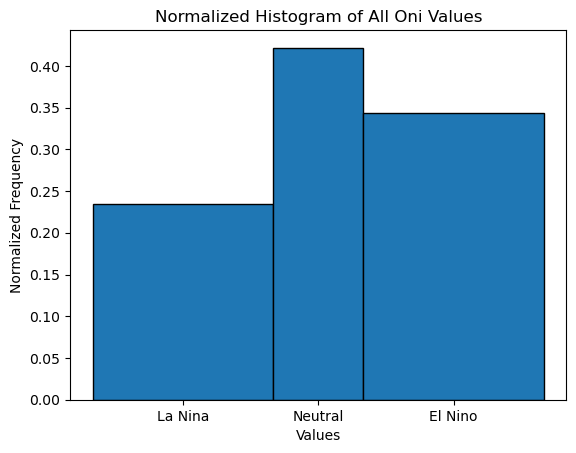

In [301]:


# Sample data (replace this with your actual data)
all_values = [value for values_list in di_oni.values() for value in values_list]

# Adjust the number of bins to match the desired x-axis labels
bins = [-2.5, -0.5, 0.5, 2.5]
labels = ['La Nina', 'Neutral', 'El Nino']

# Calculate the positions of the labels
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
label_positions = bin_centers 

# Place the labels at the calculated positions
plt.xticks(label_positions, labels)

# Create the histogram without density=True
enso_counts,_= np.histogram(all_values, bins=bins)

# Calculate the total count
total_count = np.sum(enso_counts) #* np.diff(bins)

# Normalize the total counts and create the histogram
norm_total_counts = enso_counts / total_count

# Plot the normalized total counts
plt.bar(bin_centers, norm_total_counts, width=np.diff(bins), align='center', edgecolor='black')
area_under_histogram = np.sum(norm_total_counts * np.diff(bins))
print("Area under the histogram:", area_under_histogram)

# Set labels and title
plt.xlabel('Values')
plt.ylabel('Normalized Frequency')
plt.title('Normalized Histogram of All Oni Values')

# Display the histogram
plt.show()


In [305]:
enso_counts

array([199, 358, 292])

# Di four code

In [271]:
di_four = {(0,0): {'(0, 0)': [], '(0, 1)': [], '(1, 0)': [], '(1, 1)': []},\
           (0,1):{'(0,2)': [], '(1,2)': [], '(0,3)': [], '(1,3)': []}\
           , (1,0):{'(2,0)': [], '(2,1)': [], '(3,0)': [], '(3,1)': []},\
           (1,1):{'(2,2)': [], '(2,3)': [], '(3,2)': [], '(3,3)': []}}
for map_num in range(len(som_keys)):
    print(map_num)
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 0):
        di_four[0,0]['(0, 0)'].extend(di_oni[0, 0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 1):
        di_four[0,0]['(0, 1)'].extend(di_oni[0, 1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 0):
        di_four[0,0]['(1, 0)'].extend(di_oni[1,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 1):
        di_four[0,0]['(1, 1)'].extend(di_oni[1,1])
        
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 2):
        di_four[0,1]['(0,2)'].extend(di_oni[0,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 2):
        di_four[0,1]['(1,2)'].extend(di_oni[1,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 3):
        di_four[0,1]['(0,3)'].extend(di_oni[0,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 3):
        di_four[0,1]['(1,3)'].extend(di_oni[1,3])
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 0):
        di_four[1,0]['(2,0)'].extend(di_oni[2,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 1):
        di_four[1,0]['(2,1)'].extend(di_oni[2,1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 0):
        di_four[1,0]['(3,0)'].extend(di_oni[3,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 1):
        di_four[1,0]['(3,1)'].extend(di_oni[3,1])
        
    if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 2):
        di_four[1,1]['(2,2)'].extend(di_oni[2,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 3):
        di_four[1,1]['(2,3)'].extend(di_oni[2,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 2):
        di_four[1,1]['(3,2)'].extend(di_oni[3,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 3):
        di_four[1,1]['(3,3)'].extend(di_oni[3,3])
        
        


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [272]:
oni_new[oni_new['Year']==2017]

,Year,12,01,02,03,04,05,06,07,08,09,10,11
67,2017,-0.4,-0.1,0.2,0.4,0.4,0.2,-0.1,-0.5,NaN,NaN,NaN,NaN


In [273]:
len(all_values_for_i)

188

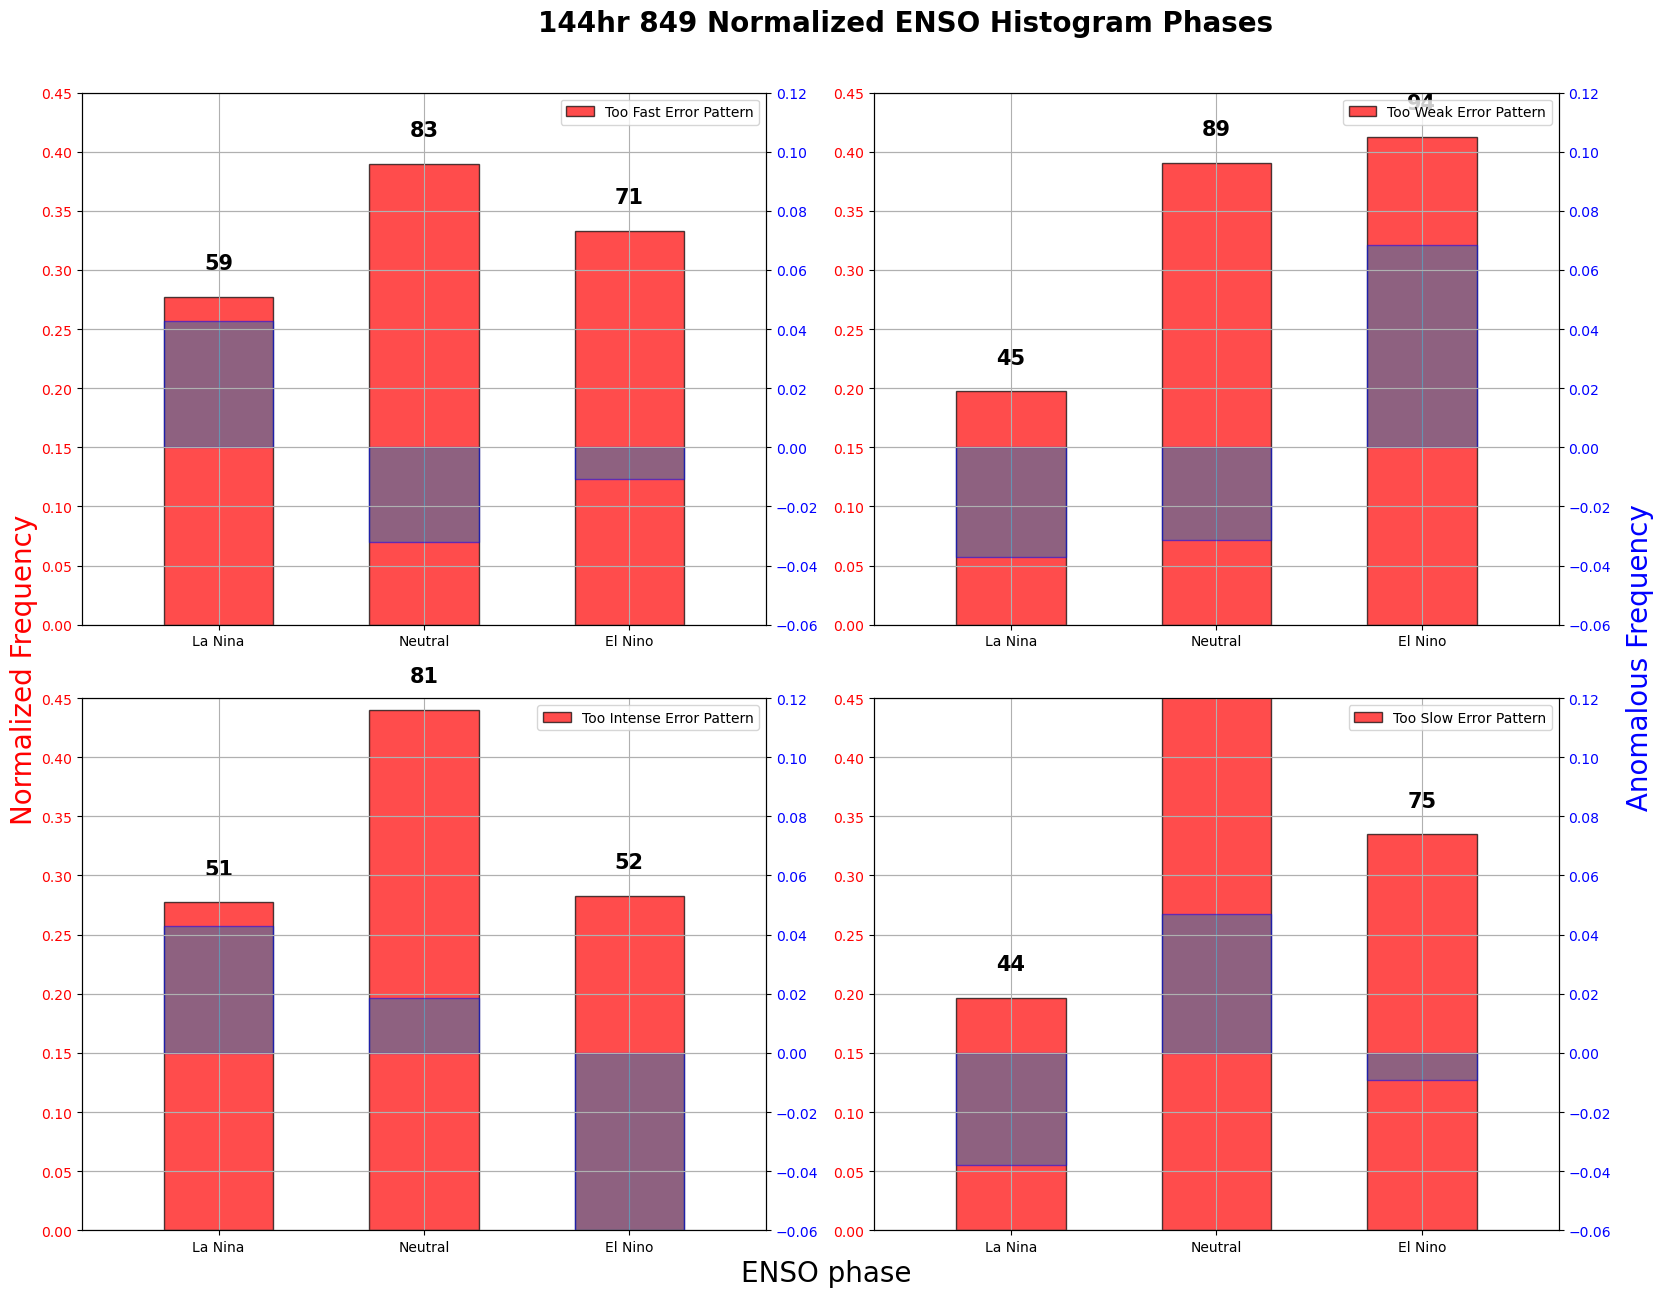

In [274]:
import matplotlib.pyplot as plt
import numpy as np

fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
enso_counts_dict = {}
enso_hist_dict = {}  # Add this dictionary to store histogram data

label_list = ['Too Fast', 'Too Weak', 'Too Intense', 'Too Slow']
for map_num, (i, ax) in enumerate(zip(di_four.keys(), geo_axs.flatten())):
    key_i_values = di_four[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = [-2.5, -0.5, 0.5, 2.5]
    labels = ['La Nina', 'Neutral', 'El Nino']

    bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    enso_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    enso_counts_dict[i] = enso_counts_total

    enso_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = enso_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    enso_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
    twin_ax = ax.twinx()
    twin_ax.bar(bin_centers, normalized_hist-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

#     twin_ax.set_ylim([-.12, 0.10])
    twin_ax.tick_params(axis='y', labelcolor='blue')
    
    ax.set_xlim([min(bin_centers) - 1, max(bin_centers) + 1])
    twin_ax.set_xlim([min(bin_centers) - 1, max(bin_centers) + 1])
    
#     ax.set_yticks(np.linspace(0, 0.4, 4))  # Set desired y-tick values
#     twin_ax.set_yticks(np.arange(-.12, 0.10,.050))  # Set desired y-tick values
    
#     ax.yaxis.set_major_locator(plt.MaxNLocator(5))
#     twin_ax.yaxis.set_major_locator(plt.MaxNLocator(5))

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} Error Pattern'.format(label_list[map_num]))

    # Add annotations for raw counts
    for x, y in zip(bin_centers, enso_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 20), ha='center', fontsize=15, fontweight='bold', color='black')

    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='y', labelcolor='red')
    twin_ax.set_ylim([-.06, 0.12])
    ax.set_ylim([0,0.45])
    twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
    twin_ax.grid(None)

    
#     ax.set_yticks(np.arange(0, 0.5, 0.1))  # Set desired y-tick values
#     twin_ax.set_yticks(np.arange(-0.05, 0.10, 0.05))  # Set desired y-tick values
    

    ax.legend()
    #yrange=np.linspace(0,0.45,10)
#     ax.set_ylim([0,0.45])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'ENSO phase', ha='center', fontsize=20)
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(1, .38, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Normalized ENSO Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=20, y=1.05, x=0.55, fontweight='bold'
)

plt.show()


In [275]:
enso_counts_dict

{(0, 0): array([59, 83, 71]),
 (0, 1): array([45, 89, 94]),
 (1, 0): array([51, 81, 52]),
 (1, 1): array([ 44, 105,  75])}

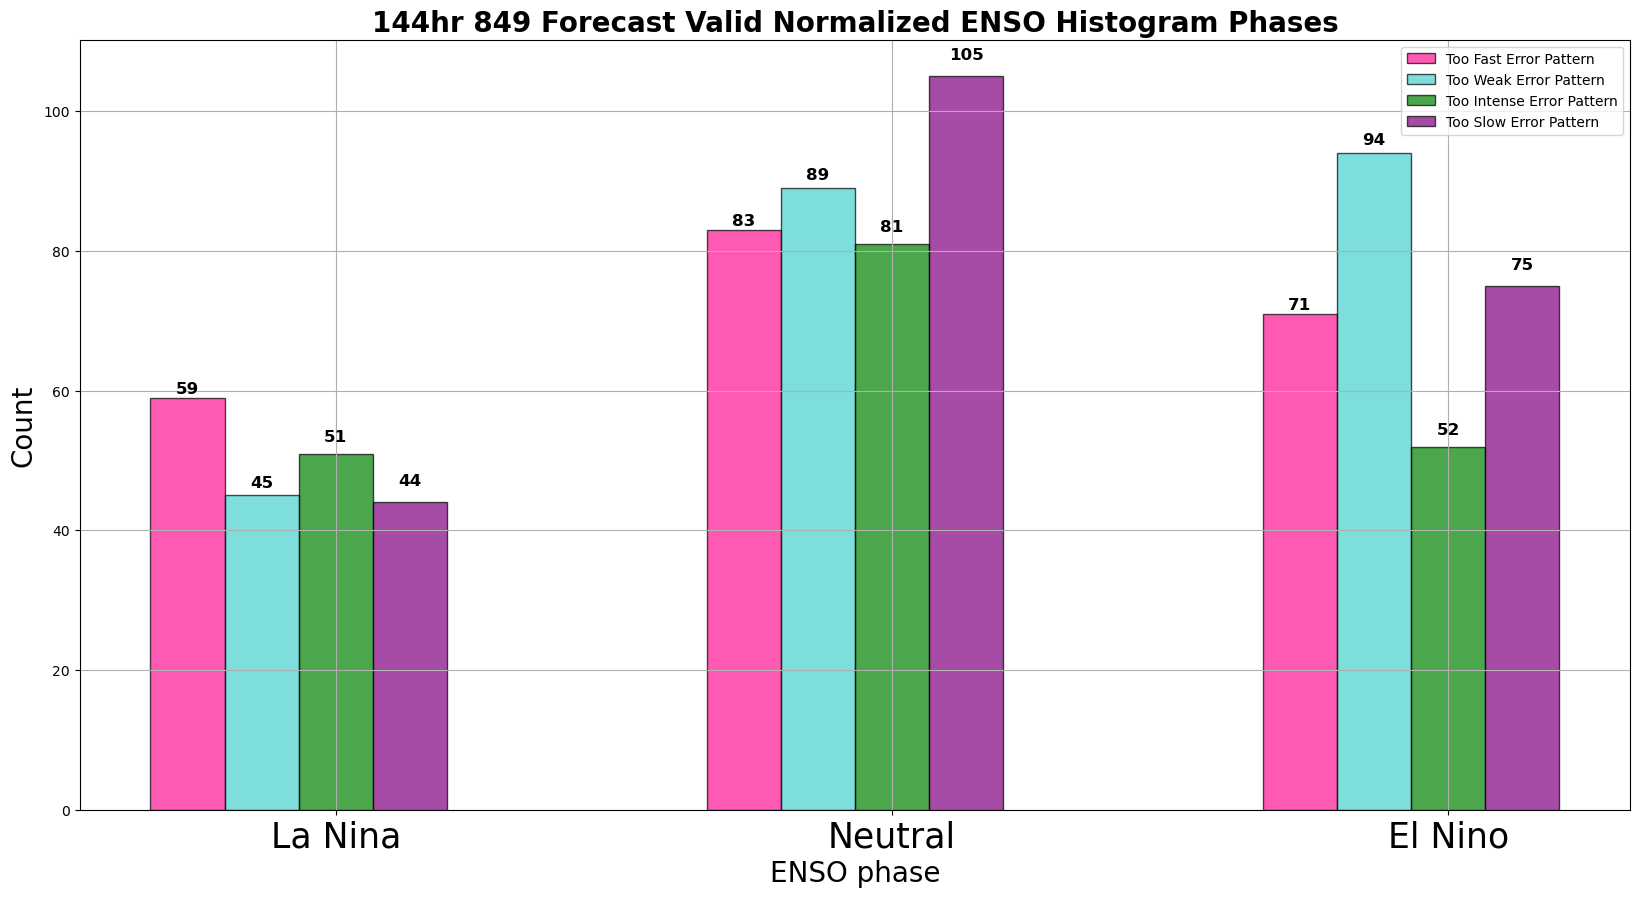

In [276]:
fig, axs = plt.subplots(figsize=(20, 10))

enso_counts_dict = {}
enso_hist_dict = {}

label_list = ['Too Fast', 'Too Weak', 'Too Intense', 'Too Slow']
quadrant_colors = ['deeppink', 'mediumturquoise', 'green', 'purple']

bar_width = 0.2  # Set the width of each bar

for map_num, (i, color) in enumerate(zip(di_four.keys(), quadrant_colors)):
    key_i_values = di_four[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    bins = [-2.5, -0.5, 0.5, 2.5]
    labels = ['La Nina', 'Neutral', 'El Nino']

    bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    enso_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    enso_counts_dict[i] = enso_counts_total

    enso_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,  # Normalize to get a probability density
    )

    bin_widths = np.diff(bins)
    normalized_hist = enso_counts_total / len(all_values_for_i)

    # Calculate the x-positions for the bars
    x_positions = bin_centers - bar_width * (len(quadrant_colors) / 2) + bar_width * map_num

    # Plot the bars with adjusted x-positions
    axs.bar(x_positions, enso_counts_total, width=bar_width, align='center', color=color, edgecolor='black', alpha=0.7, label='{} Error Pattern'.format(label_list[map_num]))

    enso_hist_dict[i] = normalized_hist

    # Add annotations for enso_counts_total with adjusted xytext
    for x, y in zip(x_positions, enso_counts_total):
        xytext_y = 3 + 3 * map_num
        axs.annotate(f"{y}", (x, y), textcoords="offset points", xytext=(0, xytext_y), ha='center', fontsize=12, fontweight='bold', color='black')

# Use the bin centers as x-ticks and set the labels
axs.set_xticks(bin_centers)
axs.set_xticklabels(labels, fontsize=25)
axs.tick_params(axis='y', labelcolor='black')  # Change the y-axis label color

axs.grid(zorder=0)

# axs.set_ylim([0, 1])
axs.set_xlabel('ENSO phase', fontsize=20)
axs.set_ylabel('Count', rotation='vertical', color='black', fontsize=20)  # Change the y-axis label color
axs.set_title("144hr 849 Forecast Valid Normalized ENSO Histogram Phases", fontsize=20, fontweight='bold')

plt.legend()
plt.show()

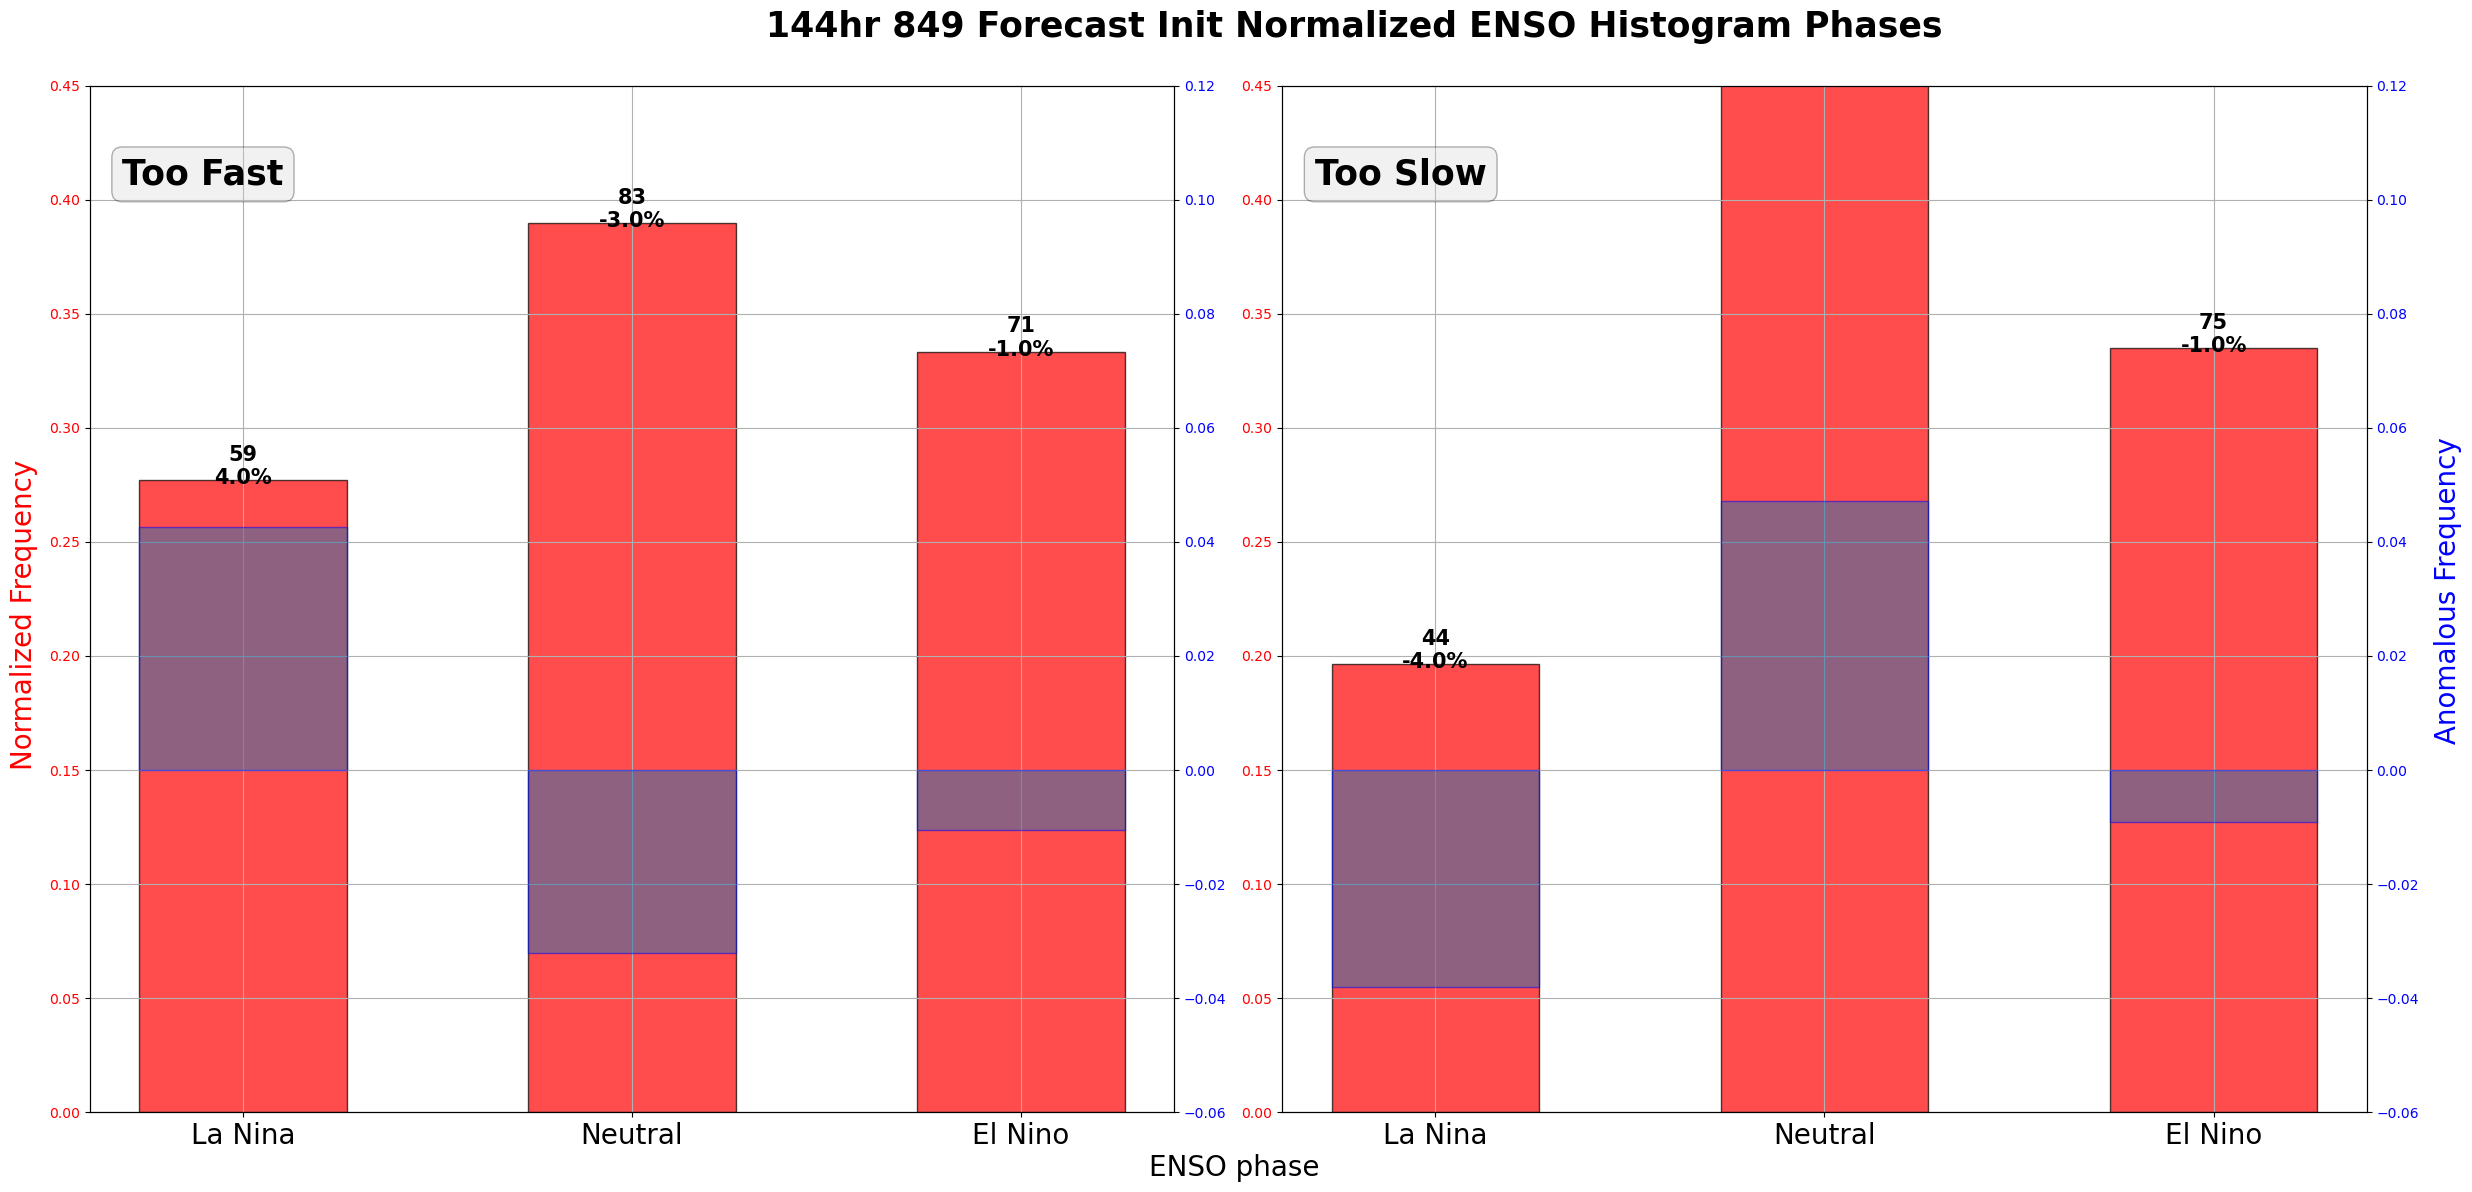

In [277]:
import matplotlib.pyplot as plt
import numpy as np

fig, geo_axs = plt.subplots(1, 2, figsize=(24, 11))
# enso_counts_dict = {}
enso_hist_dict = {}  # Add this dictionary to store histogram data
keys_to_plot = [(0, 0), (1, 1)] 
labels_list = [[label_list[0]], [label_list[1]]]

label_list = ['Too Fast', 'Too Slow']
for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    key_i_values = di_four[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = [-2.5, -0.5, 0.5, 2.5]
    labels = ['La Nina', 'Neutral', 'El Nino']

    bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    enso_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
#     enso_counts_dict[i] = enso_counts_total

    enso_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = enso_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    enso_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
    twin_ax = ax.twinx()
    twin_ax.bar(bin_centers, normalized_hist-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

#     twin_ax.set_ylim([-0.05, 0.20])
    twin_ax.tick_params(axis='y', labelcolor='blue')
    twin_ax.set_ylim([-0.06, 0.12])
    ax.set_ylim([0, 0.45])
    twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

#     geo_axs[1,1].bar(bin_centers, pna_hist_dict[1,1]-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5,color='lightblue')
#     geo_axs[1,0].bar(bin_centers, pna_hist_dict[1,0]-pna_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, color='lightblue')
#     geo_axs[1,1].grid(zorder=0)
#     geo_axs[1,0].grid(zorder=0)
    
#     geo_axs[1,1].set_ylim([-0.06,0.04])
#     geo_axs[1,0].set_ylim([-0.06,0.04])
#     geo_axs[1,1].tick_params(axis='y', labelcolor='blue')
#     geo_axs[1,0].tick_params(axis='y', labelcolor='blue')
    
    


    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7)

    # Add annotations for raw counts
    for x, y in zip(bin_centers, enso_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 14), ha='center', fontsize=15, fontweight='bold', color='black')
    for x, y in zip(bin_centers,  np.round(normalized_hist-norm_total_counts,2)*100):
        ax.annotate(f"{y}%", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, -3), ha='center', fontsize=15, fontweight='bold', color='black')


    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels,fontsize=20)
    ax.tick_params(axis='y', labelcolor='red')
  
    

#     ax.legend()
#     ax.set_ylim([0, 0.45])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'ENSO phase', ha='center', fontsize=20)
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(1, .38, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Forecast Init Normalized ENSO Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=25, y=1.05, x=0.55, fontweight='bold'
)

plt.show()


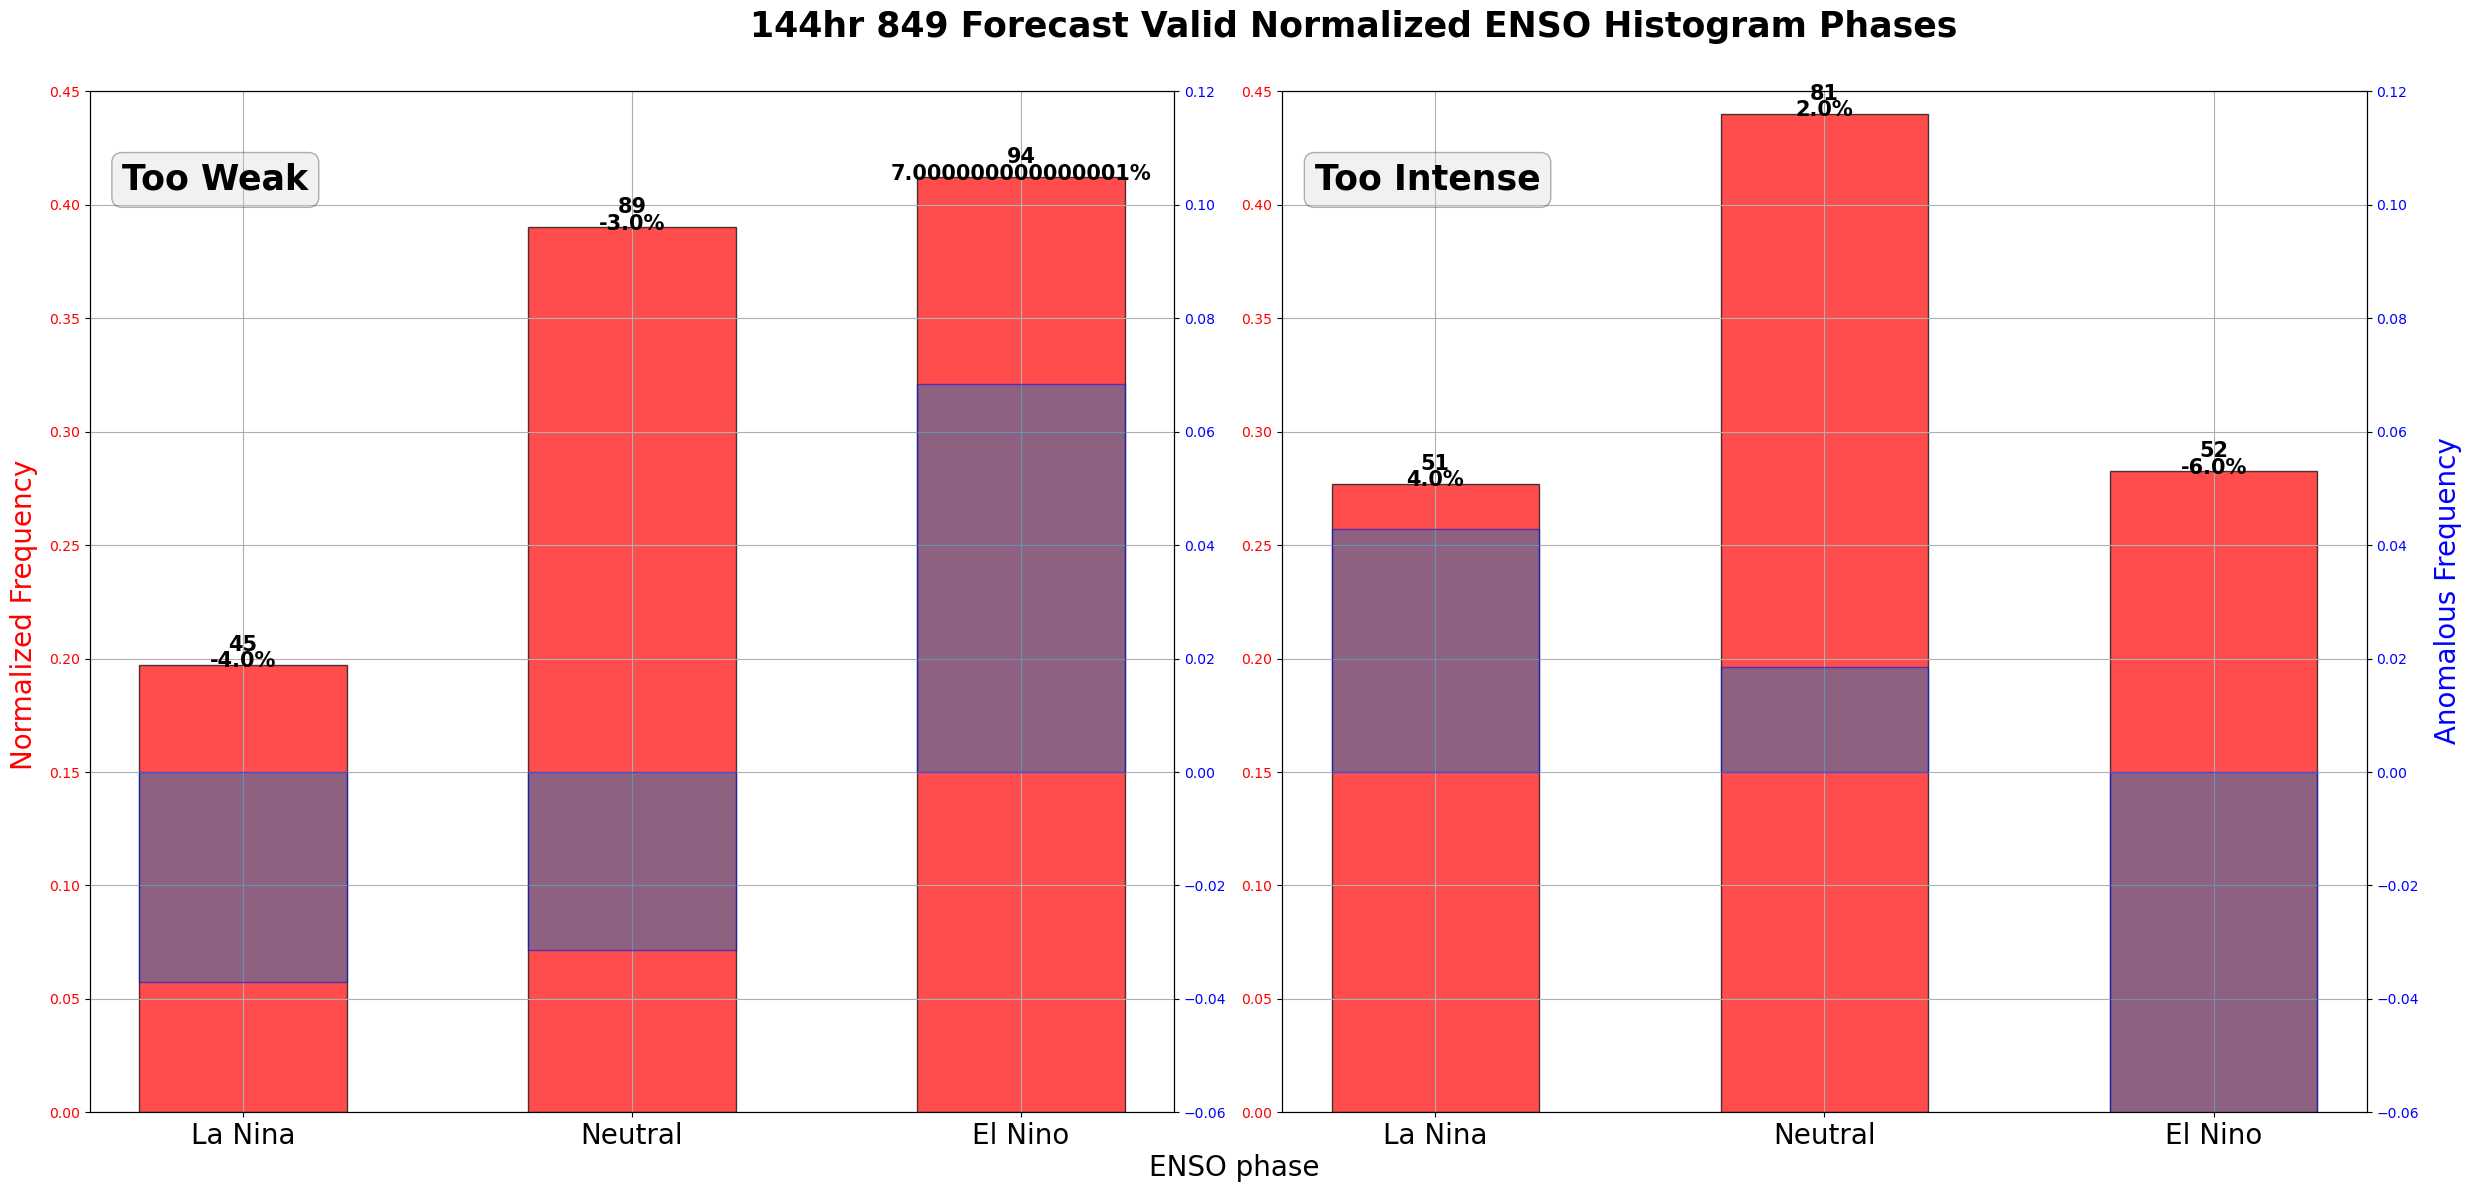

In [278]:
import matplotlib.pyplot as plt
import numpy as np

fig, geo_axs = plt.subplots(1, 2, figsize=(24, 11))
enso_counts_dict = {}
# enso_hist_dict = {}  # Add this dictionary to store histogram data
keys_to_plot = [(0, 1), (1, 0)] 

label_list = ['Too Weak', 'Too Intense']
for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    key_i_values = di_four[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = [-2.5, -0.5, 0.5, 2.5]
    labels = ['La Nina', 'Neutral', 'El Nino']

    bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    enso_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    enso_counts_dict[i] = enso_counts_total

    enso_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = enso_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    enso_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
    twin_ax = ax.twinx()
    twin_ax.bar(bin_centers, normalized_hist-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

    twin_ax.set_ylim([-0.06, 0.12])
    ax.set_ylim([0, 0.45])
    twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))


    twin_ax.tick_params(axis='y', labelcolor='blue')

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7)

    # Add annotations for raw counts
    for x, y in zip(bin_centers, enso_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=15, fontweight='bold', color='black')
    for x, y in zip(bin_centers,  np.round(normalized_hist-norm_total_counts,2)*100):
        ax.annotate(f"{y}%", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, -2), ha='center', fontsize=15, fontweight='bold', color='black')


    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels,fontsize=20)
    ax.tick_params(axis='y', labelcolor='red')
    
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

#     ax.legend()

    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'ENSO phase', ha='center', fontsize=20)
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(1, .38, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Forecast Valid Normalized ENSO Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=25, y=1.05, x=0.55, fontweight='bold'
)

plt.show()


In [312]:
36/180

0.2

In [313]:
norm_total_counts

array([0.2343934 , 0.42167256, 0.34393404])

In [314]:
(.2-.23)/(.23)

-0.13043478260869565

[0.2343934  0.42167256 0.34393404]
[0.2343934  0.42167256 0.34393404]


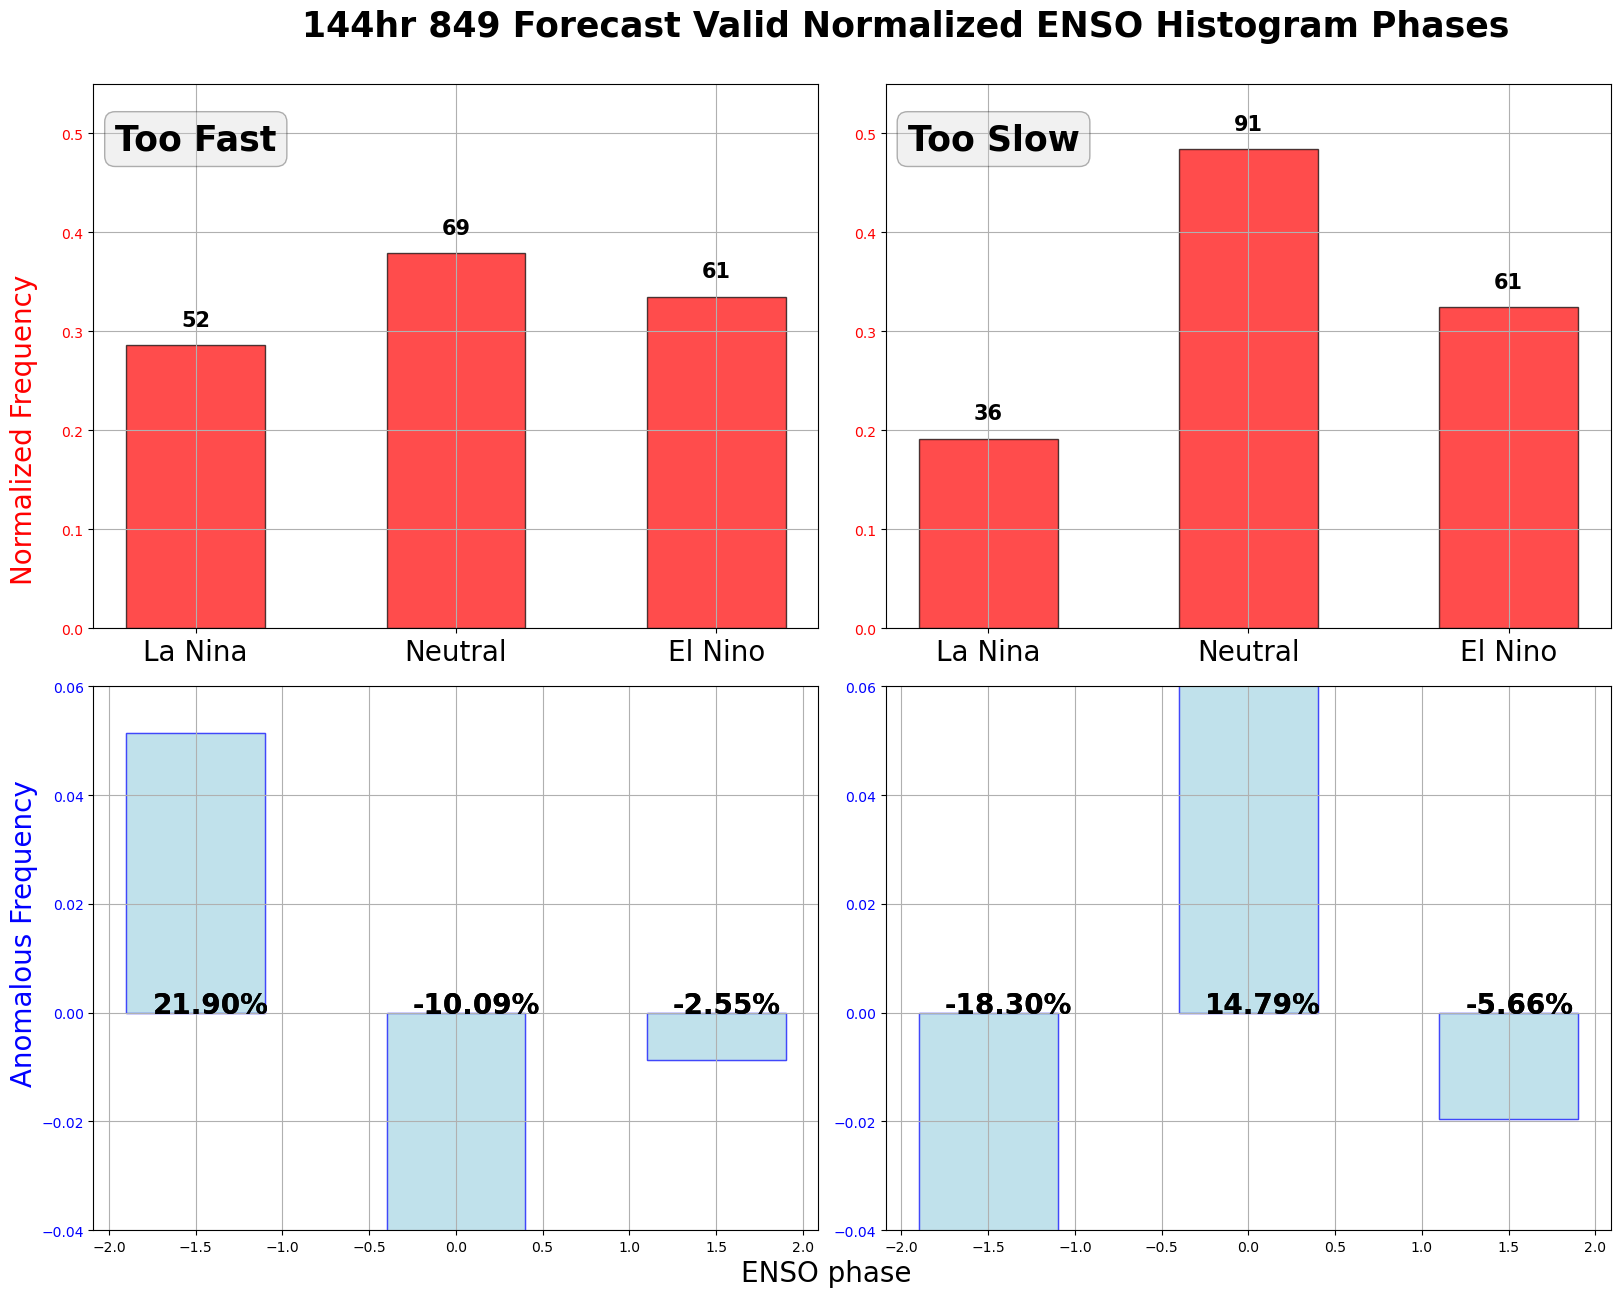

In [308]:
import matplotlib.pyplot as plt
import numpy as np

fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
# enso_counts_dict = {}
#enso_hist_dict = {}  # Add this dictionary to store histogram data
keys_to_plot = [(0, 0), (1, 1)] 
labels_list = [[label_list[0]], [label_list[1]]]

bins = [-2.5, -0.5, 0.5, 2.5]
labels = ['La Nina', 'Neutral', 'El Nino']

bin_centers = 0.5 * np.diff(bins) + bins[:-1]

label_list = ['Too Fast', 'Too Slow']
for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    print(norm_total_counts)
    key_i_values = di_four[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
   

    # Compute the raw counts for each bin
    enso_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    enso_counts_dict[i] = enso_counts_total

    enso_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = enso_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    enso_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
#     twin_ax = ax.twinx()
#     twin_ax.bar(bin_centers, normalized_hist-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

#     twin_ax.set_ylim([-0.05, 0.20])
#     twin_ax.tick_params(axis='y', labelcolor='blue')
#     twin_ax.set_ylim([-0.06, 0.12])
#     ax.set_ylim([0, 0.45])
#     twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

    geo_axs[1,0].bar(bin_centers, enso_hist_dict[0,0]-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5,color='lightblue')
    geo_axs[1,1].bar(bin_centers, enso_hist_dict[1,1]-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, color='lightblue')
    geo_axs[1,1].grid(zorder=0)
    geo_axs[1,0].grid(zorder=0)
    
    geo_axs[1,1].set_ylim([-0.04,0.06])
    geo_axs[1,0].set_ylim([-0.04,0.06])
    geo_axs[1,1].tick_params(axis='y', labelcolor='blue')
    geo_axs[1,0].tick_params(axis='y', labelcolor='blue')
    

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7)

    # Add annotations for raw counts
    for x, y in zip(bin_centers, enso_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 14), ha='center', fontsize=15, fontweight='bold', color='black')
    
    for x, y in zip(bin_centers, ((enso_hist_dict[0,0]-norm_total_counts)/(norm_total_counts))*100):
        
        geo_axs[1, 0].text(x-.25, 0, f"{y:.2f}%", fontsize=20, fontweight='bold', color='black')
        
    for x, y in zip(bin_centers, ((enso_hist_dict[1,1]-norm_total_counts)/(norm_total_counts))*100):
        
        geo_axs[1, 1].text(x-.25, 0, f"{y:.2f}%", fontsize=20, fontweight='bold', color='black')
#     for x, y in zip(bin_centers,  np.round(normalized_hist-norm_total_counts,2)*100):
#         ax.annotate(f"{y}%", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, -3), ha='center', fontsize=15, fontweight='bold', color='black')


    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels,fontsize=20)
    ax.tick_params(axis='y', labelcolor='red')
    ax.set_ylim([0,0.55])
  
    

#     ax.legend()
#     ax.set_ylim([0, 0.45])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'ENSO phase', ha='center', fontsize=20)
fig.text(-0.01, 0.7, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(-0.01, .15, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Forecast Valid Normalized ENSO Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=25, y=1.05, x=0.55, fontweight='bold'
)

plt.show()



In [309]:
norm_total_counts

array([0.2343934 , 0.42167256, 0.34393404])

In [307]:
normalized_hist

array([0.28873239, 0.44366197, 0.26760563])

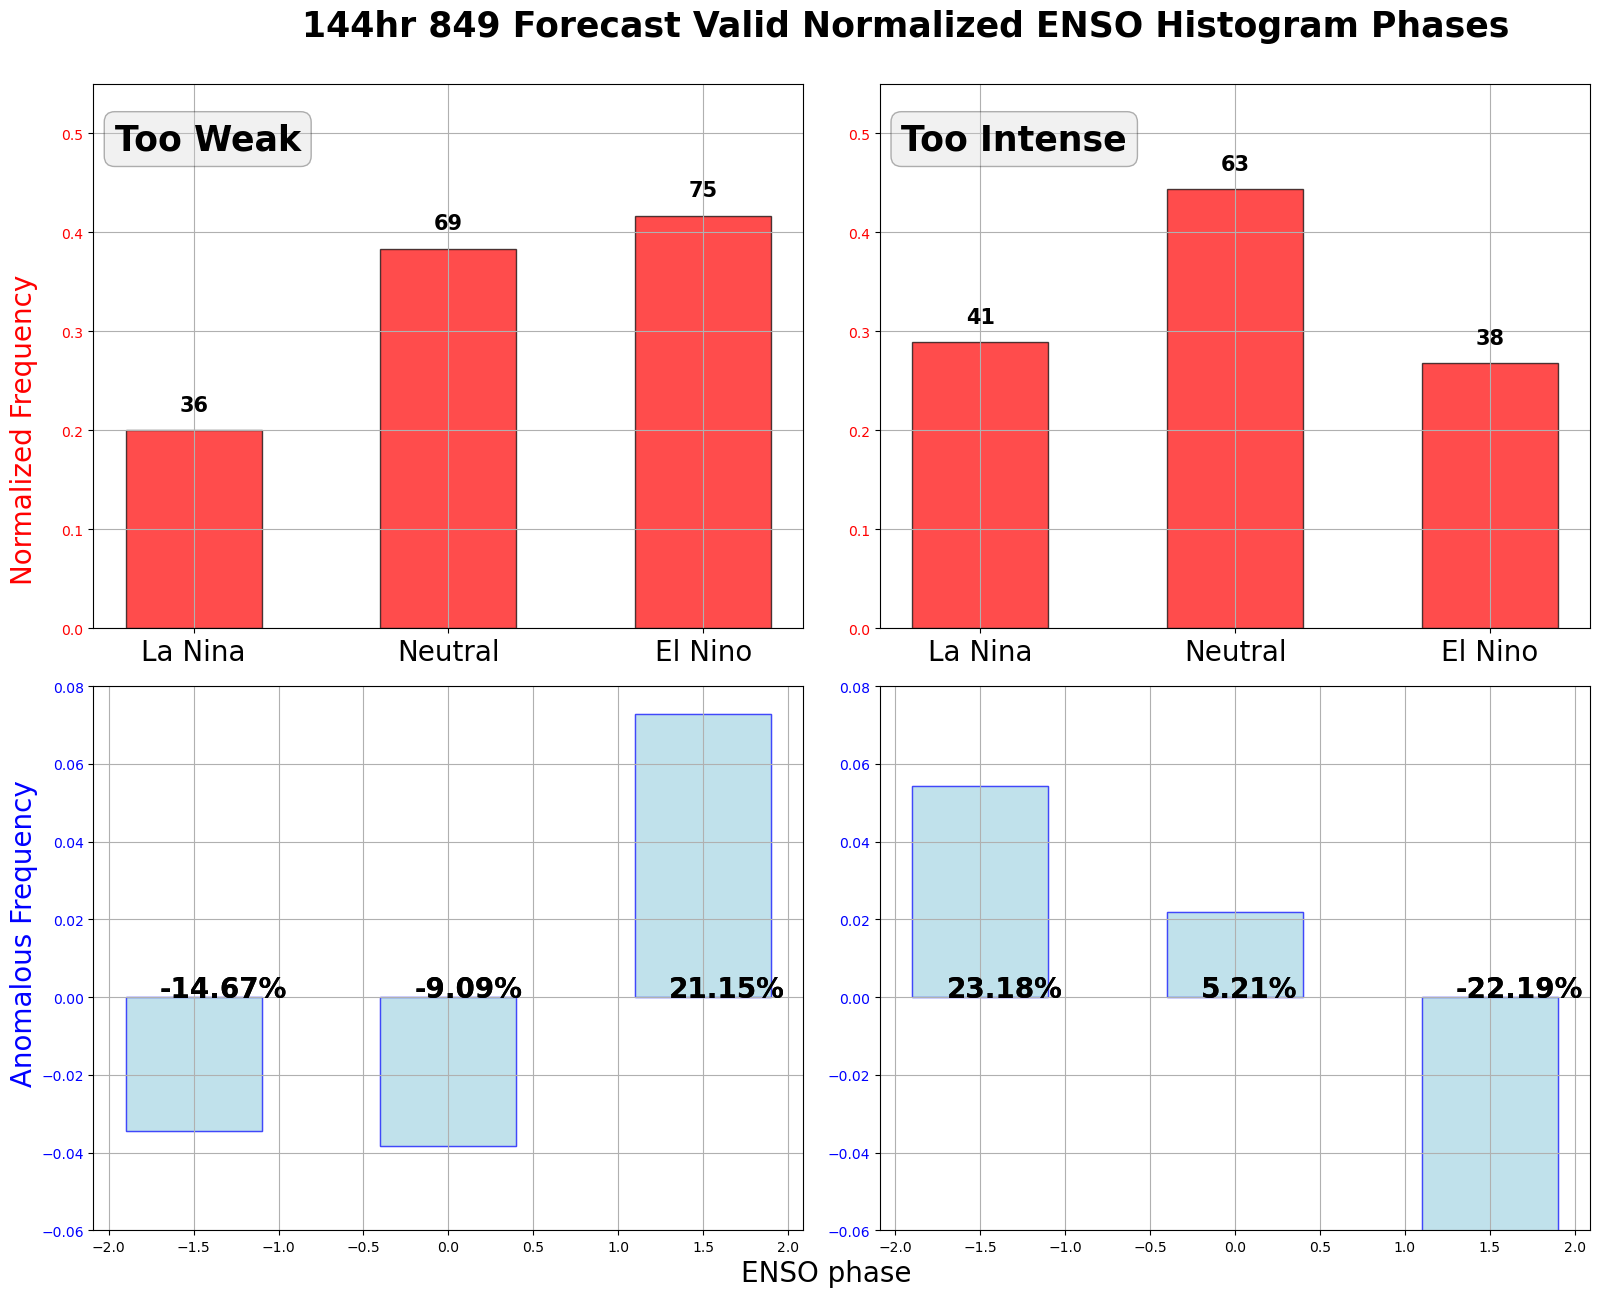

In [173]:
import matplotlib.pyplot as plt
import numpy as np

fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
# enso_counts_dict = {}
# enso_hist_dict = {}  # Add this dictionary to store histogram data
keys_to_plot = [(0, 1), (1, 0)] 
labels_list = [[label_list[0]], [label_list[1]]]

label_list = ['Too Weak', 'Too Intense']
for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    key_i_values = di_four[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = [-2.5, -0.5, 0.5, 2.5]
    labels = ['La Nina', 'Neutral', 'El Nino']

    bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    enso_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
#     enso_counts_dict[i] = enso_counts_total

    enso_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = enso_counts_total / len(all_values_for_i)  # Normalize by the total count
    
#     enso_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
#     twin_ax = ax.twinx()
#     twin_ax.bar(bin_centers, normalized_hist-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

#     twin_ax.set_ylim([-0.05, 0.20])
#     twin_ax.tick_params(axis='y', labelcolor='blue')
#     twin_ax.set_ylim([-0.06, 0.12])
#     ax.set_ylim([0, 0.45])
#     twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

    geo_axs[1,0].bar(bin_centers, enso_hist_dict[0,1]-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5,color='lightblue')
    geo_axs[1,1].bar(bin_centers, enso_hist_dict[1,0]-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, color='lightblue')
    geo_axs[1,0].grid(zorder=0)
    geo_axs[1,1].grid(zorder=0)
    
    geo_axs[1,0].set_ylim([-0.06,0.08])
    geo_axs[1,1].set_ylim([-0.06,0.08])
    geo_axs[1,0].tick_params(axis='y', labelcolor='blue')
    geo_axs[1,1].tick_params(axis='y', labelcolor='blue')
    

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7)

    # Add annotations for raw counts
    for x, y in zip(bin_centers, enso_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 14), ha='center', fontsize=15, fontweight='bold', color='black')
    
    for x, y in zip(bin_centers, ((enso_hist_dict[0,1]-norm_total_counts)/(norm_total_counts))*100):
        
        geo_axs[1, 0].text(x-.2, 0, f"{y:.2f}%", fontsize=20, fontweight='bold', color='black')
        
    for x, y in zip(bin_centers, ((enso_hist_dict[1,0]-norm_total_counts)/(norm_total_counts))*100):
        
        geo_axs[1, 1].text(x-.2, 0, f"{y:.2f}%", fontsize=20, fontweight='bold', color='black')
        
#     for x, y in zip(bin_centers,  np.round(normalized_hist-norm_total_counts,2)*100):
#         ax.annotate(f"{y}%", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, -3), ha='center', fontsize=15, fontweight='bold', color='black')


    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels,fontsize=20)
    ax.tick_params(axis='y', labelcolor='red')
  
    

#     ax.legend()
#     ax.set_ylim([0, 0.45])
    ax.grid(zorder=0)
    ax.set_ylim([0,0.55])

plt.tight_layout()
fig.text(0.5, -0.01, 'ENSO phase', ha='center', fontsize=20)
# fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
# fig.text(1, .38, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.text(-0.01, 0.7, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(-0.01, .15, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Forecast Valid Normalized ENSO Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=25, y=1.05, x=0.55, fontweight='bold'
)

plt.show()


Area under the histogram: 1.5783274440518258


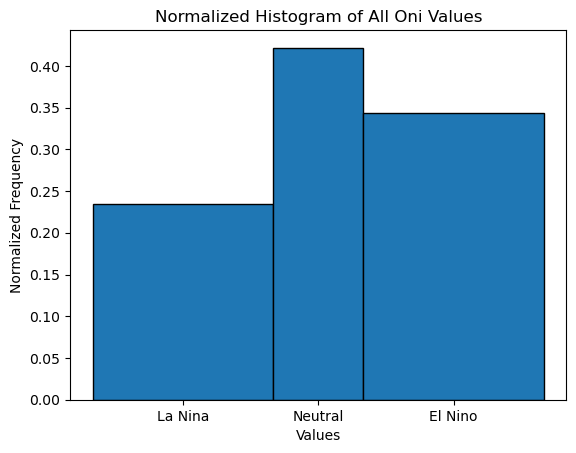

In [208]:


# Sample data (replace this with your actual data)
all_values = [value for values_list in di_oni.values() for value in values_list]

# Adjust the number of bins to match the desired x-axis labels
bins = [-2.5, -0.5, 0.5, 2.5]
labels = ['La Nina', 'Neutral', 'El Nino']

# Calculate the positions of the labels
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
label_positions = bin_centers 

# Place the labels at the calculated positions
plt.xticks(label_positions, labels)

# Create the histogram without density=True
enso_counts,_= np.histogram(all_values, bins=bins)

# Calculate the total count
total_count = np.sum(enso_counts) #* np.diff(bins)

# Normalize the total counts and create the histogram
norm_total_counts = enso_counts / total_count

# Plot the normalized total counts
plt.bar(bin_centers, norm_total_counts, width=np.diff(bins), align='center', edgecolor='black')
area_under_histogram = np.sum(norm_total_counts * np.diff(bins))
print("Area under the histogram:", area_under_histogram)

# Set labels and title
plt.xlabel('Values')
plt.ylabel('Normalized Frequency')
plt.title('Normalized Histogram of All Oni Values')

# Display the histogram
plt.show()


In [242]:
hist_values, bin_edges = np.histogram(all_values, bins=bins, density=True)

# # Normalize the density values to add up to 1
# normalized_values = hist_values / np.sum(hist_values)

# # Create the dictionary density_counts
# density_counts = {'values': normalized_values, 'bin_edges': bin_edges}

In [243]:
norm_hist_values = hist_values *bin_widths

In [244]:
norm_hist_values

array([0.2343934 , 0.42167256, 0.34393404])

In [245]:
norm_total_counts

array([0.2343934 , 0.42167256, 0.34393404])

# Three Corner MJO

In [ ]:
di_mjo_quart = {(0,0): {'(0, 0)': [], '(0, 1)': [], '(1, 0)': [], '(1, 1)': []},\
           (0,1):{'(0,2)': [], '(1,2)': [], '(0,3)': [], '(1,3)': []}\
           , (1,0):{'(2,0)': [], '(2,1)': [], '(3,0)': [], '(3,1)': []},\
           (1,1):{'(2,2)': [], '(2,3)': [], '(3,2)': [], '(3,3)': []}}
for map_num in range(len(som_keys)):
    print(map_num)
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 0):
        di_mjo_quart[0,0]['(0, 0)'].extend(di_mjo[0, 0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 1):
        di_mjo_quart[0,0]['(0, 1)'].extend(di_mjo[0, 1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 0):
        di_mjo_quart[0,0]['(1, 0)'].extend(di_mjo[1,0])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 1):
#         di_mjo_quart[0,0]['(1, 1)'].extend(di_mjo[1,1])
        
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 2):
        di_mjo_quart[0,1]['(0,2)'].extend(di_mjo[0,2])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 2):
#         di_mjo_quart[0,1]['(1,2)'].extend(di_mjo[1,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 3):
        di_mjo_quart[0,1]['(0,3)'].extend(di_mjo[0,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 3):
        di_mjo_quart[0,1]['(1,3)'].extend(di_mjo[1,3])
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 0):
        di_mjo_quart[1,0]['(2,0)'].extend(di_mjo[2,0])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 1):
#         di_mjo_quart[1,0]['(2,1)'].extend(di_mjo[2,1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 0):
        di_mjo_quart[1,0]['(3,0)'].extend(di_mjo[3,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 1):
        di_mjo_quart[1,0]['(3,1)'].extend(di_mjo[3,1])
        
#     if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 2):
#         di_mjo_quart[1,1]['(2,2)'].extend(di_mjo[2,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 3):
        di_mjo_quart[1,1]['(2,3)'].extend(di_mjo[2,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 2):
        di_mjo_quart[1,1]['(3,2)'].extend(di_mjo[3,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 3):
        di_mjo_quart[1,1]['(3,3)'].extend(di_mjo[3,3])
        
        


In [ ]:

di_mjo_quart

In [ ]:
di_mjo[0,0]

In [ ]:
di_mjo_quart_3 = {(0, 0): {'(0, 0)':di_mjo[0, 0] , '(0, 1)': di_mjo[0, 1],'(1, 0)':di_mjo[1, 0]},
                (0,1): {'(0, 2)':di_mjo[0, 2] , '(0, 3)': di_mjo[0, 3],'(1, 3)':di_mjo[1, 3]},
                (1,0): {'(2, 0)':di_mjo[2, 0] , '(3, 0)': di_mjo[3, 0],'(3, 1)':di_mjo[3, 1]} ,
                (1,1): {'(2, 3)':di_mjo[2, 3] , '(3, 2)': di_mjo[3, 2],'(3, 3)':di_mjo[3, 3]}} 

In [ ]:
di_mjo_quart_3

In [ ]:
import matplotlib.pyplot as plt

fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))


for map_num, i in enumerate(di_mjo_quart.keys()):
    key_i_values = di_mjo_quart_3[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    #print(di_four[i].keys(),di_four[i])

    # Adjust the number of bins to match the desired x-axis labels
#     bins = [-2.5, -0.5, 0.5, 2.5]
#     labels = ['La Nina', 'Neutral', 'El Nino']
    
    bins = np.arange(1, 10)

    # Use the bin centers as x-ticks
    x_ticks = bins
    geo_axs[i].set_xticks(x_ticks+0.5)
    geo_axs[i].set_xticklabels(range(1, 10)) 

#     geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_ylabel('Number of ARs w/ MJO phase')
#     geo_axs[som_keys[map_num][0], som_keys[map_num][1]].set_xlabel('MJO Phase')
#     geo_axs[i].set_ylim([0, 0.4])
    geo_axs[i].set_xlim([1,9])
    geo_axs[i].grid(zorder=0)
#     props = dict(boxstyle='round', facecolor='teal', alpha=.9) 

    mjo_hist, bin_edges, _  = geo_axs[i].hist(
        all_values_for_i,
        bins=bins,
        density=True,
        edgecolor='black',
        rwidth=0.8,
        color='red',# Adjust the width of the bars
    )

    # Use the bin centers as x-ticks and set the labels
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    geo_axs[i].set_xticks(bin_centers)

#     geo_axs[i].legend()

    geo_axs[i].set_ylim([0, .25])
    geo_axs[i].grid(zorder=0)


plt.tight_layout()
fig.text(0.5, -0.01, 'MJO phase', ha='center', fontsize=20)
fig.text(-0.01, 0.5, 'Number of ARs', va='center', rotation='vertical', fontsize=20)
fig.suptitle(
    "144hr 849 Normalized MJO Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=20, y=1.05, x=0.45, fontweight='bold'
)

plt.show()


In [ ]:
#180
#180
#159
#194
#194+159+360=713 total MJO

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
mjo_counts_dict={}
mjo_hist_dict={}

label_list=['Too Fast', 'Too Weak', 'Too Intense', 'Too Slow']
for map_num, (i, ax) in enumerate(zip(di_mjo_quart.keys(), geo_axs.flatten())):
    key_i_values = di_mjo_quart[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))

    bins = np.arange(1, 10)
    bin_centers = bins[:-1] #+ 0.5
    
    mjo_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    mjo_counts_dict[i] = mjo_counts_total
    
    mjo_hist = mjo_counts_total / len(all_values_for_i)
    mjo_hist_dict[i]=mjo_hist

    ax.bar(bin_centers, mjo_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} MJO Mode'.format(label_list[map_num]))
    
#     mjo_hist, bin_edges, _ = ax.hist(
#         all_values_for_i,
#         bins=bins,
#         density=True,
#         edgecolor='black',
#         rwidth=0.8,
#         color='red',
#         label='{} MJO Mode'.format(label_list[map_num]),
#     )
    
    mjo_differences = mjo_hist - mjo_counts
    
    # Plot the bar graph for histogram differences
    twin_ax = ax.twinx()
#     twin_ax.set_ylim([-0.045, 0.10])
    twin_ax.set_ylim([-0.06, 0.12])
    ax.set_ylim([0, 0.25])
    twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
    twin_ax.tick_params(axis='y', labelcolor='blue')
    twin_ax.bar(bin_centers, mjo_differences, width=0.8, edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')
    
    for x, y in zip(bin_centers, mjo_counts_dict[i]):
        ax.annotate(f"{y}", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
    
    ax.set_xticks(bin_centers)
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend()
    ax.set_ylim([0, 0.25])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'MJO phase', ha='center', fontsize=20)

fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical',color='red', fontsize=20)
fig.text(1,.38,' Anomalous Frequency', color='blue',rotation=90, fontsize=20)
fig.suptitle(
    "144hr 713 (out of 849) Normalized MJO Histogram Phases",
    fontsize=20, y=1.05, x=0.50, fontweight='bold'
)

plt.show()


In [ ]:
18+22+21+20+34+19+30+18+17+18+21+19+22+15+33+35+14+18+21+15+19+15+21+19+20+19+32+21+20+21+32+23

In [ ]:
mjo_hist_dict

In [ ]:
di_dates

In [ ]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))


keys_to_plot = [(0, 0), (1, 1)] 

label_list = ['Too Fast', 'Too Slow']

for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    print(i,ax)

    
    key_i_values = di_mjo_quart_3[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))

    bins = np.arange(1, 10)
    bin_centers = bins[:-1] #+ 0.5
    
    mjo_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    mjo_counts_dict[i] = mjo_counts_total
    
    
    
    mjo_hist = mjo_counts_total / len(all_values_for_i)

    ax.bar(bin_centers, mjo_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} MJO Mode'.format(label_list[map_num]))
    
#     mjo_hist, bin_edges, _ = ax.hist(
#         all_values_for_i,
#         bins=bins,
#         density=True,
#         edgecolor='black',
#         rwidth=0.8,
#         color='red',
#         label='{} MJO Mode'.format(label_list[map_num]),
#     )


    geo_axs[1,0].bar(bin_centers, mjo_hist_dict[0,0]-mjo_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5,color='lightblue')
    geo_axs[1,1].bar(bin_centers, mjo_hist_dict[1,1]-mjo_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, color='lightblue')
    geo_axs[1,0].grid(zorder=0)
    geo_axs[1,1].grid(zorder=0)
    
    geo_axs[1,0].set_ylim([-0.06,0.10])
    geo_axs[1,1].set_ylim([-0.06,0.10])
    geo_axs[1,0].tick_params(axis='y', labelcolor='blue')
    geo_axs[1,1].tick_params(axis='y', labelcolor='blue')
    
    mjo_differences = mjo_hist - mjo_counts
    
    # Plot the bar graph for histogram differences
#     twin_ax = ax.twinx()
#     twin_ax.set_ylim([-0.045, 0.10])
#     twin_ax.set_ylim([-0.04, 0.18])


    
#     twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
#     twin_ax.tick_params(axis='y', labelcolor='blue')
#     twin_ax.bar(bin_centers, mjo_differences, width=0.8, edgecolor='blue', alpha=0.5)
    
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))
    
    for x, y in zip(bin_centers, mjo_counts_dict[i]):
        ax.annotate(f"{y}", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
        
    for x, y in zip(bin_centers, np.round((mjo_hist_dict[0,0]-mjo_counts)/(mjo_counts)*100,1)):
        geo_axs[1,0].annotate(f"{y}%", (x, 0), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
    
    for x, y in zip(bin_centers, np.round((mjo_hist_dict[1,1]-mjo_counts)/(mjo_counts)*100,1)):
        geo_axs[1,1].annotate(f"{y}%", (x, 0), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
        
        
        
#     for x, y in zip(bin_centers, np.round(mjo_differences,3)):
#         ax.annotate(f"{y} %", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(1,3), ha='center', fontsize=15, fontweight='bold', color='black')
    
    
    ax.set_xticks(bin_centers,fonttsize=20)
    #ax.tick_params(axis='x', labelsize=20)
    #ax.tick_params(axis='y', labelcolor='red')
    ax.set_xticklabels(ax.get_xticks(), fontsize=15) 
    geo_axs[1, 0].set_xticklabels([])
    geo_axs[1, 1].set_xticklabels([])# Adjust the labelsize to your desired font size
  # Adjust the labelsize to your desired font size
#     ax.legend()
    ax.set_ylim([0, 0.25])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'MJO phase', ha='center', fontsize=20)

fig.text(-0.01, 0.7, 'Normalized Frequency', va='center', rotation='vertical',color='red', fontsize=20)
fig.text(-0.01,.15,' Anomalous Frequency', color='blue',rotation=90, fontsize=20)
fig.suptitle(
    "144hr 3 Corner 692 (out of 849) Normalized MJO Valid Histogram Phases",
    fontsize=25, y=1.05, x=0.50, fontweight='bold'
)

plt.show()


In [ ]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))


keys_to_plot = [(0, 1), (1, 0)] 

label_list = ['Too Weak', 'Too Intense']

for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    print(i,ax)

    
    key_i_values = di_mjo_quart_3[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))

    bins = np.arange(1, 10)
    bin_centers = bins[:-1] #+ 0.5
    
    mjo_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    mjo_counts_dict[i] = mjo_counts_total
    
    
    
    mjo_hist = mjo_counts_total / len(all_values_for_i)

    ax.bar(bin_centers, mjo_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} MJO Mode'.format(label_list[map_num]))
    
#     mjo_hist, bin_edges, _ = ax.hist(
#         all_values_for_i,
#         bins=bins,
#         density=True,
#         edgecolor='black',
#         rwidth=0.8,
#         color='red',
#         label='{} MJO Mode'.format(label_list[map_num]),
#     )


    geo_axs[1,0].bar(bin_centers, mjo_hist_dict[0,1]-mjo_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5,color='lightblue')
    geo_axs[1,1].bar(bin_centers, mjo_hist_dict[1,0]-mjo_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, color='lightblue')
    geo_axs[1,0].grid(zorder=0)
    geo_axs[1,1].grid(zorder=0)
    
    geo_axs[1,0].set_ylim([-0.06,0.08])
    geo_axs[1,1].set_ylim([-0.06,0.08])
    geo_axs[1,0].tick_params(axis='y', labelcolor='blue')
    geo_axs[1,1].tick_params(axis='y', labelcolor='blue')
    
    mjo_differences = mjo_hist - mjo_counts
    
    # Plot the bar graph for histogram differences
#     twin_ax = ax.twinx()
#     twin_ax.set_ylim([-0.045, 0.10])
#     twin_ax.set_ylim([-0.04, 0.18])


    
#     twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
#     twin_ax.tick_params(axis='y', labelcolor='blue')
#     twin_ax.bar(bin_centers, mjo_differences, width=0.8, edgecolor='blue', alpha=0.5)
    
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))
    
    for x, y in zip(bin_centers, mjo_counts_dict[i]):
        ax.annotate(f"{y}", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
        
    for x, y in zip(bin_centers, np.round((mjo_hist_dict[0,1]-mjo_counts)/(mjo_counts)*100,1)):
        geo_axs[1,0].annotate(f"{y}%", (x, 0), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
    
    for x, y in zip(bin_centers, np.round((mjo_hist_dict[1,0]-mjo_counts)/(mjo_counts)*100,1)):
        geo_axs[1,1].annotate(f"{y}%", (x, 0), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
        
        
        
#     for x, y in zip(bin_centers, np.round(mjo_differences,3)):
#         ax.annotate(f"{y} %", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(1,3), ha='center', fontsize=15, fontweight='bold', color='black')
    
    
    ax.set_xticks(bin_centers,fonttsize=20)
    #ax.tick_params(axis='x', labelsize=20)
    #ax.tick_params(axis='y', labelcolor='red')
    ax.set_xticklabels(ax.get_xticks(), fontsize=15) 
    geo_axs[1, 0].set_xticklabels([])
    geo_axs[1, 1].set_xticklabels([])# Adjust the labelsize to your desired font size
  # Adjust the labelsize to your desired font size
#     ax.legend()
    ax.set_ylim([0, 0.25])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'MJO phase', ha='center', fontsize=20)

fig.text(-0.01, 0.7, 'Normalized Frequency', va='center', rotation='vertical',color='red', fontsize=20)
fig.text(-0.01,.15,' Anomalous Frequency', color='blue',rotation=90, fontsize=20)
fig.suptitle(
    "144hr 3 Corner 692 (out of 849) Normalized MJO Valid Histogram Phases",
    fontsize=25, y=1.05, x=0.50, fontweight='bold'
)

plt.show()


In [ ]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))


keys_to_plot = [(0, 1), (1, 0)] 

label_list = ['Too Weak', 'Too Intense']

for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    print(i,ax)

    
    key_i_values = di_mjo_quart[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))

    bins = np.arange(1, 10)
    bin_centers = bins[:-1] #+ 0.5
    
    mjo_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    mjo_counts_dict[i] = mjo_counts_total
    
    
    
    mjo_hist = mjo_counts_total / len(all_values_for_i)

    ax.bar(bin_centers, mjo_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} MJO Mode'.format(label_list[map_num]))
    
#     mjo_hist, bin_edges, _ = ax.hist(
#         all_values_for_i,
#         bins=bins,
#         density=True,
#         edgecolor='black',
#         rwidth=0.8,
#         color='red',
#         label='{} MJO Mode'.format(label_list[map_num]),
#     )


    geo_axs[1,0].bar(bin_centers, mjo_hist_dict[0,1]-mjo_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5,color='lightblue')
    geo_axs[1,1].bar(bin_centers, mjo_hist_dict[1,0]-mjo_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, color='lightblue')
    geo_axs[1,0].grid(zorder=0)
    geo_axs[1,1].grid(zorder=0)
    
    geo_axs[1,0].set_ylim([-0.06,0.08])
    geo_axs[1,1].set_ylim([-0.06,0.08])
    geo_axs[1,0].tick_params(axis='y', labelcolor='blue')
    geo_axs[1,1].tick_params(axis='y', labelcolor='blue')
    
    mjo_differences = mjo_hist - mjo_counts
    
    # Plot the bar graph for histogram differences
#     twin_ax = ax.twinx()
#     twin_ax.set_ylim([-0.045, 0.10])
#     twin_ax.set_ylim([-0.04, 0.18])


    
#     twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
#     twin_ax.tick_params(axis='y', labelcolor='blue')
#     twin_ax.bar(bin_centers, mjo_differences, width=0.8, edgecolor='blue', alpha=0.5)
    
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))
    
    for x, y in zip(bin_centers, mjo_counts_dict[i]):
        ax.annotate(f"{y}", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
        
    for x, y in zip(bin_centers, np.round((mjo_hist_dict[0,1]-mjo_counts)/(mjo_counts)*100,1)):
        geo_axs[1,0].annotate(f"{y}%", (x, 0), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
    
    for x, y in zip(bin_centers, np.round((mjo_hist_dict[1,0]-mjo_counts)/(mjo_counts)*100,1)):
        geo_axs[1,1].annotate(f"{y}%", (x, 0), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
        
        
        
#     for x, y in zip(bin_centers, np.round(mjo_differences,3)):
#         ax.annotate(f"{y} %", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(1,3), ha='center', fontsize=15, fontweight='bold', color='black')
    
    
    ax.set_xticks(bin_centers,fonttsize=20)
    #ax.tick_params(axis='x', labelsize=20)
    #ax.tick_params(axis='y', labelcolor='red')
    ax.set_xticklabels(ax.get_xticks(), fontsize=15) 
    geo_axs[1, 0].set_xticklabels([])
    geo_axs[1, 1].set_xticklabels([])# Adjust the labelsize to your desired font size
  # Adjust the labelsize to your desired font size
#     ax.legend()
    ax.set_ylim([0, 0.25])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'MJO phase', ha='center', fontsize=20)

fig.text(-0.01, 0.7, 'Normalized Frequency', va='center', rotation='vertical',color='red', fontsize=20)
fig.text(-0.01,.15,' Anomalous Frequency', color='blue',rotation=90, fontsize=20)
fig.suptitle(
    "144hr 3 Corner Normalized MJO Valid Histogram Phases",
    fontsize=20, y=1.05, x=0.50, fontweight='bold'
)

plt.show()


# 3 Corner ENSO

In [ ]:
# di_mjo_quart = {(0,0): {'(0, 0)': [], '(0, 1)': [], '(1, 0)': [], '(1, 1)': []},\
#            (0,1):{'(0,2)': [], '(1,2)': [], '(0,3)': [], '(1,3)': []}\
#            , (1,0):{'(2,0)': [], '(2,1)': [], '(3,0)': [], '(3,1)': []},\
#            (1,1):{'(2,2)': [], '(2,3)': [], '(3,2)': [], '(3,3)': []}}
# for map_num in range(len(som_keys)):
#     print(map_num)
    
#     if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 0):
#         di_mjo_quart[0,0]['(0, 0)'].extend(di_mjo[0, 0])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 1):
#         di_mjo_quart[0,0]['(0, 1)'].extend(di_mjo[0, 1])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 0):
#         di_mjo_quart[0,0]['(1, 0)'].extend(di_mjo[1,0])
# #     elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 1):
# #         di_mjo_quart[0,0]['(1, 1)'].extend(di_mjo[1,1])
        
#     if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 2):
#         di_mjo_quart[0,1]['(0,2)'].extend(di_mjo[0,2])
# #     elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 2):
# #         di_mjo_quart[0,1]['(1,2)'].extend(di_mjo[1,2])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 3):
#         di_mjo_quart[0,1]['(0,3)'].extend(di_mjo[0,3])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 3):
#         di_mjo_quart[0,1]['(1,3)'].extend(di_mjo[1,3])
    
#     if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 0):
#         di_mjo_quart[1,0]['(2,0)'].extend(di_mjo[2,0])
# #     elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 1):
# #         di_mjo_quart[1,0]['(2,1)'].extend(di_mjo[2,1])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 0):
#         di_mjo_quart[1,0]['(3,0)'].extend(di_mjo[3,0])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 1):
#         di_mjo_quart[1,0]['(3,1)'].extend(di_mjo[3,1])
        
# #     if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 2):
# #         di_mjo_quart[1,1]['(2,2)'].extend(di_mjo[2,2])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 3):
#         di_mjo_quart[1,1]['(2,3)'].extend(di_mjo[2,3])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 2):
#         di_mjo_quart[1,1]['(3,2)'].extend(di_mjo[3,2])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 3):
#         di_mjo_quart[1,1]['(3,3)'].extend(di_mjo[3,3])
        
        


In [289]:
di_four = {(0,0): {'(0, 0)': [], '(0, 1)': [], '(1, 0)': [], '(1, 1)': []},\
           (0,1):{'(0,2)': [], '(1,2)': [], '(0,3)': [], '(1,3)': []}\
           , (1,0):{'(2,0)': [], '(2,1)': [], '(3,0)': [], '(3,1)': []},\
           (1,1):{'(2,2)': [], '(2,3)': [], '(3,2)': [], '(3,3)': []}}
for map_num in range(len(som_keys)):
    print(map_num)
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 0):
        di_four[0,0]['(0, 0)'].extend(di_oni[0, 0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 1):
        di_four[0,0]['(0, 1)'].extend(di_oni[0, 1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 0):
        di_four[0,0]['(1, 0)'].extend(di_oni[1,0])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 1):
#         di_four[0,0]['(1, 1)'].extend(di_oni[1,1])
        
    if (som_keys[map_num][0], som_keys[map_num][1]) == (0, 2):
        di_four[0,1]['(0,2)'].extend(di_oni[0,2])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 2):
#         di_four[0,1]['(1,2)'].extend(di_oni[1,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (0, 3):
        di_four[0,1]['(0,3)'].extend(di_oni[0,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (1, 3):
        di_four[0,1]['(1,3)'].extend(di_oni[1,3])
    
    if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 0):
        di_four[1,0]['(2,0)'].extend(di_oni[2,0])
#     elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 1):
#         di_four[1,0]['(2,1)'].extend(di_oni[2,1])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 0):
        di_four[1,0]['(3,0)'].extend(di_oni[3,0])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 1):
        di_four[1,0]['(3,1)'].extend(di_oni[3,1])
        
#     if (som_keys[map_num][0], som_keys[map_num][1]) == (2, 2):
#         di_four[1,1]['(2,2)'].extend(di_oni[2,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (2, 3):
        di_four[1,1]['(2,3)'].extend(di_oni[2,3])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 2):
        di_four[1,1]['(3,2)'].extend(di_oni[3,2])
    elif (som_keys[map_num][0], som_keys[map_num][1]) == (3, 3):
        di_four[1,1]['(3,3)'].extend(di_oni[3,3])
        
        


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


182
180
142
188


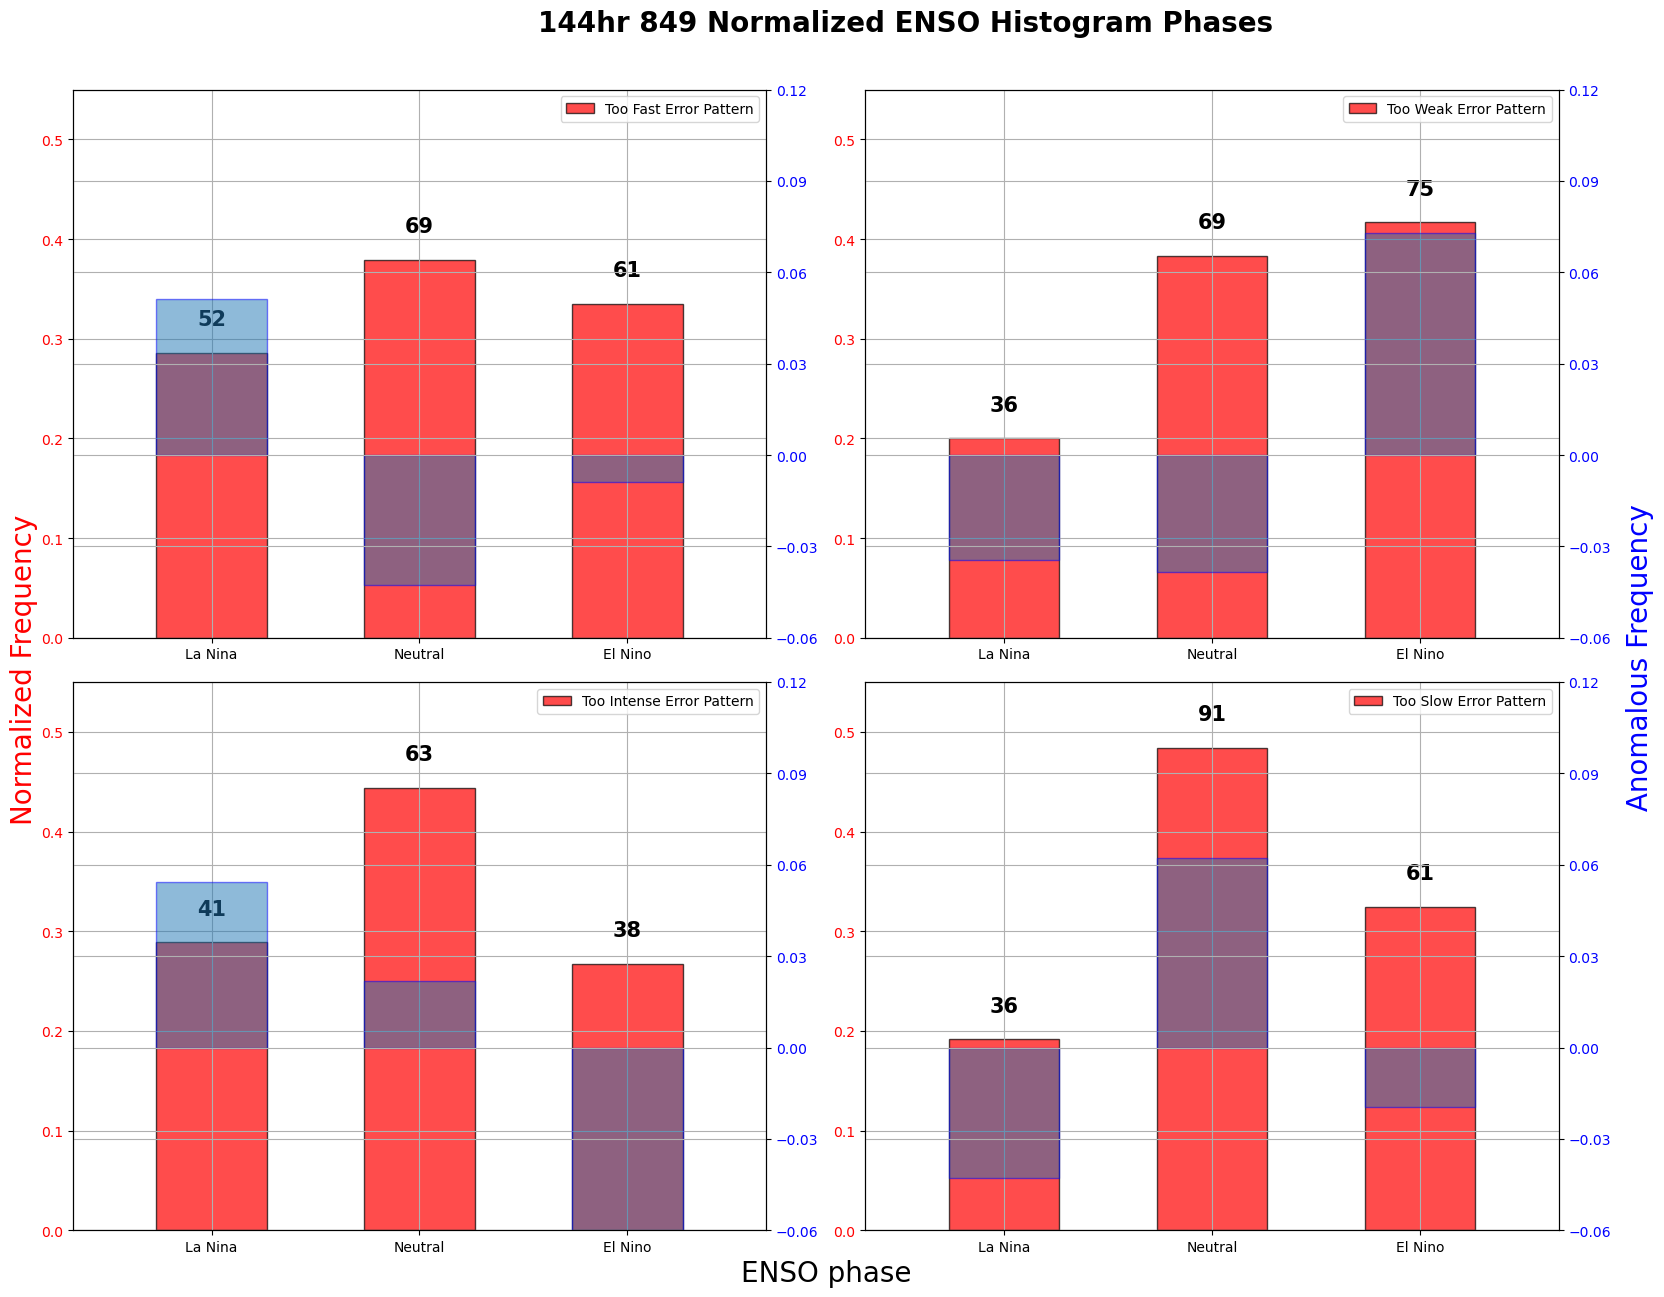

In [302]:
import matplotlib.pyplot as plt
import numpy as np

fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
enso_counts_dict_3 = {}
enso_hist_dict = {}  # Add this dictionary to store histogram data

label_list = ['Too Fast', 'Too Weak', 'Too Intense', 'Too Slow']
for map_num, (i, ax) in enumerate(zip(di_four.keys(), geo_axs.flatten())):
    key_i_values = di_four[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = [-2.5, -0.5, 0.5, 2.5]
    labels = ['La Nina', 'Neutral', 'El Nino']

    bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    enso_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    enso_counts_dict_3[i] = enso_counts_total

    enso_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = enso_counts_total / len(all_values_for_i)  # Normalize by the total count
    print(len(all_values_for_i))
    
    enso_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
    twin_ax = ax.twinx()
    twin_ax.bar(bin_centers, normalized_hist-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

#     twin_ax.set_ylim([-.12, 0.10])
    twin_ax.tick_params(axis='y', labelcolor='blue')
    
    ax.set_xlim([min(bin_centers) - 1, max(bin_centers) + 1])
    twin_ax.set_xlim([min(bin_centers) - 1, max(bin_centers) + 1])
    
#     ax.set_yticks(np.linspace(0, 0.4, 4))  # Set desired y-tick values
#     twin_ax.set_yticks(np.arange(-.12, 0.10,.050))  # Set desired y-tick values
    
#     ax.yaxis.set_major_locator(plt.MaxNLocator(5))
#     twin_ax.yaxis.set_major_locator(plt.MaxNLocator(5))

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} Error Pattern'.format(label_list[map_num]))

    # Add annotations for raw counts
    for x, y in zip(bin_centers, enso_counts_dict_3[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 20), ha='center', fontsize=15, fontweight='bold', color='black')

    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='y', labelcolor='red')
    twin_ax.set_ylim([-.06, 0.12])
    ax.set_ylim([0,0.55])
    twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
    twin_ax.grid(None)

    
#     ax.set_yticks(np.arange(0, 0.5, 0.1))  # Set desired y-tick values
#     twin_ax.set_yticks(np.arange(-0.05, 0.10, 0.05))  # Set desired y-tick values
    

    ax.legend()
    #yrange=np.linspace(0,0.45,10)
#     ax.set_ylim([0,0.45])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'ENSO phase', ha='center', fontsize=20)
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(1, .38, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 849 Normalized ENSO Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=20, y=1.05, x=0.55, fontweight='bold'
)

plt.show()


In [269]:
#check of doing it another way #

In [270]:
# import matplotlib.pyplot as plt
# import numpy as np

# fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
# enso_counts_dict = {}
# enso_hist_dict = {}

# label_list = ['Too Fast', 'Too Weak', 'Too Intense', 'Too Slow']

# for map_num, (i, ax) in enumerate(zip(di_four.keys(), geo_axs.flatten())):
#     key_i_values = di_four[i]
#     all_values_for_i = np.concatenate(list(key_i_values.values()))
#     all_values_for_i = all_values_for_i[all_values_for_i != None]

#     # Adjust the number of bins to match the desired x-axis labels
#     bins = [-2.5, -0.5, 0.5, 2.5]
#     labels = ['La Nina', 'Neutral', 'El Nino']

#     bin_centers = 0.5 * np.diff(bins) + bins[:-1]

#     # Compute the raw counts for each bin
#     enso_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
#     enso_counts_dict[i] = enso_counts_total

#     # Manually normalize the histogram
#     bin_widths = np.diff(bins)
#     normalized_hist = enso_counts_total / len(all_values_for_i)  # Normalize by the total count
#     enso_hist_dict[i] = normalized_hist

#     # Plot the bar graph for ENSO values:
#     ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7,
#            label='{} Error Pattern'.format(label_list[map_num]))

#     # Add annotations for raw counts
#     for x, y in zip(bin_centers, enso_counts_dict[i]):
#         ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points",
#                     xytext=(0, 20), ha='center', fontsize=15, fontweight='bold', color='black')

#     # Use the bin centers as x-ticks and set the labels
#     ax.set_xticks(bin_centers)
#     ax.set_xticklabels(labels)
#     ax.tick_params(axis='y', labelcolor='red')

#     ax.legend()
#     ax.set_ylim([0, 0.45])
#     ax.grid(zorder=0)

# plt.tight_layout()
# fig.text(0.5, -0.01, 'ENSO phase', ha='center', fontsize=20)
# fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
# fig.text(1, .38, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
# fig.suptitle(
#     "144hr 849 Normalized ENSO Histogram Phases".format(sigma=newsom._sigma, lr=newsom._learning_rate),
#     fontsize=20, y=1.05, x=0.55, fontweight='bold'
# )

# plt.show()


In [251]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Sample data (replace this with your actual data)
# all_values = [value for values_list in di_oni.values() for value in values_list]

# # Adjust the number of bins to match the desired x-axis labels
# bins = [-2.5, -0.5, 0.5, 2.5]
# labels = ['La Nina', 'Neutral', 'El Nino']

# # Calculate the histogram with density=True
# hist_values, bin_edges = np.histogram(all_values, bins=bins, density=True)

# # Create the dictionary density_counts
# density_counts = {'values': hist_values, 'bin_edges': bin_edges}

# # Calculate the positions of the labels
# bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# label_positions = bin_centers 

# # Place the labels at the calculated positions
# plt.xticks(label_positions, labels)

# # Create the histogram using plt.bar
# plt.bar(bin_centers, density_counts['values'], width=np.diff(bins), align='center', edgecolor='black', alpha=0.7)

# # Set labels and title
# plt.xlabel('Values')
# plt.ylabel('Normalized Frequency')
# plt.title('Normalized Histogram of All Oni Values')

# # Display the histogram
# plt.show()

# # Save the density_counts dictionary for later use
# # You can save it in a file or use it as needed


In [282]:
52+69+61,36+69+75,41+63+38,36+91+61

(182, 180, 142, 188)

In [185]:
69/182

0.3791208791208791

In [187]:
norm_total_counts

array([0.2343934 , 0.42167256, 0.34393404])

In [189]:
enso_hist_dict[0,0]

array([0.28571429, 0.37912088, 0.33516484])

In [192]:
enso_hist_dict

{(0, 0): array([0.28571429, 0.37912088, 0.33516484]),
 (0, 1): array([0.2       , 0.38333333, 0.41666667]),
 (1, 0): array([0.28873239, 0.44366197, 0.26760563]),
 (1, 1): array([0.19148936, 0.48404255, 0.32446809])}

In [191]:
(enso_hist_dict[0,0]-norm_total_counts)/(norm_total_counts)

array([ 0.2189519 , -0.10091166, -0.02549676])

In [193]:
(enso_hist_dict[1,1]-norm_total_counts)/(norm_total_counts)

array([-0.18304287,  0.14791097, -0.05659793])

In [265]:
enso_counts_dict

{(0, 0): array([52, 69, 61]),
 (0, 1): array([36, 69, 75]),
 (1, 0): array([41, 63, 38]),
 (1, 1): array([36, 91, 61])}

In [288]:
enso_hist_dict[0,0],norm_total_counts

(array([0.28571429, 0.37912088, 0.33516484]),
 array([0.2343934 , 0.42167256, 0.34393404]))

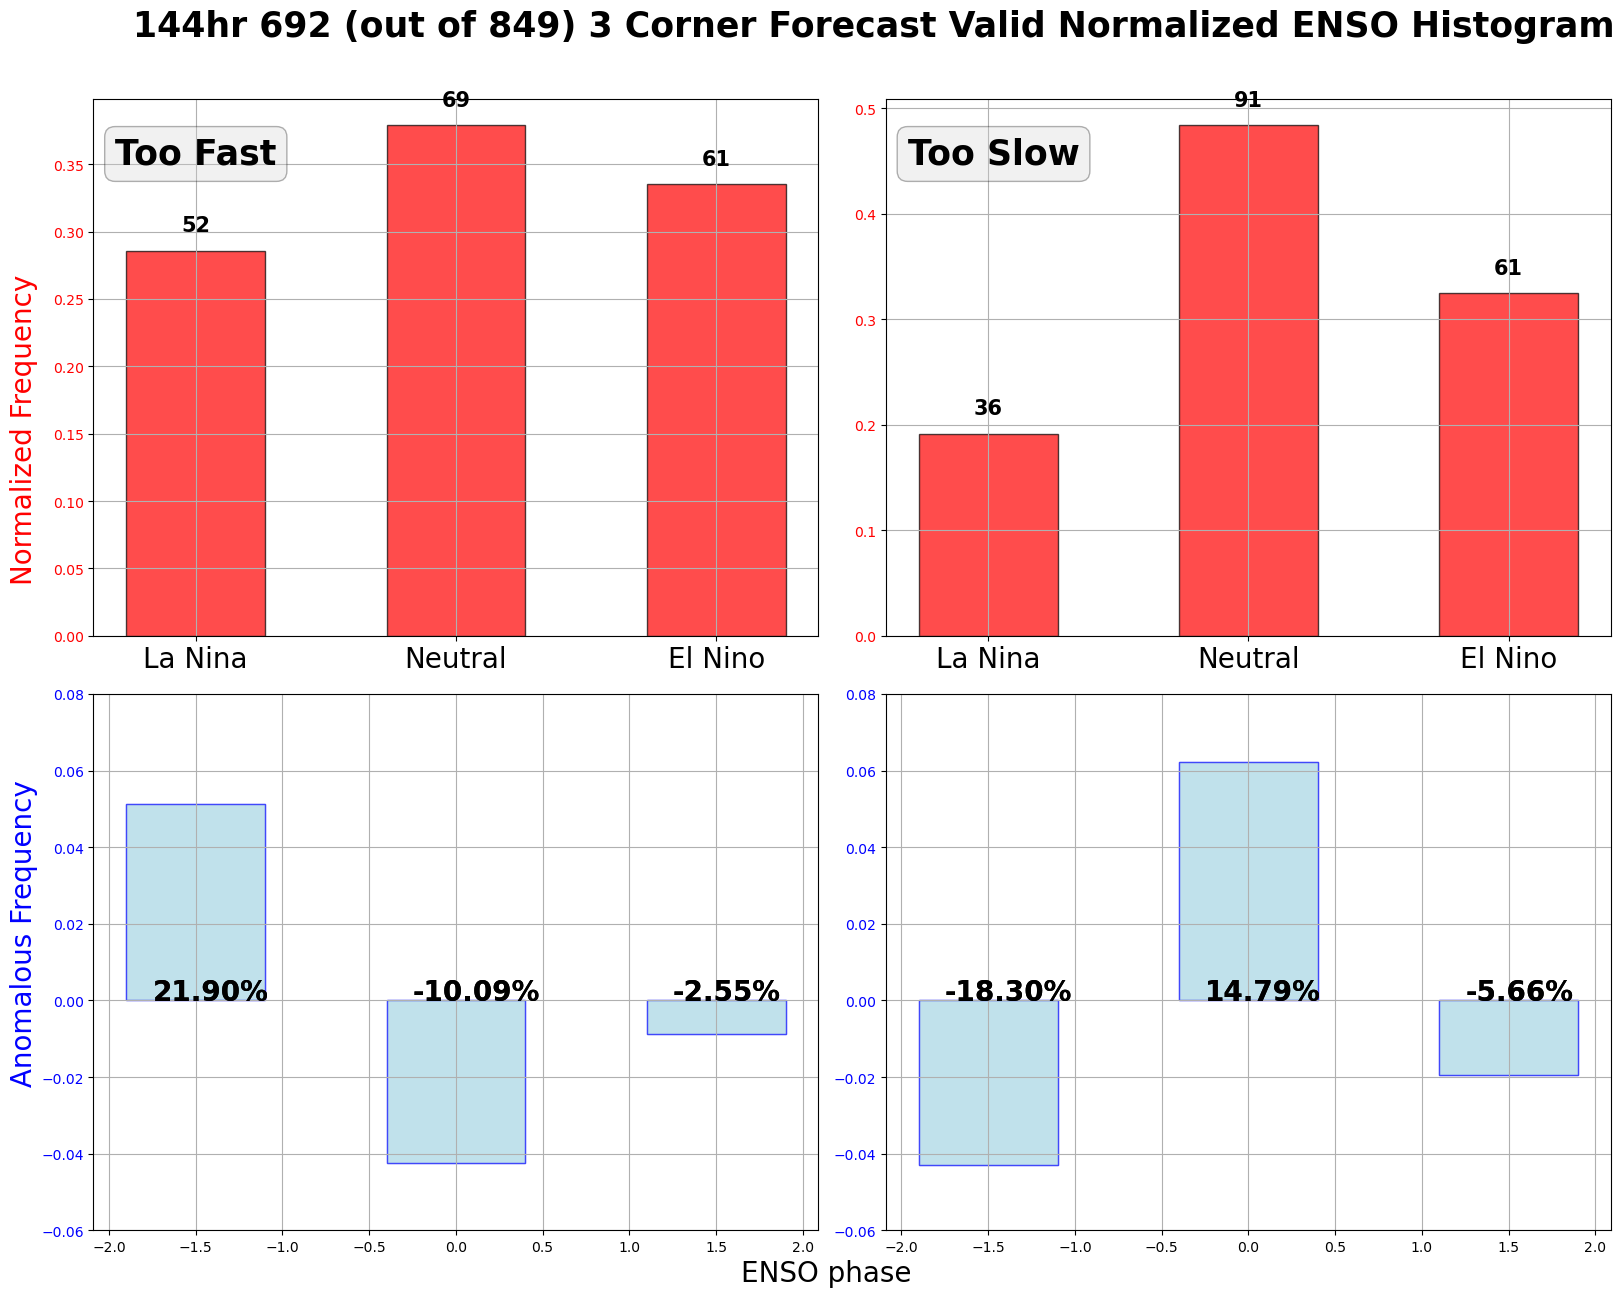

In [303]:
import matplotlib.pyplot as plt
import numpy as np

fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
# enso_counts_dict = {}
#enso_hist_dict = {}  # Add this dictionary to store histogram data
keys_to_plot = [(0, 0), (1, 1)] 
labels_list = [[label_list[0]], [label_list[1]]]

label_list = ['Too Fast', 'Too Slow']
for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    key_i_values = di_four[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = [-2.5, -0.5, 0.5, 2.5]
    labels = ['La Nina', 'Neutral', 'El Nino']

    bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    enso_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    enso_counts_dict[i] = enso_counts_total

    enso_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = enso_counts_total / len(all_values_for_i)  # Normalize by the total count
    
    enso_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
#     twin_ax = ax.twinx()
#     twin_ax.bar(bin_centers, normalized_hist-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

#     twin_ax.set_ylim([-0.05, 0.20])
#     twin_ax.tick_params(axis='y', labelcolor='blue')
#     twin_ax.set_ylim([-0.06, 0.12])
#     ax.set_ylim([0, 0.45])
#     twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

    geo_axs[1,0].bar(bin_centers, enso_hist_dict[0,0]-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5,color='lightblue')
    geo_axs[1,1].bar(bin_centers, enso_hist_dict[1,1]-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, color='lightblue')
    geo_axs[1,1].grid(zorder=0)
    geo_axs[1,0].grid(zorder=0)
    
    geo_axs[1,1].set_ylim([-0.06,0.08])
    geo_axs[1,0].set_ylim([-0.06,0.08])
    geo_axs[1,1].tick_params(axis='y', labelcolor='blue')
    geo_axs[1,0].tick_params(axis='y', labelcolor='blue')
    

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7)

    # Add annotations for raw counts
    for x, y in zip(bin_centers, enso_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 14), ha='center', fontsize=15, fontweight='bold', color='black')
    
    for x, y in zip(bin_centers, ((enso_hist_dict[0,0]-norm_total_counts)/(norm_total_counts))*100):
        
        geo_axs[1, 0].text(x-.25, 0, f"{y:.2f}%", fontsize=20, fontweight='bold', color='black')
        
    for x, y in zip(bin_centers, ((enso_hist_dict[1,1]-norm_total_counts)/(norm_total_counts))*100):
        
        geo_axs[1, 1].text(x-.25, 0, f"{y:.2f}%", fontsize=20, fontweight='bold', color='black')
#     for x, y in zip(bin_centers,  np.round(normalized_hist-norm_total_counts,2)*100):
#         ax.annotate(f"{y}%", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, -3), ha='center', fontsize=15, fontweight='bold', color='black')


    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels,fontsize=20)
    ax.tick_params(axis='y', labelcolor='red')
  
    

#     ax.legend()
#     ax.set_ylim([0, 0.45])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'ENSO phase', ha='center', fontsize=20)
fig.text(-0.01, 0.7, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(-0.01, .15, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 692 (out of 849) 3 Corner Forecast Valid Normalized ENSO Histogram".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=25, y=1.05, x=0.53, fontweight='bold'
)

plt.show()


In [300]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Sample data (replace this with your actual data)
# di_four_values = [value for key_values in di_four.values() for value_list in key_values.values() for value in value_list if value is not None]

# # Adjust the number of bins to match the desired x-axis labels
# bins = [-2.5, -0.5, 0.5, 2.5]
# labels = ['La Nina', 'Neutral', 'El Nino']

# # Calculate the positions of the labels
# bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# label_positions = bin_centers 

# # Place the labels at the calculated positions
# plt.xticks(label_positions, labels)

# # Create the histogram without density=True
# enso_counts,_ = np.histogram(di_four_values, bins=bins)

# # Calculate the total count
# total_count = np.sum(enso_counts)

# # Normalize the total counts and create the histogram
# norm_total_counts = enso_counts / total_count

# # Plot the normalized total counts
# plt.bar(bin_centers, norm_total_counts, width=np.diff(bins), align='center', edgecolor='black')
# area_under_histogram = np.sum(norm_total_counts * np.diff(bins))
# print("Area under the histogram:", area_under_histogram)

# # Set labels and title
# plt.xlabel('Values')
# plt.ylabel('Normalized Frequency')
# plt.title('Normalized Histogram of All di_four Values')

# # Display the histogram
# plt.show()


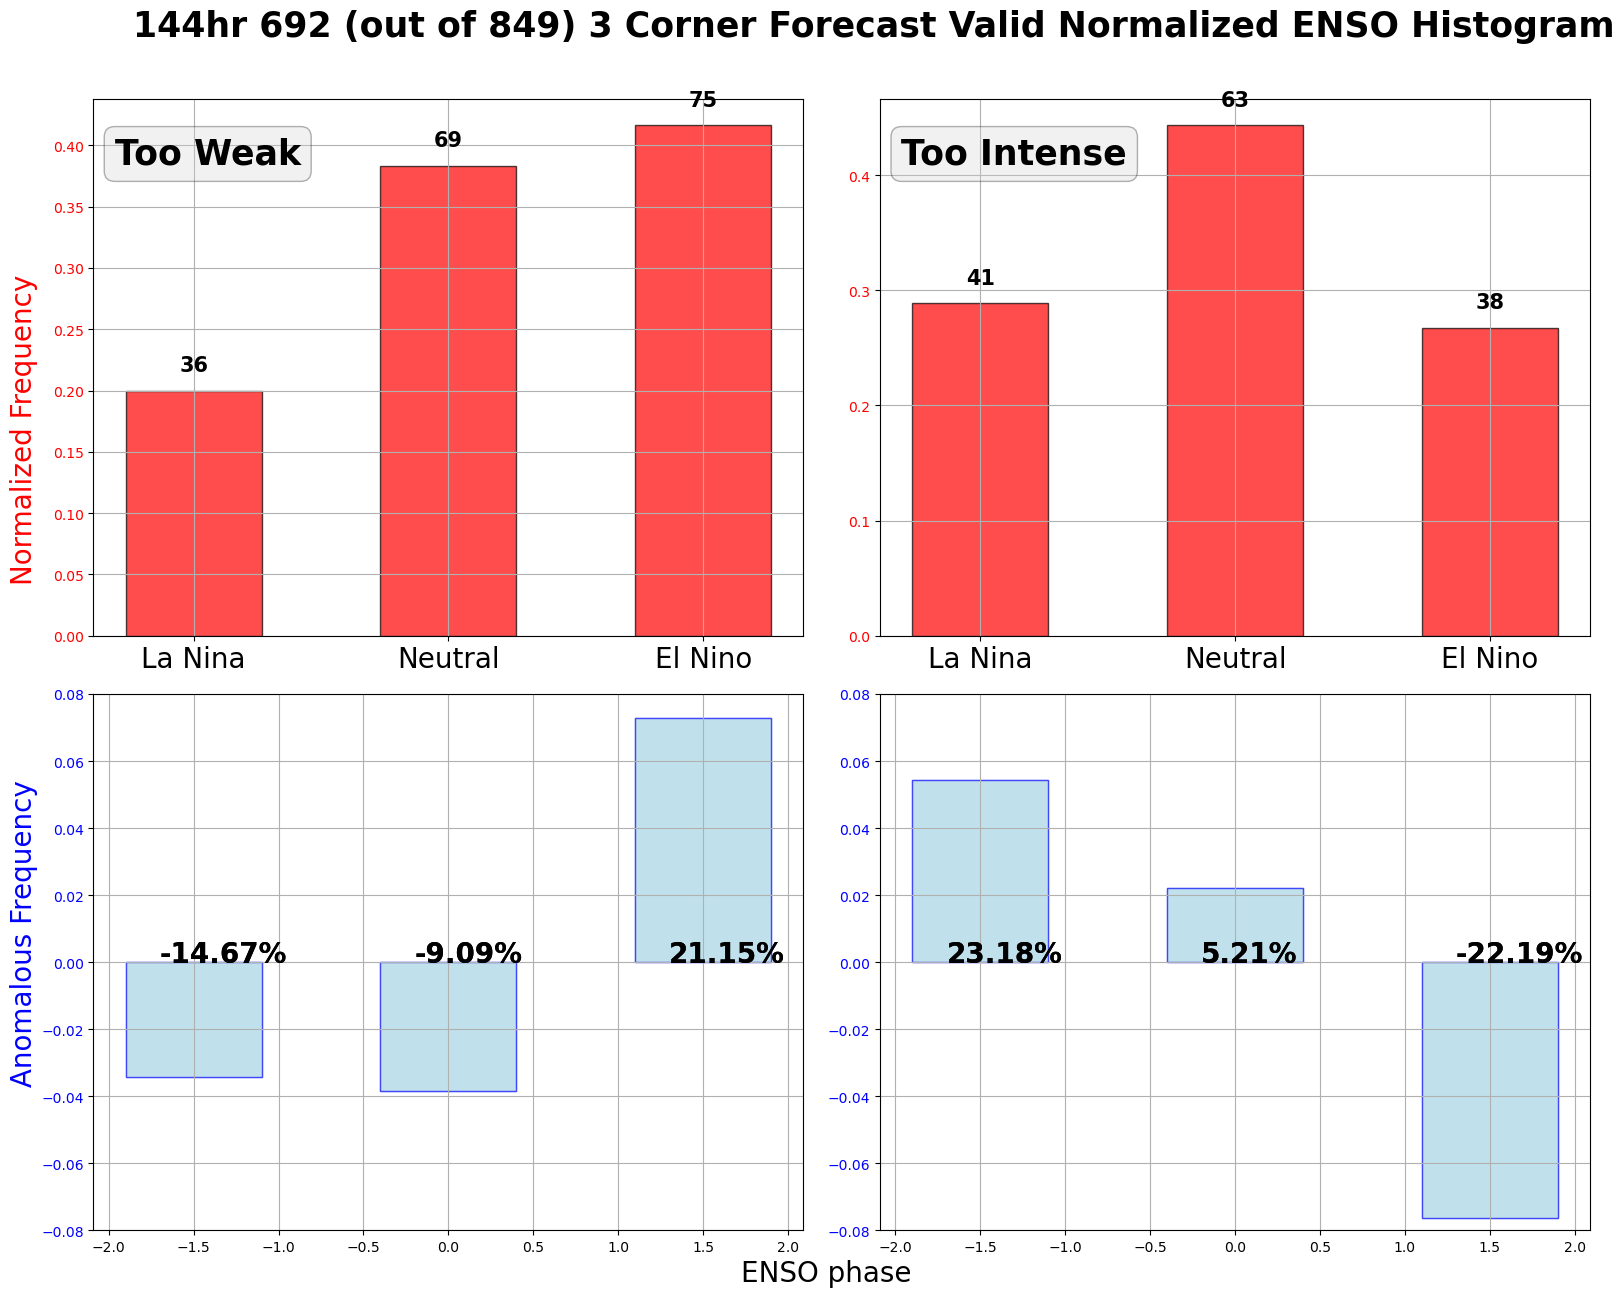

In [304]:
import matplotlib.pyplot as plt
import numpy as np

fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12))
# enso_counts_dict = {}
# enso_hist_dict = {}  # Add this dictionary to store histogram data
keys_to_plot = [(0, 1), (1, 0)] 
labels_list = [[label_list[0]], [label_list[1]]]

label_list = ['Too Weak', 'Too Intense']
for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    key_i_values = di_four[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))
    all_values_for_i = all_values_for_i[all_values_for_i != None]

    # Adjust the number of bins to match the desired x-axis labels
    bins = [-2.5, -0.5, 0.5, 2.5]
    labels = ['La Nina', 'Neutral', 'El Nino']

    bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    # Compute the raw counts for each bin
    enso_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
#     enso_counts_dict[i] = enso_counts_total

    enso_hist, bin_edges = np.histogram(
        all_values_for_i,
        bins=bins,
        density=True,)  # Normalize to get a probability density


    # Manually normalize the histogram
    bin_widths = np.diff(bins)
    normalized_hist = enso_counts_total / len(all_values_for_i)  # Normalize by the total count
    
#     enso_hist_dict[i] = normalized_hist

    # Plot the bar graph for histogram differences
#     twin_ax = ax.twinx()
#     twin_ax.bar(bin_centers, normalized_hist-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')

#     twin_ax.set_ylim([-0.05, 0.20])
#     twin_ax.tick_params(axis='y', labelcolor='blue')
#     twin_ax.set_ylim([-0.06, 0.12])
#     ax.set_ylim([0, 0.45])
#     twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))

    geo_axs[1,0].bar(bin_centers, enso_hist_dict[0,1]-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5,color='lightblue')
    geo_axs[1,1].bar(bin_centers, enso_hist_dict[1,0]-norm_total_counts, width=0.8, align='center', edgecolor='blue', alpha=0.5, color='lightblue')
    geo_axs[1,0].grid(zorder=0)
    geo_axs[1,1].grid(zorder=0)
    
    geo_axs[1,0].set_ylim([-0.08,0.08])
    geo_axs[1,1].set_ylim([-0.08,0.08])
    geo_axs[1,0].tick_params(axis='y', labelcolor='blue')
    geo_axs[1,1].tick_params(axis='y', labelcolor='blue')
    

    # Plot the bar graph for ENSO values:
    ax.bar(bin_centers, normalized_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7)

    # Add annotations for raw counts
    for x, y in zip(bin_centers, enso_counts_dict[i]):
        ax.annotate(f"{y}", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, 14), ha='center', fontsize=15, fontweight='bold', color='black')
    
    for x, y in zip(bin_centers, ((enso_hist_dict[0,1]-norm_total_counts)/(norm_total_counts))*100):
        
        geo_axs[1, 0].text(x-.2, 0, f"{y:.2f}%", fontsize=20, fontweight='bold', color='black')
        
    for x, y in zip(bin_centers, ((enso_hist_dict[1,0]-norm_total_counts)/(norm_total_counts))*100):
        
        geo_axs[1, 1].text(x-.2, 0, f"{y:.2f}%", fontsize=20, fontweight='bold', color='black')
        
#     for x, y in zip(bin_centers,  np.round(normalized_hist-norm_total_counts,2)*100):
#         ax.annotate(f"{y}%", (x, normalized_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0, -3), ha='center', fontsize=15, fontweight='bold', color='black')


    # Use the bin centers as x-ticks and set the labels
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels,fontsize=20)
    ax.tick_params(axis='y', labelcolor='red')
  
    

#     ax.legend()
#     ax.set_ylim([0, 0.45])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'ENSO phase', ha='center', fontsize=20)
# fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
# fig.text(1, .38, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.text(-0.01, 0.7, 'Normalized Frequency', va='center', rotation='vertical', color='red', fontsize=20)
fig.text(-0.01, .15, ' Anomalous Frequency', color='blue', rotation=90, fontsize=20)
fig.suptitle(
    "144hr 692 (out of 849) 3 Corner Forecast Valid Normalized ENSO Histogram".format(sigma=newsom._sigma, lr=newsom._learning_rate),
    fontsize=25, y=1.05, x=0.53, fontweight='bold'
)

plt.show()


In [260]:
# Extract the values for the specified key
values_for_key = di_oni.get((1, 1), [])

# Calculate the mean using numpy's mean function
mean_value_1 = np.mean(values_for_key)

In [261]:
# Extract the values for the specified key
values_for_key = di_oni.get((1, 2), [])

# Calculate the mean using numpy's mean function
mean_value_2 = np.mean(values_for_key)

In [262]:
# Extract the values for the specified key
values_for_key = di_oni.get((2, 1), [])

# Calculate the mean using numpy's mean function
mean_value_3 = np.mean(values_for_key)

In [263]:
# Extract the values for the specified key
values_for_key = di_oni.get((2, 2), [])

# Calculate the mean using numpy's mean function
mean_value_4 = np.mean(values_for_key)

In [264]:
mean_value_1,mean_value_2,mean_value_3,mean_value_4

(0.1, 0.1854166666666667, 0.023809523809523798, 0.2027777777777778)

# Anomaly from all unmatched and matched

In [ ]:
pd.to_datetime(new_df['date'],format='%Y-%m-%d')

In [ ]:
df_new['date']

In [ ]:
new_df=pd.read_csv('144alldates.csv')
new_df=pd.DataFrame(new_df['date'],columns=['date'])
newest_df=pd.to_datetime(new_df['date'],format='%Y-%m-%d')

database = pd.merge(df_new, newest_df, on='date', how="inner")
mjo_data = pd.to_numeric(database['phase'])

# Adjust the number of bins to match the desired x-axis labels
bins = np.arange(0.5, 9.5)  # Adjusted to center the bins on x-tick marks

mjo_counts_umm, _, _ = plt.hist(mjo_data, bins=bins, density=True,
                            edgecolor='black', rwidth=0.5)

print("Histogram Counts:")
print(counts)

#plt.hist(mjo_data, bins=bins, density=True, edgecolor='black', rwidth=0.8)  # Adjusted rwidth for better visualization

x_ticks = range(0, 9)  # Adjusted to match the desired x-axis labels
plt.xticks(x_ticks)  # Updated to use plt.xticks instead of plt.set_xticks
  # Updated to use plt.xlabel

# plt.ylim([0, 0.3])
plt.xlim([0, 9])
plt.grid(zorder=0)

plt.tight_layout()
plt.xlabel('MJO phase', ha='center')
plt.ylabel('Number of ARs', va='center', rotation='vertical')
plt.title(
    "144hr 721 (out of 849) Normalized MJO ALL NODES \n Histogram Phases {sigma:.2f},LR:{lr:.4f}".format(sigma=newsom._sigma, lr=0.1),
    fontweight='bold'
)

plt.show()


In [ ]:
fig, geo_axs = plt.subplots(1, 2, figsize=(18, 8))

keys_to_plot = [(0, 0), (1, 1)] 

label_list = ['Too Fast', 'Too Slow']

for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    print(i,ax)

    
    key_i_values = di_mjo_quart[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))

    bins = np.arange(1, 10)
    bin_centers = bins[:-1] #+ 0.5
    
    mjo_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    mjo_counts_dict[i] = mjo_counts_total
    
    mjo_hist = mjo_counts_total / len(all_values_for_i)

    ax.bar(bin_centers, mjo_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} MJO Mode'.format(label_list[map_num]))
    
#     mjo_hist, bin_edges, _ = ax.hist(
#         all_values_for_i,
#         bins=bins,
#         density=True,
#         edgecolor='black',
#         rwidth=0.8,
#         color='red',
#         label='{} MJO Mode'.format(label_list[map_num]),
#     )
    
    mjo_differences = mjo_hist - mjo_counts_umm
    
    # Plot the bar graph for histogram differences
    twin_ax = ax.twinx()
#     twin_ax.set_ylim([-0.045, 0.10])
    twin_ax.set_ylim([-0.04, 0.18])
    ax.set_ylim([0, 0.25])
    twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
    twin_ax.tick_params(axis='y', labelcolor='blue')
    twin_ax.bar(bin_centers, mjo_differences, width=0.8, edgecolor='blue', alpha=0.5)
    
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))
    
    for x, y in zip(bin_centers, np.round(mjo_differences,3)):
        ax.annotate(f"{y} %", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(1,3), ha='center', fontsize=15, fontweight='bold', color='black')
    
    
    for x, y in zip(bin_centers, mjo_counts_dict[i]):
        ax.annotate(f"{y}", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
    
    ax.set_xticks(bin_centers)
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend()
    ax.set_ylim([0, 0.25])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'MJO phase', ha='center', fontsize=20)

fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical',color='red', fontsize=20)
fig.text(1,.38,' Anomalous Frequency', color='blue',rotation=90, fontsize=20)
fig.suptitle(
    "144hr 713 (out of 849) Normalized MJO Valid Histogram Phases",
    fontsize=20, y=1.05, x=0.50, fontweight='bold'
)

plt.show()


In [ ]:
fig, geo_axs = plt.subplots(1, 2, figsize=(18, 8))

keys_to_plot = [(0, 1), (1, 0)] 

label_list = ['Too Weak', 'Too Intense']

for map_num, (i, ax) in enumerate(zip(keys_to_plot , geo_axs.flatten())):
    print(i,ax)

    
    key_i_values = di_mjo_quart[i]
    all_values_for_i = np.concatenate(list(key_i_values.values()))

    bins = np.arange(1, 10)
    bin_centers = bins[:-1] #+ 0.5
    
    mjo_counts_total, _ = np.histogram(all_values_for_i, bins=bins)
    mjo_counts_dict[i] = mjo_counts_total
    
    mjo_hist = mjo_counts_total / len(all_values_for_i)

    ax.bar(bin_centers, mjo_hist, width=0.8, align='center', color='red', edgecolor='black', alpha=0.7, label='{} MJO Mode'.format(label_list[map_num]))
    
#     mjo_hist, bin_edges, _ = ax.hist(
#         all_values_for_i,
#         bins=bins,
#         density=True,
#         edgecolor='black',
#         rwidth=0.8,
#         color='red',
#         label='{} MJO Mode'.format(label_list[map_num]),
#     )
    
    mjo_differences = mjo_hist - mjo_counts_umm
    
    # Plot the bar graph for histogram differences
    twin_ax = ax.twinx()
#     twin_ax.set_ylim([-0.045, 0.10])
    twin_ax.set_ylim([-0.04, 0.18])
    ax.set_ylim([0, 0.25])
    twin_ax.set_yticks(np.linspace(twin_ax.get_yticks()[0], twin_ax.get_yticks()[-1], len(ax.get_yticks())))
    twin_ax.tick_params(axis='y', labelcolor='blue')
    twin_ax.bar(bin_centers, mjo_differences, width=0.8, edgecolor='blue', alpha=0.5, label='Difference btw total AR MJO signal')
    
    ax.text(0.03, 0.93, label_list[map_num], transform=ax.transAxes, fontsize=25, fontweight='bold', color='black',
            ha='left', va='top', bbox=dict(facecolor='lightgray', alpha=0.3, edgecolor='black', boxstyle='round'))
    
    for x, y in zip(bin_centers, np.round(mjo_differences,3)):
        ax.annotate(f"{y} %", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(1,3), ha='center', fontsize=15, fontweight='bold', color='black')
    
    
    for x, y in zip(bin_centers, mjo_counts_dict[i]):
        ax.annotate(f"{y}", (x, mjo_hist[np.where(bin_centers == x)[0][0]]), textcoords="offset points", xytext=(0,20), ha='center', fontsize=15, fontweight='bold', color='black')
    
    ax.set_xticks(bin_centers,fontsize=20)
   
    ax.tick_params(axis='y', labelcolor='red')
#     ax.legend()
    ax.set_ylim([0, 0.25])
    ax.grid(zorder=0)

plt.tight_layout()
fig.text(0.5, -0.01, 'MJO phase', ha='center', fontsize=20)

fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical',color='red', fontsize=20)
fig.text(1,.38,' Anomalous Frequency', color='blue',rotation=90, fontsize=20)
fig.suptitle(
    "144hr 713 (out of 849) Normalized Valid MJO Histogram Phases",
    fontsize=20, y=1.05, x=0.50, fontweight='bold'
)

plt.show()


In [ ]:
# quant_df = pd.DataFrame(quant_list, columns=['Quant Error'])
# quant_df['Topo Error'] = pd.DataFrame(topo_list)
# quant_df['Hyperparameters']=pd.DataFrame(dict_sl.keys())

# #Add a 'Sigma' and 'Learning Rate' column to the DataFrames
# # quant_df['Sigma'] = sigma_arr
# # quant_df['Learning Rate'] = lr_arr
# # topo_df['Sigma'] = sigma_arr
# # topo_df['Learning Rate'] = lr_arr

In [ ]:
# dist_pd=pd.DataFrame(dist_new['variable'][np.array(winmap[som_keys[map_num]])])
# rmse_pd=pd.DataFrame(dict_rmse[som_keys[map_num]])
# dist_pd.corrwith(rmse_pd).mean()

In [ ]:
# dist_new.to_netcdf('dist_matched144.nc')
#dict_rmse.to_csv('dict_rmse.csv')

In [ ]:
# import csv
# with open('dict_rmse.csv', 'w') as csv_file:  
#     writer = csv.writer(csv_file)
#     for key, value in dict_rmse.items():
#        writer.writerow([key, value])

In [ ]:
# corr_pd=[]
# for map_num in range(len(som_keys)):
    
#     dist_pd=pd.DataFrame(dist_new['variable'][np.array(winmap[som_keys[map_num]])])
#     rmse_pd=pd.DataFrame(dict_rmse[som_keys[map_num]])
#     dist_pd.corrwith(rmse_pd).mean()
#     corr_pd.append(dist_pd.corrwith(rmse_pd).mean())

In [ ]:
# corr=[]
# for map_num in range(len(som_keys)):

#     print(np.nanmean(np.corrcoef(dist_new['variable'][np.array(winmap[som_keys[map_num]])],dict_rmse[som_keys[map_num]])))
#     print(np.corrcoef(dist_new['variable'][np.array(winmap[som_keys[map_num]])],dict_rmse[som_keys[map_num]]))

In [ ]:
# for dates in di_dates[2,3]:
#     era5ss_match['variable'].sel(time=dates).plot(x='lon',y='lat',vmin=200,vmax=1000)
#     plt.show()

In [ ]:
total_era=xr.open_dataset('/cw3e/mead/projects/cdd105/2023.03.26_from_PJM/Reanalysis/ERA5/IVT/2017/ERA5_IVT_20170109.nc')

In [ ]:
total_era.variables

In [ ]:
total_wrf=xr.open_dataset('/cw3e/mead/projects/cdd105/30Year_Verif_from_PJM/1986-1987/1986120200/d01/cf/wrfcf_d01_1986-12-08_00_00_00.nc')

In [ ]:
total_wrf

In [ ]:
import matplotlib.colors as mcolors

########### Define the colors in the desired sequence for IVT: ###########

colors = ['#FFFF00', '#FFEE00','#FFDC00', '#FFB700',
          '#FFA300', '#FF9000', '#FF7D00', '#FF6800',
          '#FF5200', '#C70039','#900C3F', (.88,.24,.69)]

############## Create a colormap using ListedColormap #################

cmap_ss = mcolors.ListedColormap(colors)

In [ ]:
for dates in di_dates[3,3]:
    date_fmt=str(dates.values)[:10]
 
    init_folder_144=(pd.to_datetime(dates.values)-datetime.timedelta(days=6)).strftime("%Y%m%d%H")
#     print(init_folder_144)
    
    file=sorted(glob.glob('/cw3e/mead/projects/cdd105/30Year_Verif_from_PJM/*/'+init_folder_144+'/d01/cf/wrfcf_d01_'+date_fmt+'_00_00_00.nc'))
    print(file)
    
    for f in file:
    
        total_wrf=xr.open_dataset(f)
    # #Get IVT

        lats=total_wrf['lat']
        lons=total_wrf['lon']
        new_lons = np.where(lons > 0, lons - 360, lons)
        ivt = total_wrf['IVT'].isel(time=0)

        #Plot the IVT 

        fig = plt.figure(figsize=(20,16))
        ax = plt.axes(projection= ccrs.PlateCarree(central_longitude=-155))
        ax.set_extent([-175, -120, 25, 55], crs = ccrs.PlateCarree())
        ax.add_feature(cfeature.STATES, edgecolor='black')  #Add US states
        ax.add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines

        ivt_levels = np.arange(500, 1450, 10)
        cs = ax.contourf(new_lons, lats.values, ivt,levels=ivt_levels, cmap=cmap_ss,transform=ccrs.PlateCarree())

        #Add a colorbar
        ivt_cbar = plt.colorbar(cs, orientation = 'horizontal')
        ivt_cbar.set_label("IVT (kg $m^{-1}$$s^{-1}$)", fontsize = 16)

        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.top_labels=False   # suppress top labels
        gl.right_labels=False 
        ax.set_title('WRF IVT at '+str(ivt['time'].values))
        #plt.savefig('WRF IVT at '+ ivt['time']+'.png')
        plt.show()



In [ ]:
#  #Get IVT

# lats=total_wrf['lat']
# lons=total_wrf['lon']
# new_lons = np.where(lons > 0, lons - 360, lons)
# ivt = total_wrf['IVT'].isel(time=0)

# #Plot the IVT 

# fig = plt.figure(figsize=(20,16))
# ax = plt.axes(projection= ccrs.PlateCarree(central_longitude=-155))
# ax.set_extent([-175, -120, 25, 55], crs = ccrs.PlateCarree())
# ax.add_feature(cfeature.STATES, edgecolor='black')  #Add US states
# ax.add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines

# ivt_levels = np.arange(500, 1200, 10)
# cs = ax.contourf(new_lons, lats.values, ivt,levels=ivt_levels, cmap='viridis',transform=ccrs.PlateCarree())

# #Add a colorbar
# ivt_cbar = plt.colorbar(cs, orientation = 'horizontal')
# ivt_cbar.set_label("IVT (kg $m^{-1}$$s^{-1}$)", fontsize = 16)

# gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
# gl.top_labels=False   # suppress top labels
# gl.right_labels=False 
# ax.set_title('WRF IVT at '+str(ivt['time'].values))
# #plt.savefig('WRF IVT at '+ ivt['time']+'.png')
# plt.show()



In [ ]:
 #Get IVT
for dates in di_dates[3,3]:
    date_fmt=str(dates.values)[:10]
    init_folder_day=(pd.to_datetime(dates.values)).strftime("%Y%m%d%H")[:-2]
 
    year=date_fmt[:4]
    total_era=xr.open_dataset('/cw3e/mead/projects/cdd105/2023.03.26_from_PJM/Reanalysis/ERA5/IVT/'+year+'/ERA5_IVT_'+init_folder_day+'.nc')
    lats=total_era['lat']
    lons=total_era['lon']
    new_lons = np.where(lons > 0, lons - 360, lons)
    ivt = total_era['IVT'].isel(time=0)

    #Plot the IVT 

    fig = plt.figure(figsize=(20,16))
    ax = plt.axes(projection= ccrs.PlateCarree(central_longitude=-155))
    ax.set_extent([-175, -120, 25, 55], crs = ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES, edgecolor='black')  #Add US states
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines

    ivt_levels = np.arange(500, 1450, 10)
    cs = ax.contourf(new_lons, lats.values,ivt,levels=ivt_levels, cmap=cmap_ss,transform=ccrs.PlateCarree())

    #Add a colorbar
    ivt_cbar = plt.colorbar(cs, orientation = 'horizontal')
    ivt_cbar.set_label("IVT (kg $m^{-1}$$s^{-1}$)", fontsize = 16)

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels=False   # suppress top labels
    gl.right_labels=False 
    ax.set_title('ERA IVT at '+str(ivt['time'].values))
    #plt.savefig('ERA IVT at '+ ivt['time']+'.png')
    plt.show()

In [ ]:
diff_stack.unstack()

In [ ]:
diff_stack.shape[1]

In [ ]:
data2.shape

In [ ]:

from sklearn.model_selection import train_test_split
import optuna
from minisom import MiniSom

# Assuming diff_stack is your input data for unsupervised learning


def objective(trial):
    x = 4
    y = 4
    input_len = diff_stack.shape[1]
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)
    sigma = trial.suggest_float('sigma', 1.0, 3.0)
    
    flattened_diff_stack = diff_stack.values.reshape(diff_stack.shape[0], -1)

    som = MiniSom(x, y, input_len, sigma=sigma, learning_rate=learning_rate, random_seed=42)
    som.train_random(flattened_diff_stack, 1000)

    # You might want to add evaluation metrics for unsupervised learning here

    return 0  # Placeholder, replace with actual objective

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


In [ ]:
!which env

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [ ]:
import optuna.visualization as vis

# Assuming 'study' is your Optuna study object
ax = vis.plot_optimization_history(study)
ax.set_title('Optimization History')
ax.set_xlabel('Trial')
ax.set_ylabel('Objective Value')

In [ ]:
##import os 
#subprocess.call 

In [ ]:
height1=np.concatenate([wwrf_full['variable'][np.array(winmap[som_keys[0]])],wwrf_full['variable'][np.array(winmap[som_keys[1]])],
wwrf_full['variable'][np.array(winmap[som_keys[4]])]])

height2=np.concatenate([wwrf_full['variable'][np.array(winmap[som_keys[2]])],wwrf_full['variable'][np.array(winmap[som_keys[3]])],
wwrf_full['variable'][np.array(winmap[som_keys[7]])]])

height3=np.concatenate([wwrf_full['variable'][np.array(winmap[som_keys[8]])],
wwrf_full['variable'][np.array(winmap[som_keys[12]])],wwrf_full['variable'][np.array(winmap[som_keys[13]])]])

height4=np.concatenate([wwrf_full['variable'][np.array(winmap[som_keys[11]])],
wwrf_full['variable'][np.array(winmap[som_keys[14]])],wwrf_full['variable'][np.array(winmap[som_keys[15]])]])

In [ ]:
heightfull1=np.concatenate([full_hts2['variable'][np.array(winmap[som_keys[0]])],full_hts2['variable'][np.array(winmap[som_keys[1]])],
full_hts2['variable'][np.array(winmap[som_keys[4]])]])#full_hts2['variable'][np.array(winmap[som_keys[5]])]])

heightfull2=np.concatenate([full_hts2['variable'][np.array(winmap[som_keys[2]])],full_hts2['variable'][np.array(winmap[som_keys[3]])],
full_hts2['variable'][np.array(winmap[som_keys[7]])]])

heightfull3=np.concatenate([full_hts2['variable'][np.array(winmap[som_keys[8]])],
full_hts2['variable'][np.array(winmap[som_keys[12]])],full_hts2['variable'][np.array(winmap[som_keys[13]])]])

heightfull4=np.concatenate([full_hts2['variable'][np.array(winmap[som_keys[11]])],
                           full_hts2['variable'][np.array(winmap[som_keys[14]])],
                           full_hts2['variable'][np.array(winmap[som_keys[15]])]])

In [ ]:
height1_mean=np.mean(height1,axis=0)
height2_mean=np.mean(height2,axis=0)
height3_mean=np.mean(height3,axis=0)
height4_mean=np.mean(height4,axis=0)

height1full_mean=np.mean(heightfull1,axis=0)
height2full_mean=np.mean(heightfull2,axis=0)
height3full_mean=np.mean(heightfull3,axis=0)
height4full_mean=np.mean(heightfull4,axis=0)

In [ ]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
label_list = ['Too Fast', 'Too Weak', 'Too Intense', 'Too Slow']
Ht_levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040]
newlons=np.where(wwrf_full['lon'] < 0., wwrf_full['lon'], (wwrf_full['lon']-360.))

# Assuming you want to add text to the top-left subplot [0, 0]
label=geo_axs[0, 0].pcolormesh(height1_mean, vmin=-10, vmax=10, cmap='bwr')
htctr=geo_axs[0, 0].contour(newlons,wwrf_full['lat'],height1full_mean, vmin=-25, vmax=25, colors='black',levels=Ht_levels)
geo_axs[0, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 0].coastlines()
geo_axs[0, 0].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[0, 0].gridlines(draw_labels=True)
geo_axs[0,0].clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='black')

geo_axs[0, 1].pcolormesh(height2_mean, vmin=-10, vmax=10, cmap='bwr')
geo_axs[0, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 1].coastlines()
geo_axs[0, 1].text(0.05, 0.9, label_list[1], transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[0, 1].gridlines(draw_labels=True)
htctr2=geo_axs[0, 1].contour(newlons,wwrf_full['lat'],height2full_mean, vmin=-25, vmax=25, colors='black',levels=Ht_levels)
geo_axs[0,1].clabel(htctr2,htctr2.levels[::2],fmt='%1.0f',colors='black')


geo_axs[1, 0].pcolormesh(height3_mean, vmin=-10, vmax=10, cmap='bwr')
geo_axs[1, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 0].coastlines()
geo_axs[1, 0].text(0.05, 0.9, label_list[2], transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 0].gridlines(draw_labels=True)
htctr3=geo_axs[1, 0].contour(newlons,wwrf_full['lat'],height3full_mean, vmin=-25, vmax=25, colors='black',levels=Ht_levels)
geo_axs[1,0].clabel(htctr3,htctr3.levels[::2],fmt='%1.0f',colors='black')


geo_axs[1, 1].pcolormesh(height4_mean, vmin=-10, vmax=10, cmap='bwr')
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
htctr4=geo_axs[1, 1].contour(newlons,wwrf_full['lat'],height4full_mean, vmin=-10, vmax=10, colors='black',levels=Ht_levels)
geo_axs[1, 1].text(0.05, 0.9, label_list[3], transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
geo_axs[1, 1].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1,1].clabel(htctr4,htctr4.levels[::2],fmt='%1.0f',colors='black')

geo_axs[1, 1].gridlines(draw_labels=True)


cbar = fig.colorbar(label, ax=fig.get_axes())

cbar.ax.set_ylabel('500 mb ht anomaly (m)', rotation=270, fontsize=20, labelpad=20)

#plt.tight_layout()
fig.suptitle(
    "144hr 849 Normalized Ht Anomaly Histogram Phases",
    fontsize=20, y=.90, x=0.45, fontweight='bold'
)

plt.show()
